# Telecom Churn Case Study

### Objective:
We are given the data of a Telecommunication Company for four months, and our objective is the identify high-valued customers that are at a high risk of churn during the last month

### Method: 
 - Identify High Valued Customers i.e. customers in 70%ile in terms of usage during the first two months
 - Tag churners and remove attributes of the churn phase
 - Derive new features
 - Remove attributes with high missing values, and very low variance
 - Impute missing values in the relevant columns
 - Perform PCA, plot scree plot and identify the least number of Principal components to explain high degree of variance
 - Use SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance
 - Feed the PCA output to various models and use Evaluating Metrics to identify the best classifier
 - Perform Random Forest Classifier to identify the important variables


In [1]:
# import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, make_scorer, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from time import time
pd.set_option('display.max_rows', 999)

In [2]:
# loading the data
data = pd.read_csv('telecom_churn_data.csv')
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [3]:
# checking the shape of the dataframe
data.shape

(99999, 226)

In [4]:
# observing the number of null values and the datatype of each column
data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             99999 non-null  int64  
 1    circle_id                 99999 non-null  int64  
 2    loc_og_t2o_mou            98981 non-null  float64
 3    std_og_t2o_mou            98981 non-null  float64
 4    loc_ic_t2o_mou            98981 non-null  float64
 5    last_date_of_month_6      99999 non-null  object 
 6    last_date_of_month_7      99398 non-null  object 
 7    last_date_of_month_8      98899 non-null  object 
 8    last_date_of_month_9      98340 non-null  object 
 9    arpu_6                    99999 non-null  float64
 10   arpu_7                    99999 non-null  float64
 11   arpu_8                    99999 non-null  float64
 12   arpu_9                    99999 non-null  float64
 13   onnet_mou_6               96062 non-null  fl

In [5]:
# Most columns of the dataframe are of numeric type, and there are a few date type columns as well

## Data Preparation

### Identify High Valued Customers i.e. customers in 70%ile in terms of usage during the first two months

In [6]:
# Since we are interested in only the high valued customers, 
# creating a new column containing the sum of the recharge amount during the good phase
avg_reach_amt_6_7 = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2
quant_70 = avg_reach_amt_6_7.quantile(0.7)
print('70th percentile of recharge amount in good phase: ',quant_70)

70th percentile of recharge amount in good phase:  368.5


In [7]:
# creating a new dataframe with data of only the high valued customers
high_valued = data[avg_reach_amt_6_7 > quant_70].reset_index(drop=True)
high_valued.shape

(29979, 226)

### Tag churners and remove attributes of the churn phase

In [8]:
# To identify the churned customers, we define churn as not having any netowrk usage during the 9th month
# to do so, creating a new variable that captures the total netowrk usage during the 9th month 
total_usage = high_valued['total_ic_mou_9'] + high_valued['total_og_mou_9'] + high_valued['vol_2g_mb_9'] + high_valued['vol_3g_mb_9']
# creating a new column that indicates whether the customer has churned or not
high_valued['churn'] = list(map(int,total_usage == 0))
high_valued.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000701601        109             0.0             0.0             0.0   
1     7001524846        109             0.0             0.0             0.0   
2     7002191713        109             0.0             0.0             0.0   
3     7000875565        109             0.0             0.0             0.0   
4     7000187447        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9    arpu_6  ...  fb_user_6  fb_user_7  fb_user_8  \
0            9/30/2014  1069.180  ...        NaN        NaN        NaN   
1            9/30/2014   378.721  ...        NaN        1.0        1.0   
2            9/30/2014   492.846  ...        NaN        NaN        1.0   
3            9/30/2014   430.975  ...        NaN        NaN        NaN   
4            9/30/2014   690.008  ...        NaN        NaN        NaN   

   fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  churn  
0        NaN   802       57.74       19.38       18.74         0.0      1  
1        NaN   315       21.03      910.65      122.16         0.0      0  
2        NaN  2607        0.00        0.00        0.00         0.0      0  
3        NaN   511        0.00        2.45       21.89         0.0      0  
4        NaN   667        0.00        0.00        0.00         0.0      0  

[5 rows x 227 columns]

In [9]:
# before performing analysis, it was required that we remove any data of the 9th month or september
# identifying all the columns related to the 9th month
col_list_without_9 = list(map(lambda x: not x.endswith('_9') and x.find('sep')==-1, list(high_valued.columns)))
high_valued.columns[col_list_without_9]

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn'],
      dtype='object', length=172)

In [10]:
# dropping these columns from the dataframe
high_valued = high_valued[high_valued.columns[col_list_without_9]]
high_valued.shape

(29979, 172)

In [11]:
high_valued.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn'],
      dtype='object', length=172)

## Feature Engineering

### Derive new features

In [12]:
# as part of feature engineering creating new columns containing net change in usage during the good and active phases
high_valued['arpu_6_7'] = high_valued['arpu_7'] - high_valued['arpu_6']
high_valued['arpu_7_8'] = high_valued['arpu_8'] - high_valued['arpu_7']
high_valued['arpu_3g_6_7'] = high_valued['arpu_3g_7'] - high_valued['arpu_3g_6']
high_valued['arpu_3g_7_8'] = high_valued['arpu_3g_8'] - high_valued['arpu_3g_7']
high_valued['arpu_2g_6_7'] = high_valued['arpu_2g_7'] - high_valued['arpu_2g_6']
high_valued['arpu_2g_7_8'] = high_valued['arpu_2g_8'] - high_valued['arpu_2g_7']
high_valued['onnet_mou_6_7'] = high_valued['onnet_mou_7'] - high_valued['onnet_mou_6']
high_valued['onnet_mou_7_8'] = high_valued['onnet_mou_8'] - high_valued['onnet_mou_7']
high_valued['offnet_mou_6_7'] = high_valued['offnet_mou_7'] - high_valued['offnet_mou_6']
high_valued['offnet_mou_7_8'] = high_valued['offnet_mou_8'] - high_valued['offnet_mou_7']

In [13]:
# defining functions necessary for the next phase of EDA of plotting the categorical and numerical features (boxplot and countplot)
# function for plotting the categorical values
def plot_cat(col_list):
    global high_valued
    sns.set_style('darkgrid')
    temp = high_valued
    temp = temp.fillna('missing')
    for col in col_list:
        plt.figure(figsize=(15,4))
        
        count = temp[col].value_counts(normalize=True)*100

        plt.subplot(121)
        ax = sns.countplot(x=col, hue='churn', data=temp, order=count.index)    
        plt.xticks(rotation=90)

        plt.subplot(122)
        ax = sns.barplot(x=count.index, y=count, order=count.index)    
        plt.xticks(rotation=90)

        plt.show()

# function for plotting the numerical values        
def plot_num(col_list, log=False, dist=False):
    global high_valued
    sns.set_style('darkgrid')
    for col in col_list:
        plt.figure(figsize=(15,4))

        plt.subplot(121)
        ax = sns.boxplot(y=col, x='churn', data=high_valued)
        plt.xticks(rotation=90)
        if log:
            ax.set_yscale('log')

        plt.subplot(122)
        temp = high_valued[col][~np.isnan(high_valued[col])]
        sns.distplot(temp)        
        
        plt.show()

In [14]:
# Also defining functions for performing miscellaneous activities 
# function for displaying the null percentage of each column in the dataframe
def null_percent(col_list):
    global high_valued
    return (high_valued[col_list].isnull().sum()/len(high_valued)*100).sort_values(ascending=False)

# function to drop certain columns
def drop_col(col_list):
    global high_valued
    high_valued = high_valued.drop(col_list, axis=1)
    return high_valued.shape

# function for imputing missing values
itim = IterativeImputer(min_value=0,random_state=100)
def impute(col_list):
    global high_valued
    high_valued[col_list] = itim.fit_transform(high_valued[col_list])
    return null_percent(col_list) 

# function for displaying the maximum value and the count of that value
# this is useful to identify columns with little variance in the columns
def max_count(col_list):
    global high_valued
    def count(series):
        c = (series.value_counts()/len(high_valued)*100)
        n = c.index[0]
        v = c[n]
        return (n,v)
    return high_valued[col_list].apply(lambda x: count(x))

## EDA

### Remove attributes with high missing values, and very low variance

In [15]:
# handling of mobile number column
null_percent(['mobile_number'])

mobile_number    0.0
dtype: float64

In [16]:
# checking to see if there are any duplicates in the mobile number column
sum(high_valued.duplicated(subset = 'mobile_number')) == 0

True

In [17]:
# there are no duplicates
# however dropping this column because it is not useful for analysis
drop_col(['mobile_number'])

(29979, 181)

In [18]:
# handling of columns that have a high percent of missing values or show very little variance

In [19]:
cat_list = ['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_6','last_date_of_month_7',
            'last_date_of_month_8','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','night_pck_user_6',
            'night_pck_user_7','night_pck_user_8','monthly_2g_6','monthly_2g_7','monthly_2g_8','sachet_2g_6','sachet_2g_7',
            'sachet_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8',
            'fb_user_6','fb_user_7','fb_user_8']

In [20]:
num_list = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2f_mou_6',
            'loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','std_og_t2f_mou_6',
            'std_og_t2f_mou_7','std_og_t2f_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','og_others_6','og_others_7',
            'og_others_8','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
            'std_ic_t2o_mou_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
            'ic_others_6','ic_others_7','ic_others_8','total_rech_data_6','total_rech_data_7','total_rech_data_8',
            'max_rech_data_6','max_rech_data_7','max_rech_data_8','count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
            'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','av_rech_amt_data_6','av_rech_amt_data_7',
            'av_rech_amt_data_8','vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
            'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8','aug_vbc_3g','jul_vbc_3g','jun_vbc_3g',
            'arpu_6_7','arpu_7_8','arpu_3g_6_7','arpu_3g_7_8','arpu_2g_6_7','arpu_2g_7_8','onnet_mou_6_7','onnet_mou_7_8',
            'offnet_mou_6_7','offnet_mou_7_8']

In [21]:
len(cat_list+num_list)

104

In [22]:
# find percentage of null values in variables
null_percent(cat_list+num_list)

arpu_2g_7_8             69.895594
arpu_3g_7_8             69.895594
arpu_2g_6_7             69.265152
arpu_3g_6_7             69.265152
fb_user_6               62.016745
night_pck_user_6        62.016745
count_rech_3g_6         62.016745
av_rech_amt_data_6      62.016745
arpu_3g_6               62.016745
count_rech_2g_6         62.016745
arpu_2g_6               62.016745
max_rech_data_6         62.016745
total_rech_data_6       62.016745
night_pck_user_7        61.132793
av_rech_amt_data_7      61.132793
count_rech_2g_7         61.132793
fb_user_7               61.132793
max_rech_data_7         61.132793
count_rech_3g_7         61.132793
total_rech_data_7       61.132793
arpu_3g_7               61.132793
arpu_2g_7               61.132793
av_rech_amt_data_8      60.835918
night_pck_user_8        60.835918
count_rech_3g_8         60.835918
total_rech_data_8       60.835918
arpu_3g_8               60.835918
fb_user_8               60.835918
count_rech_2g_8         60.835918
arpu_2g_8     

In [23]:
max_count(cat_list+num_list)

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      109.0        0.000000        0.000000        0.000000   
1      100.0       99.619734       99.619734       99.619734   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1                100.0            99.896594              99.4763   

   std_og_t2c_mou_6  std_og_t2c_mou_7  std_og_t2c_mou_8  ...    arpu_6_7  \
0          0.000000          0.000000          0.000000  ...  102.682000   
1         98.945929         98.989293         96.871143  ...    0.010007   

   arpu_7_8  arpu_3g_6_7  arpu_3g_7_8  arpu_2g_6_7  arpu_2g_7_8  \
0  0.000000     0.000000     0.000000      0.00000      0.00000   
1  0.373595     8.682745     8.355849      5.69065      6.13763   

   onnet_mou_6_7  onnet_mou_7_8  offnet_mou_6_7  offnet_mou_7_8  
0       0.000000       0.000000        0.000000        0.000000  
1       0.780546       1.017379        0.256846        0.353581  

[2 rows x 104 columns]

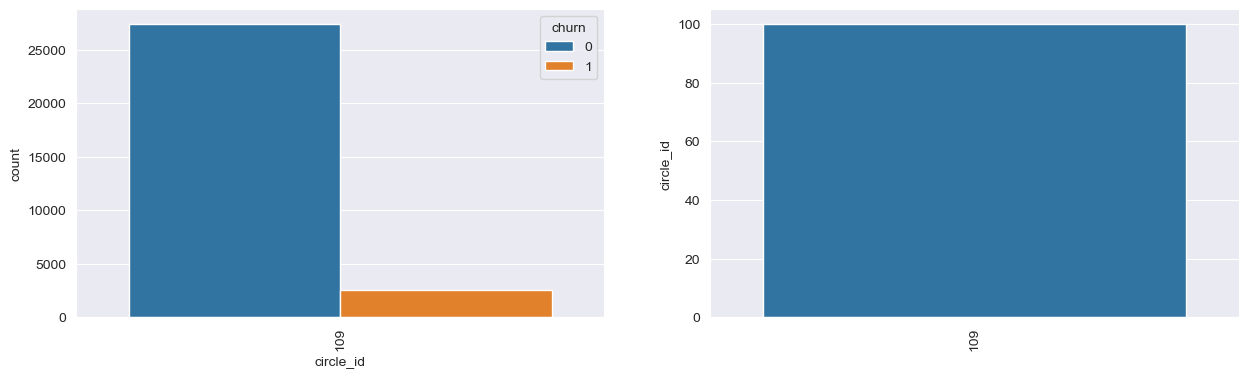

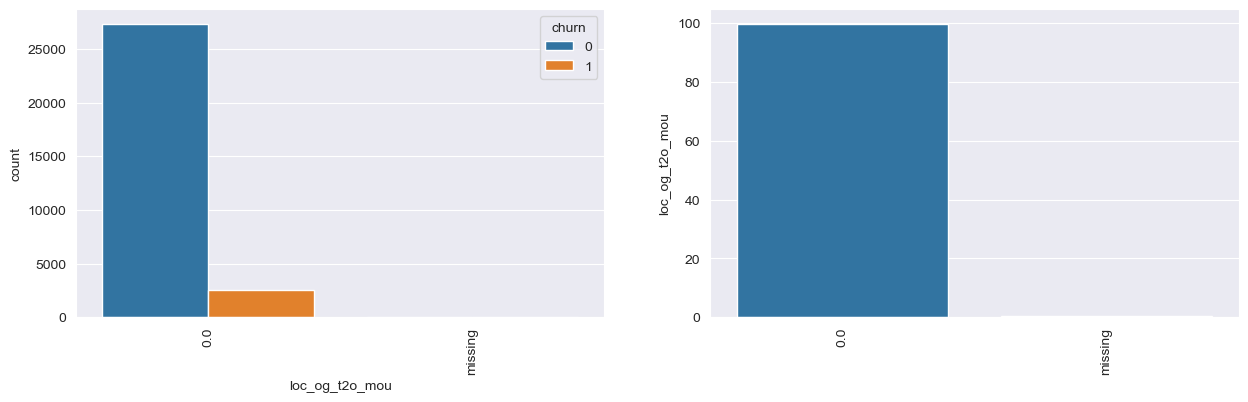

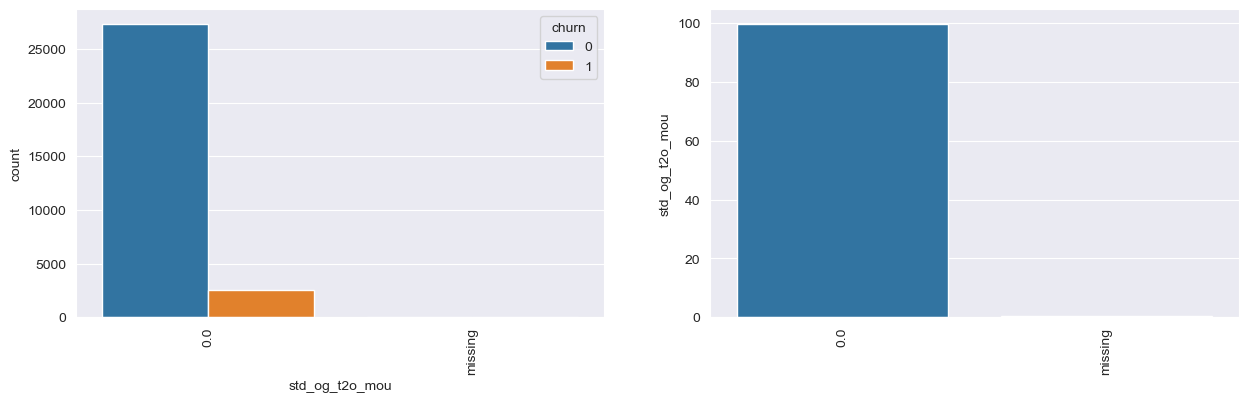

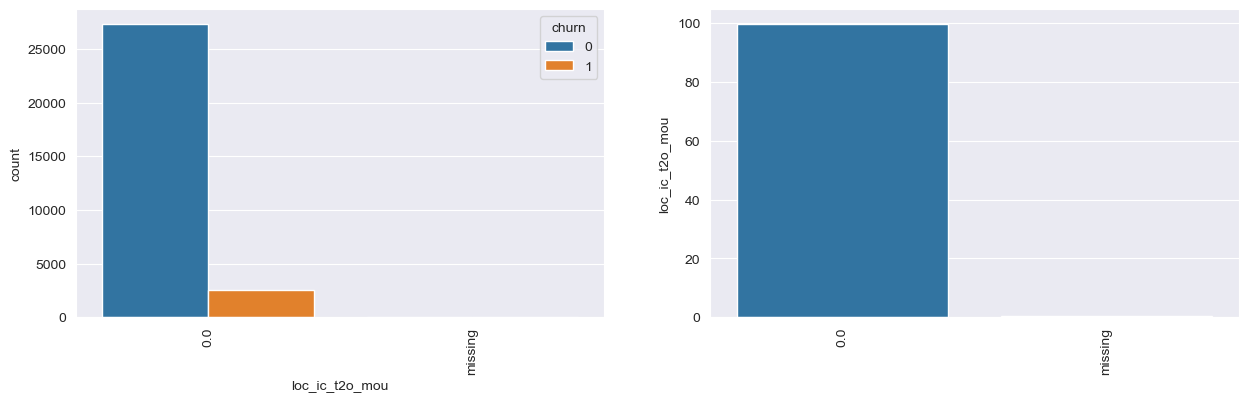

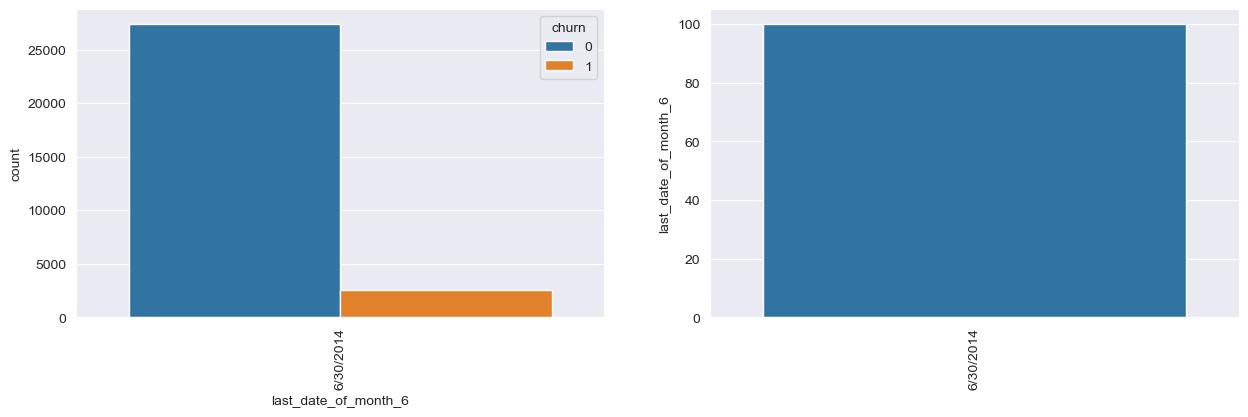

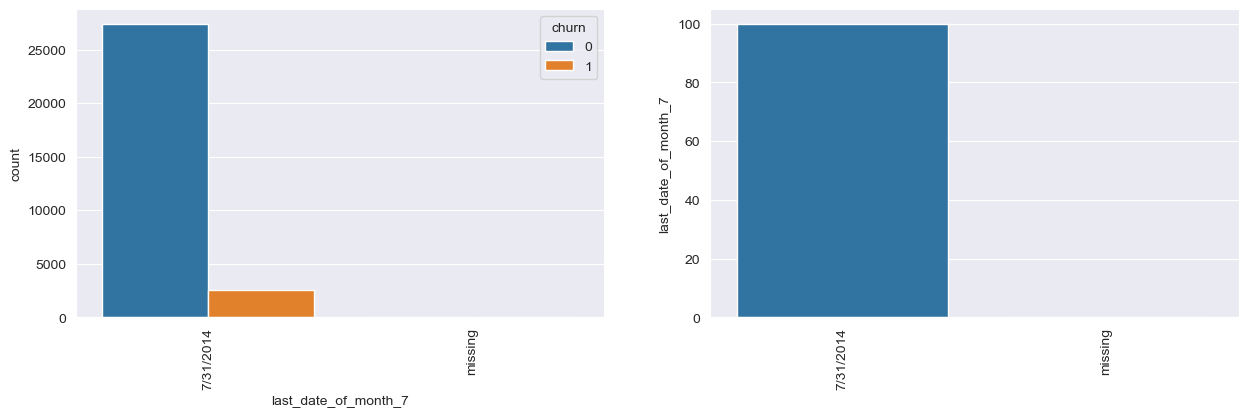

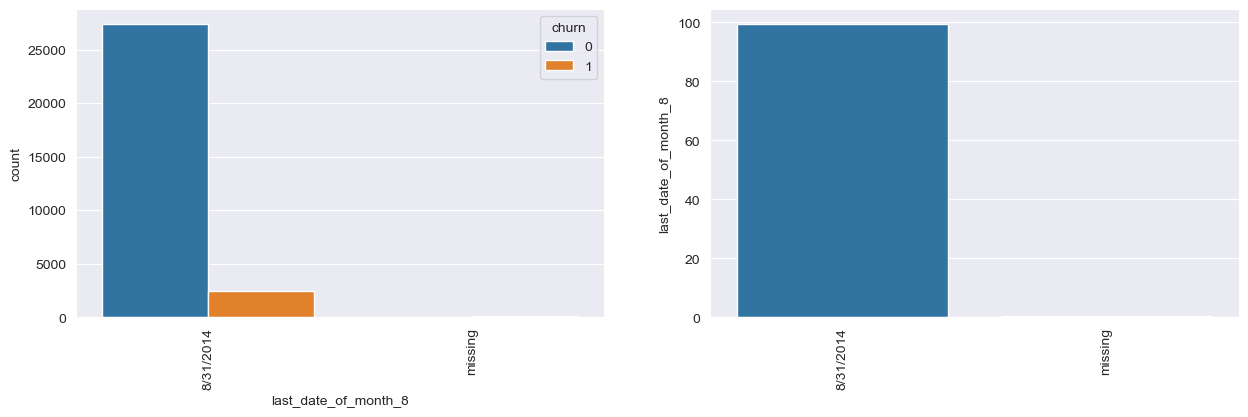

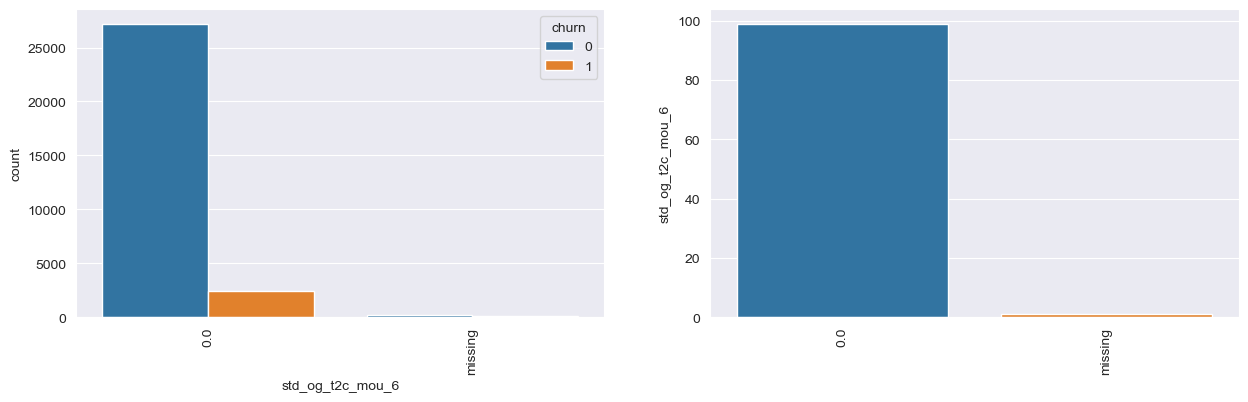

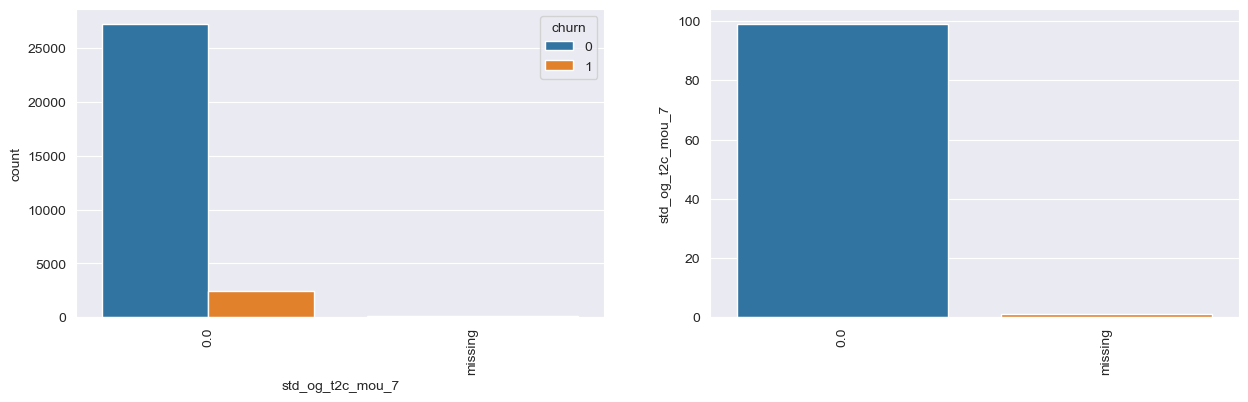

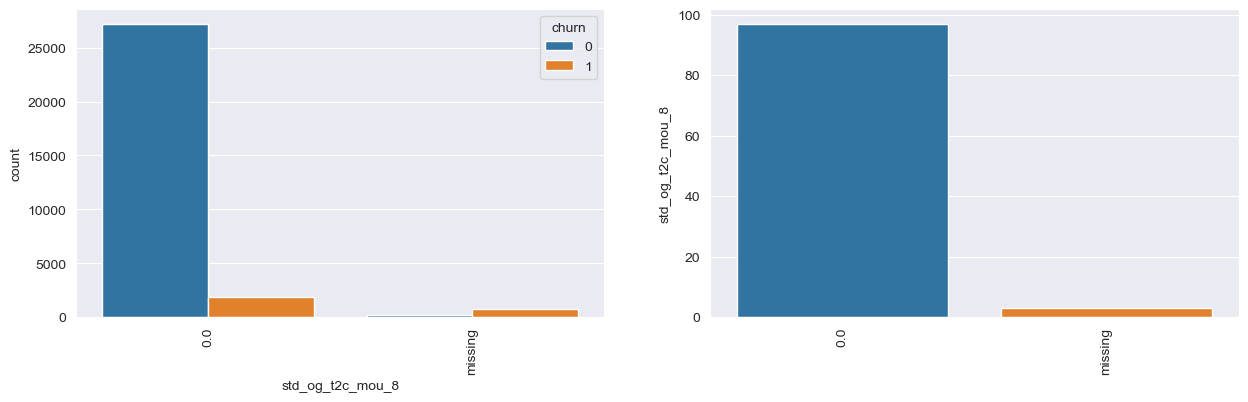

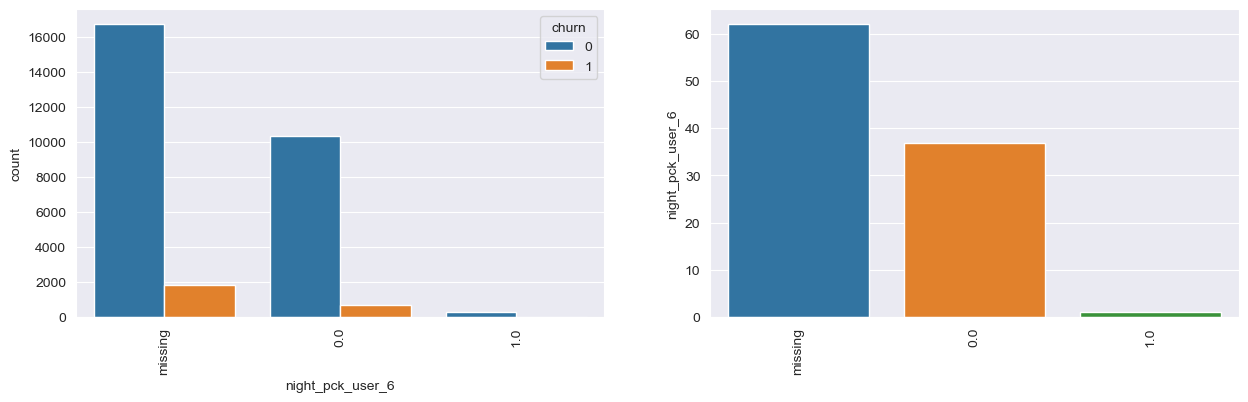

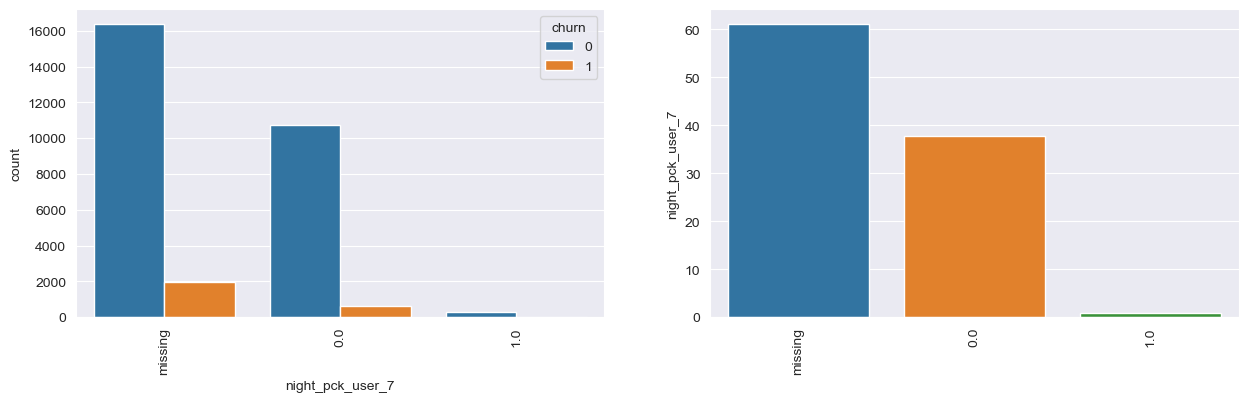

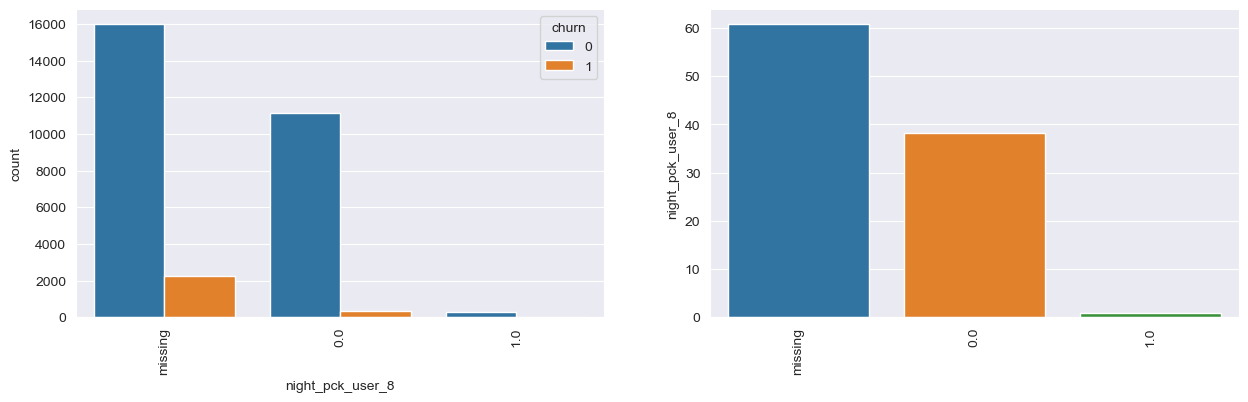

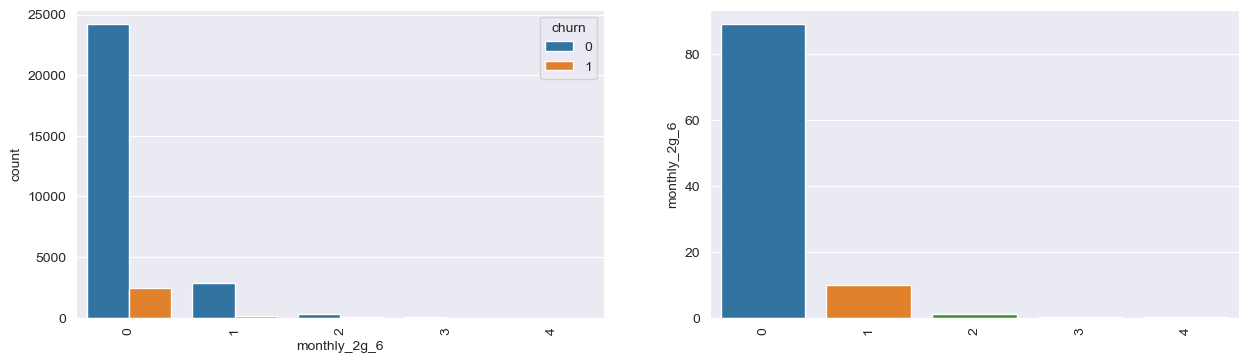

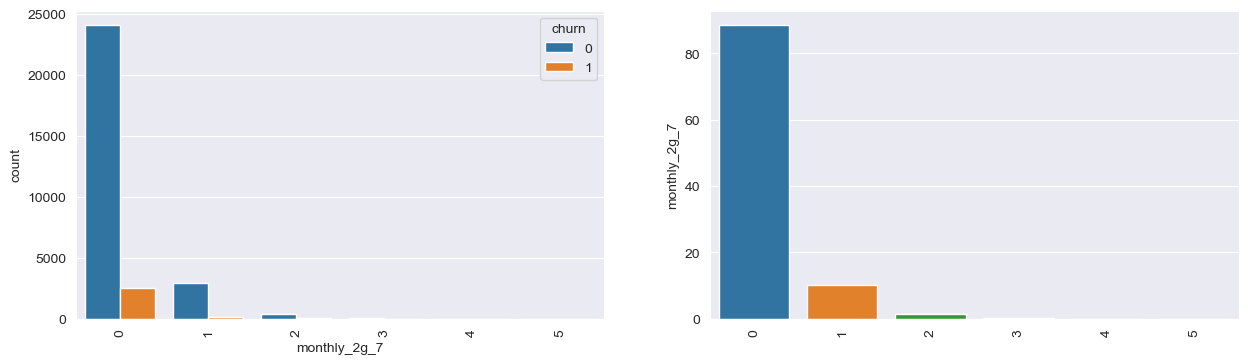

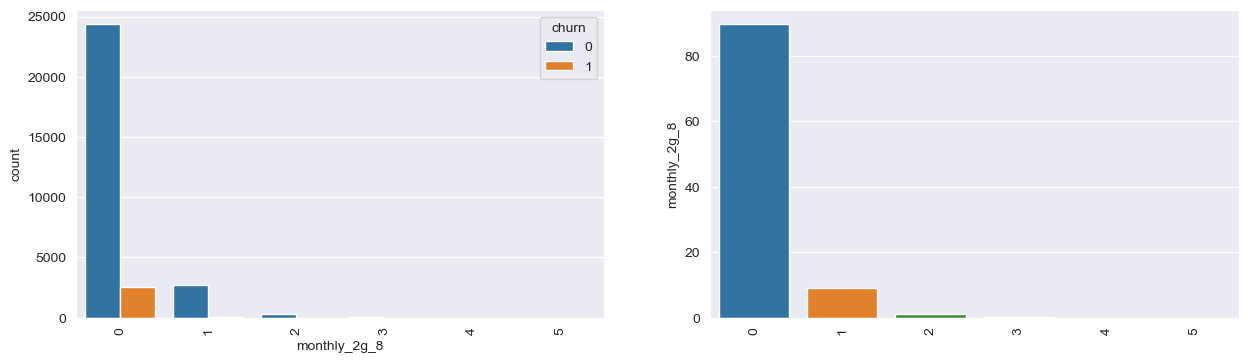

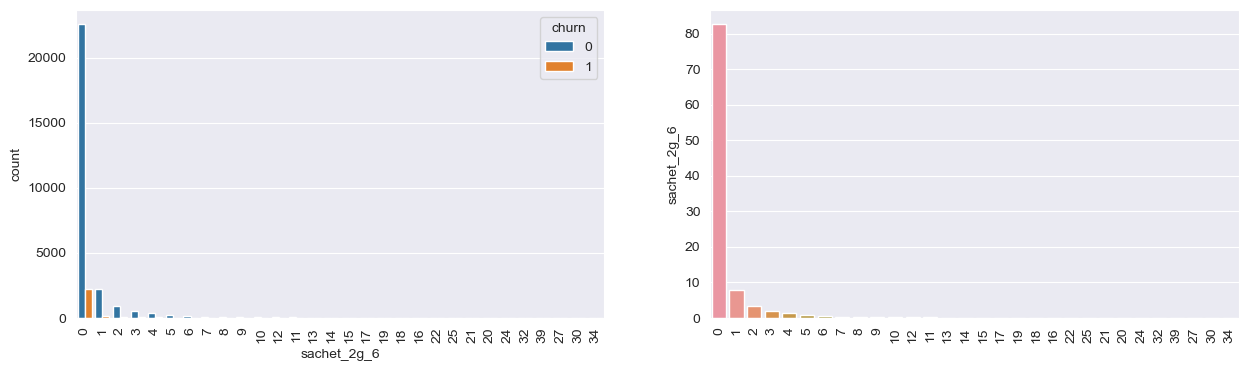

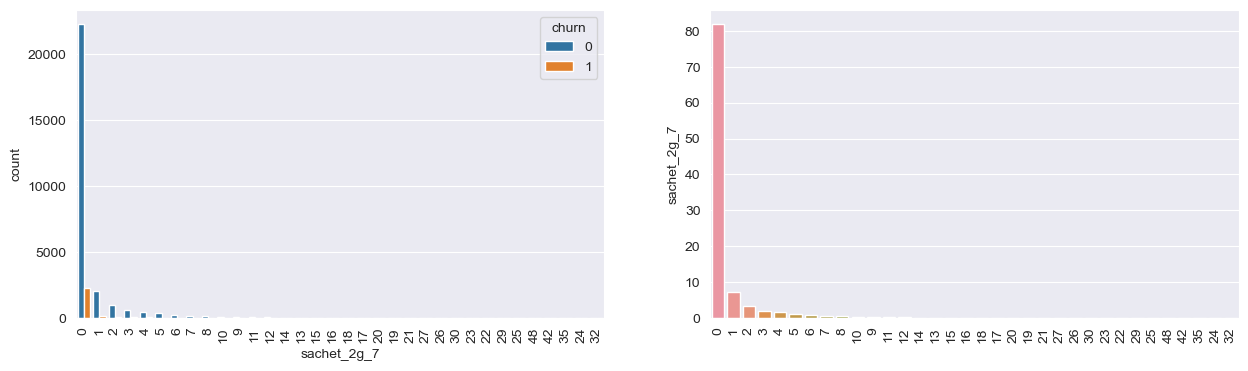

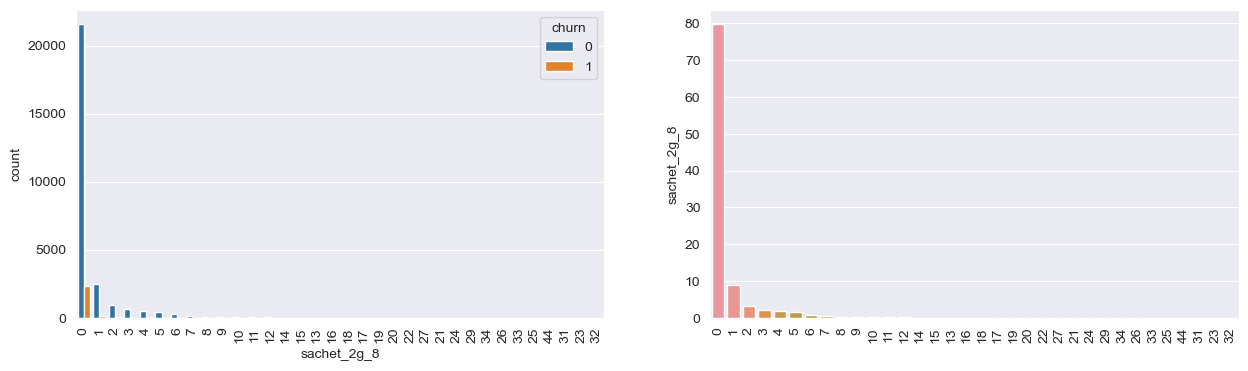

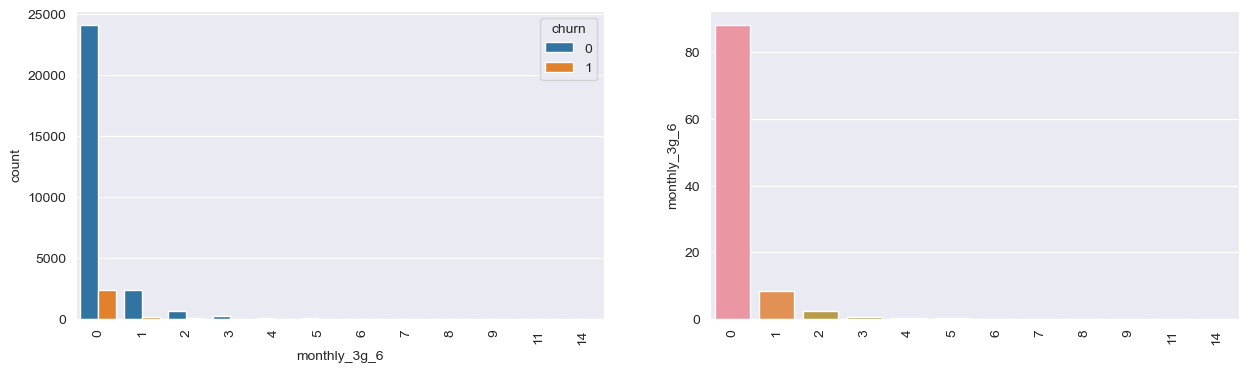

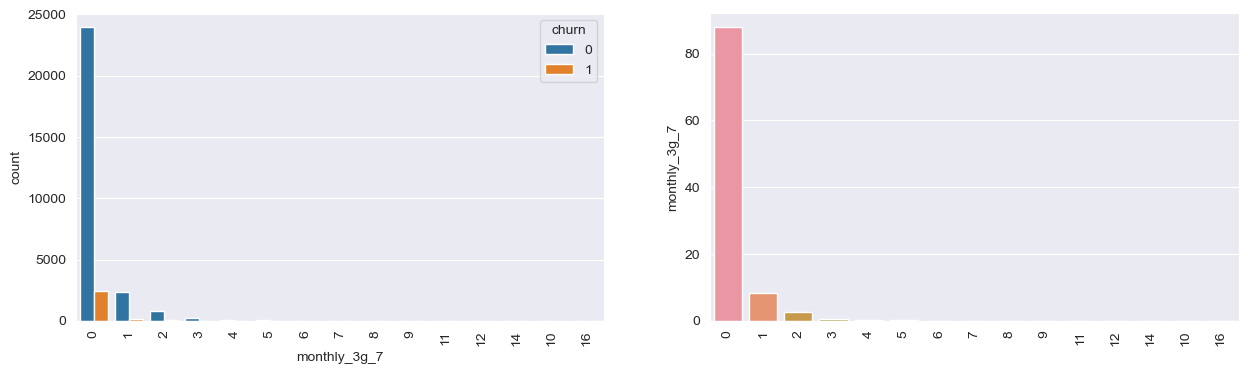

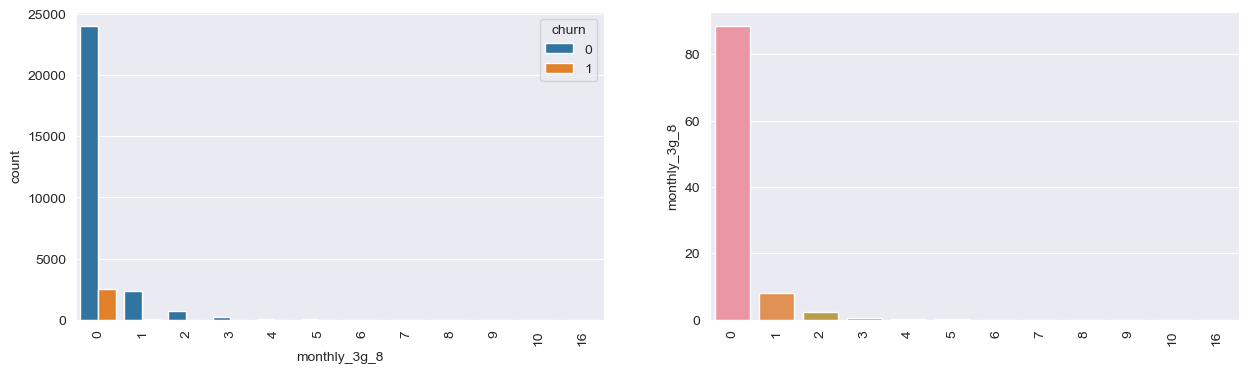

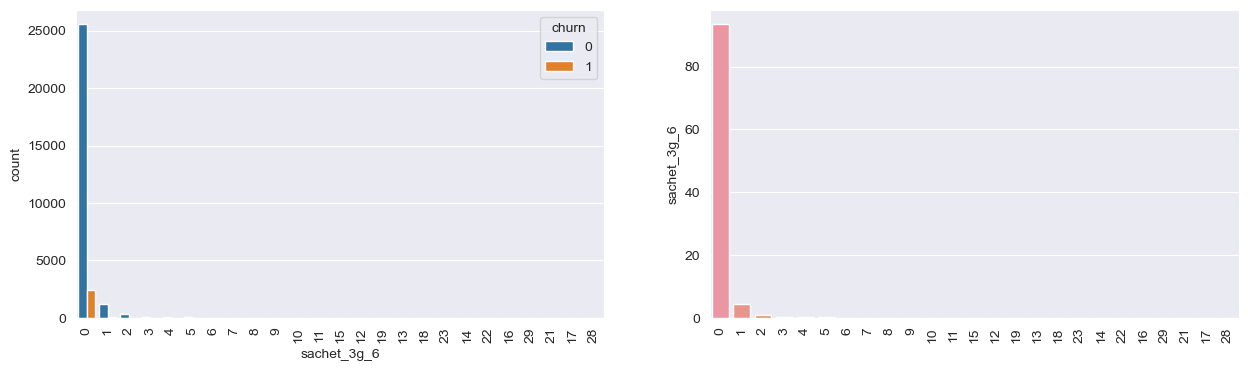

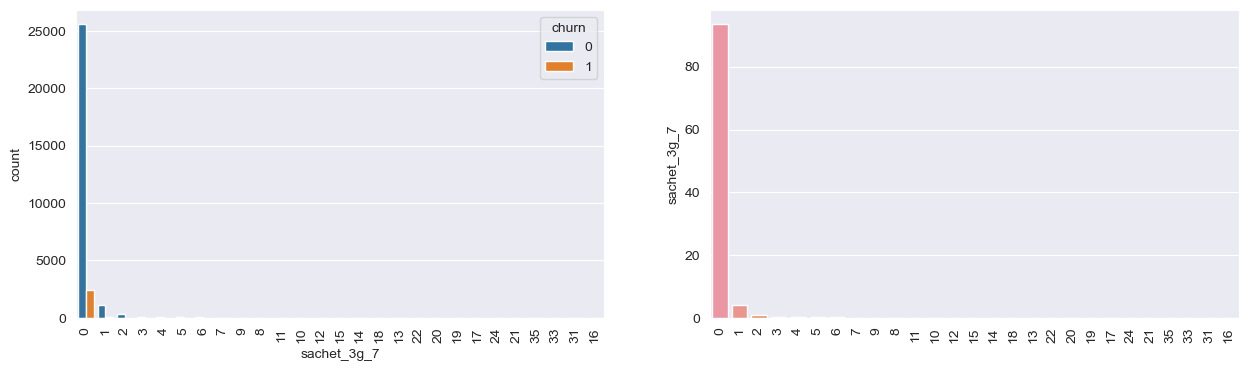

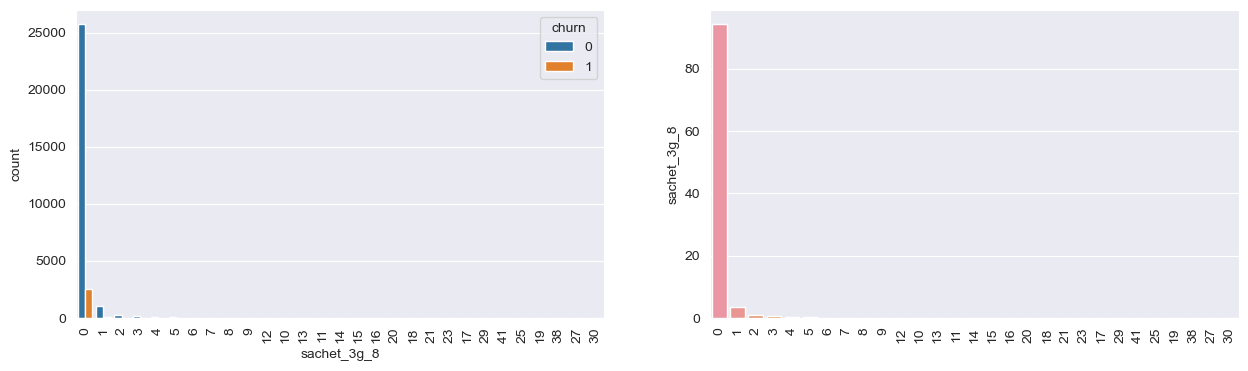

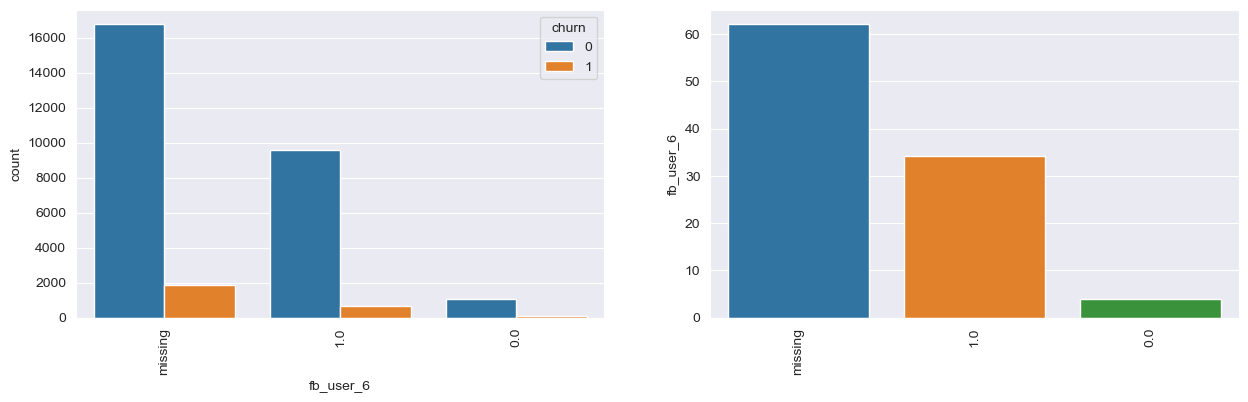

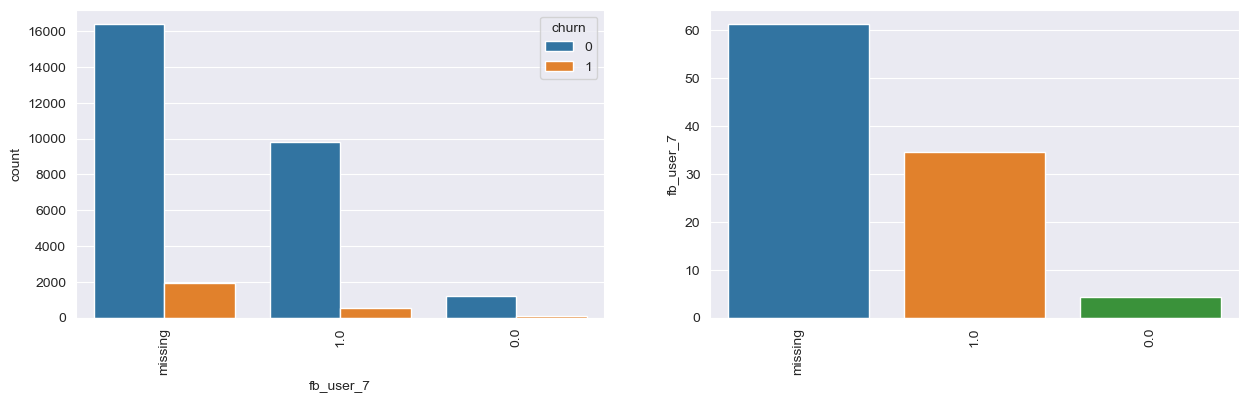

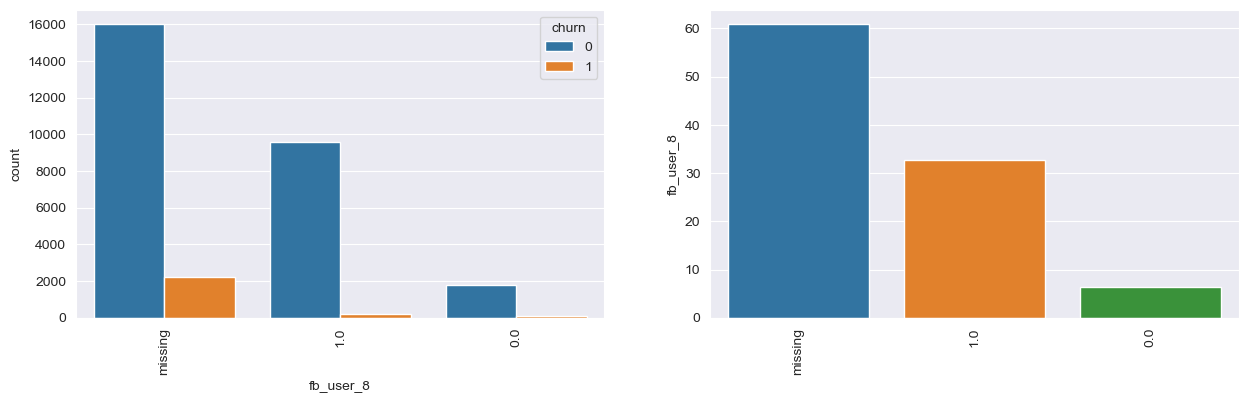

In [24]:
# plot categorical columns
plot_cat(cat_list)

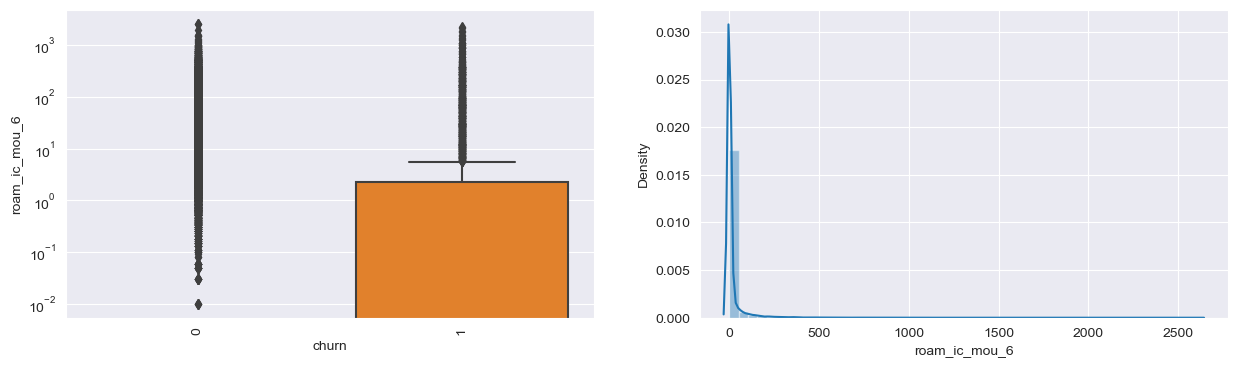

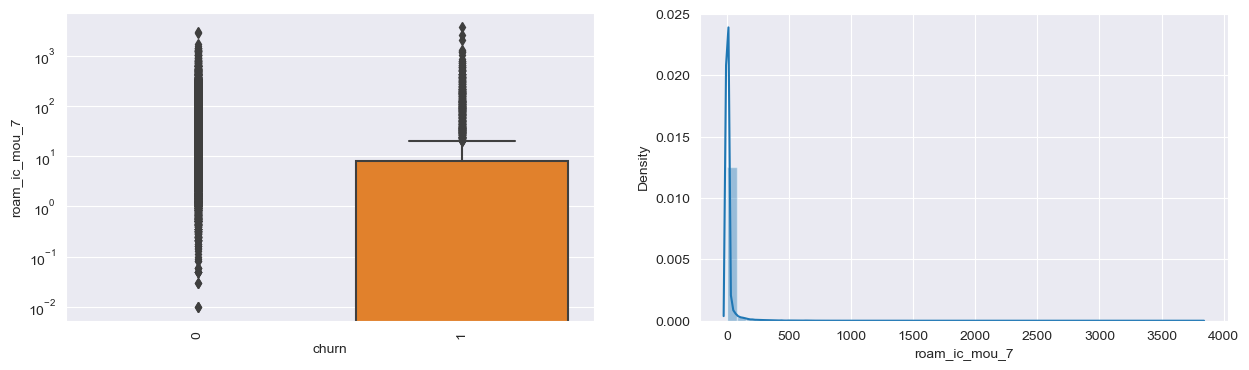

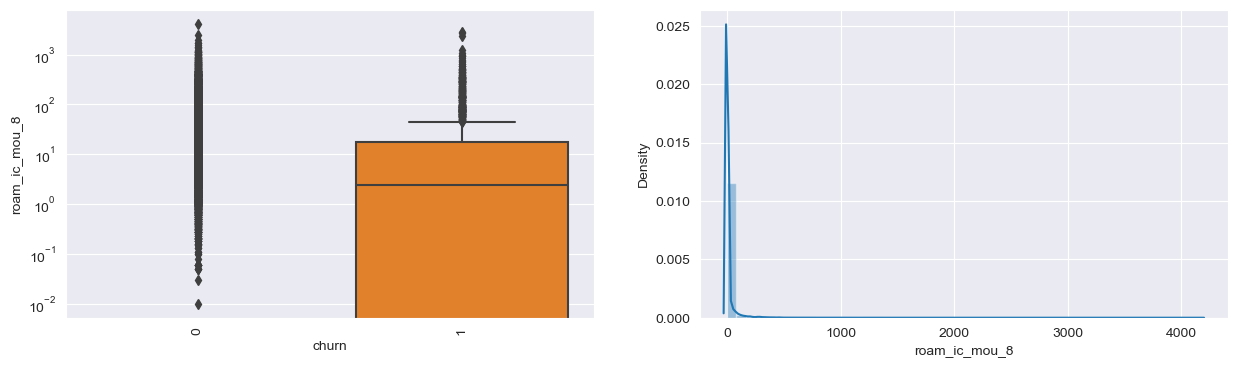

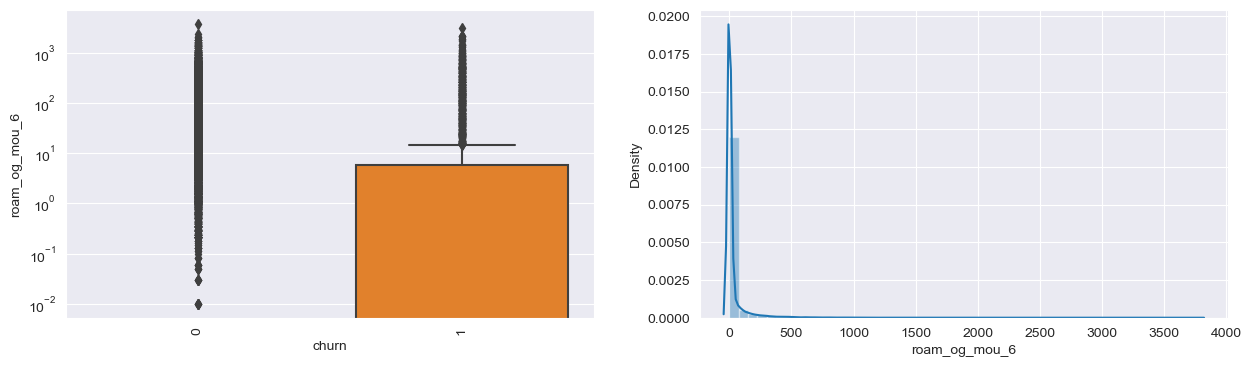

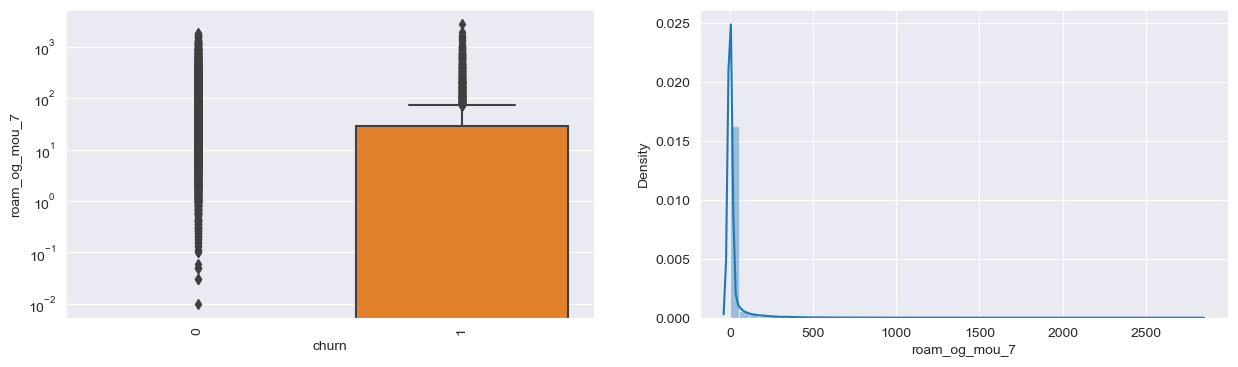

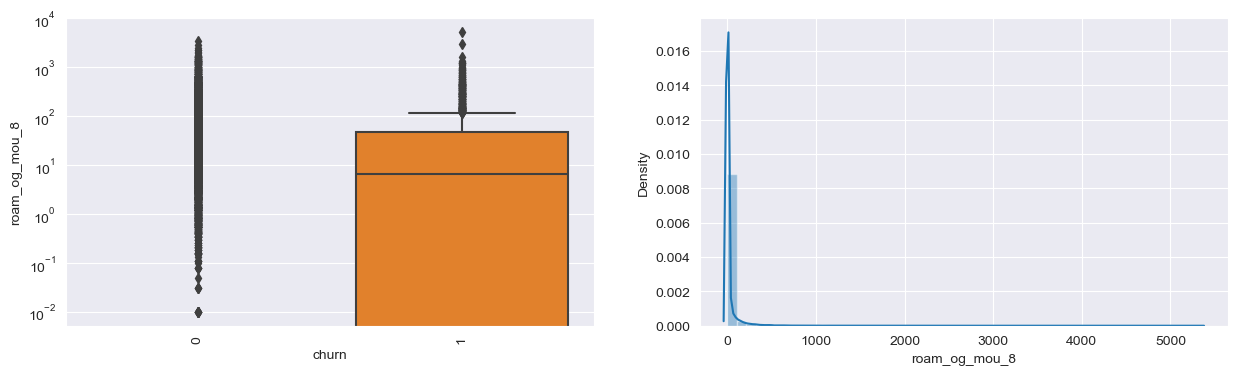

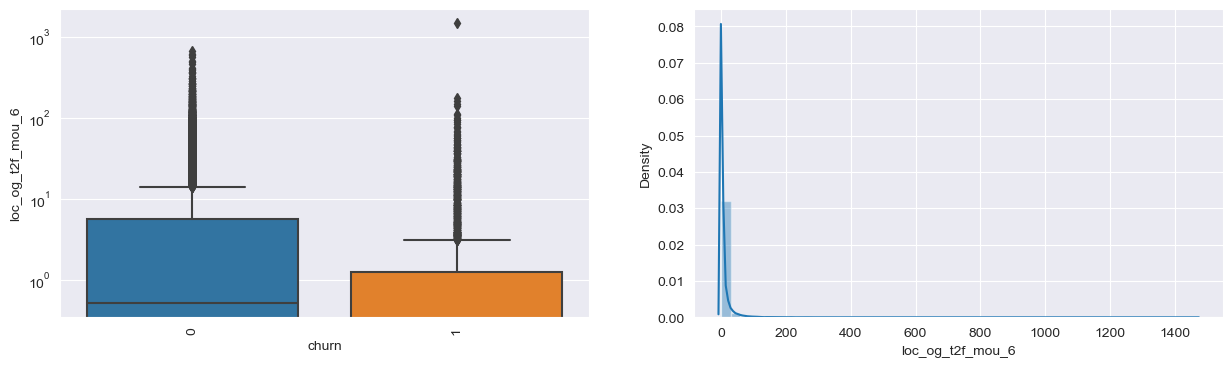

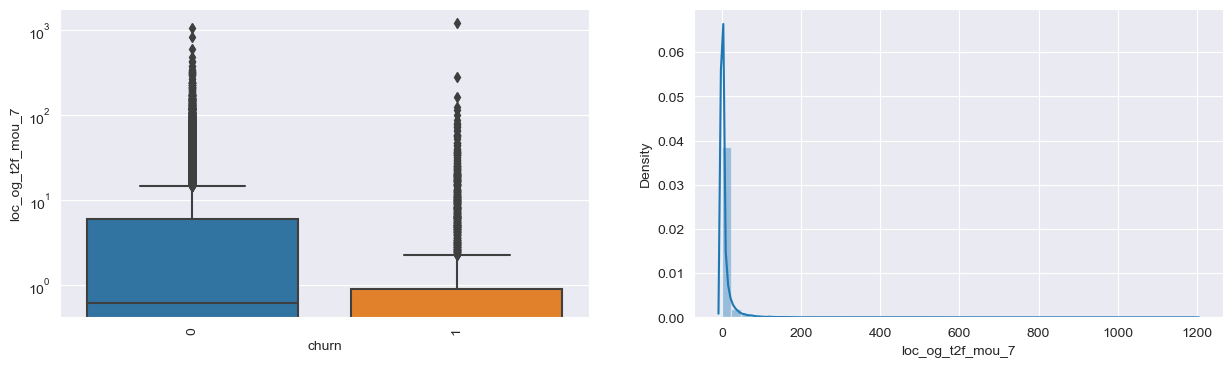

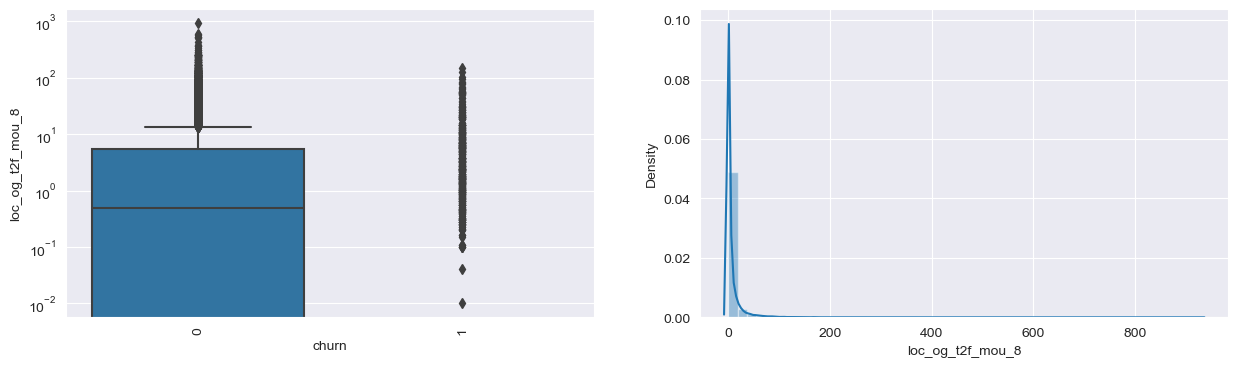

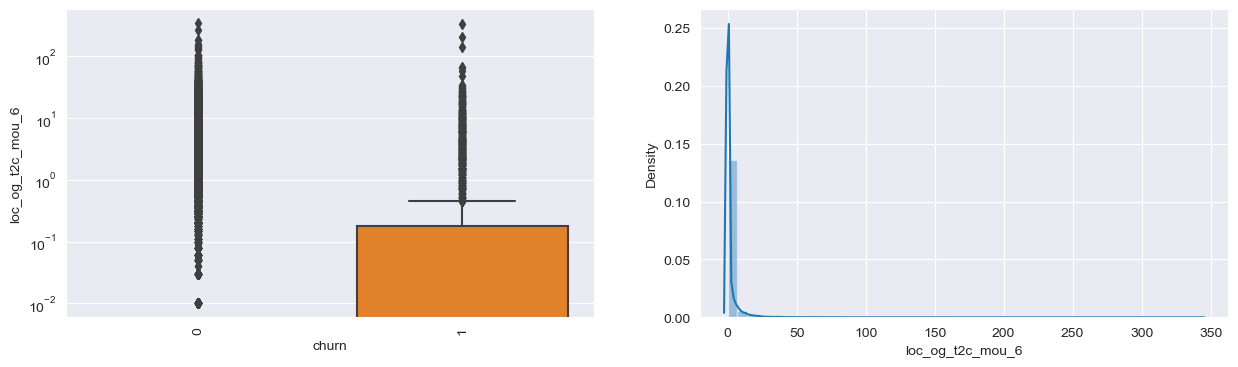

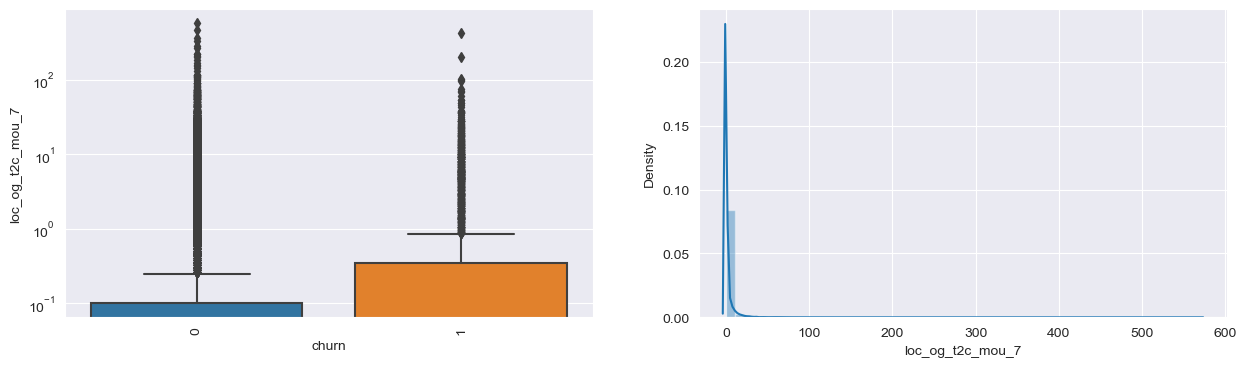

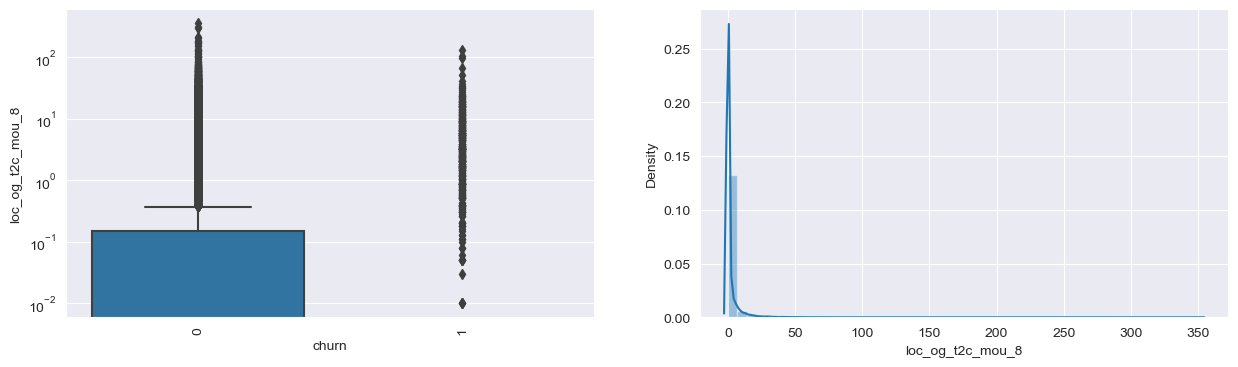

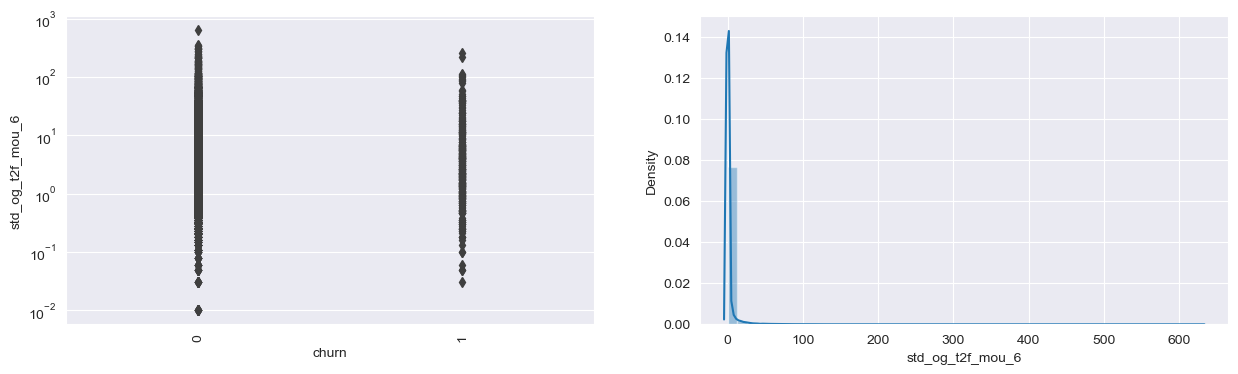

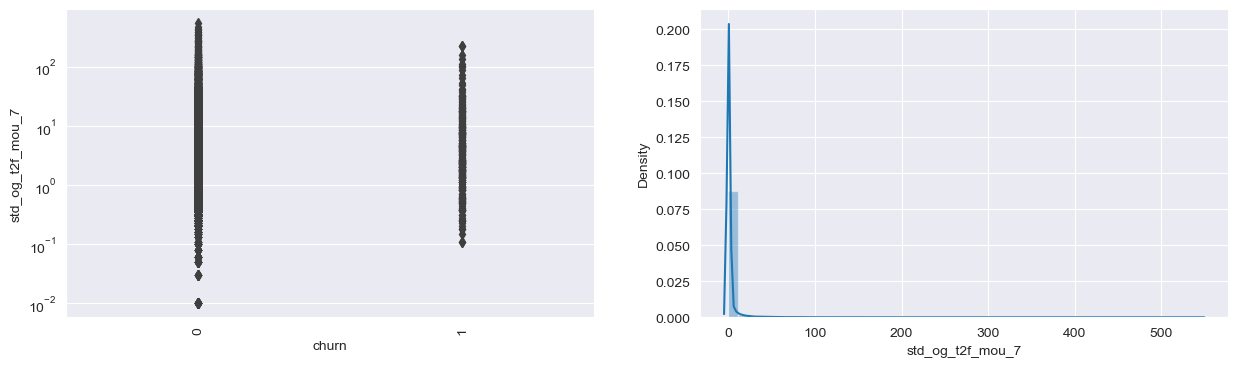

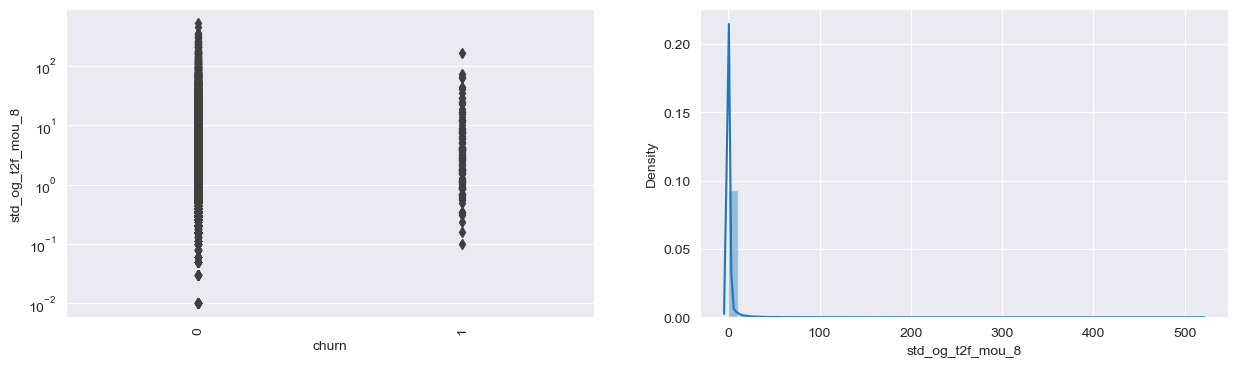

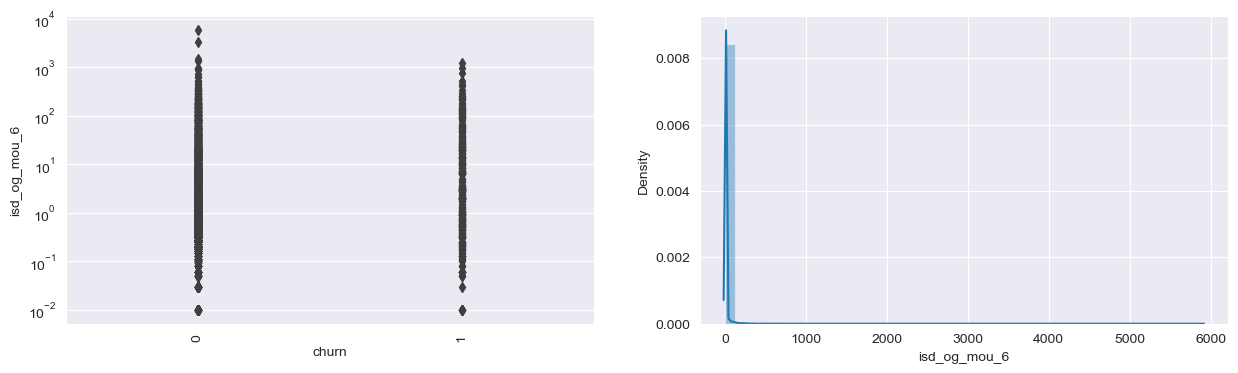

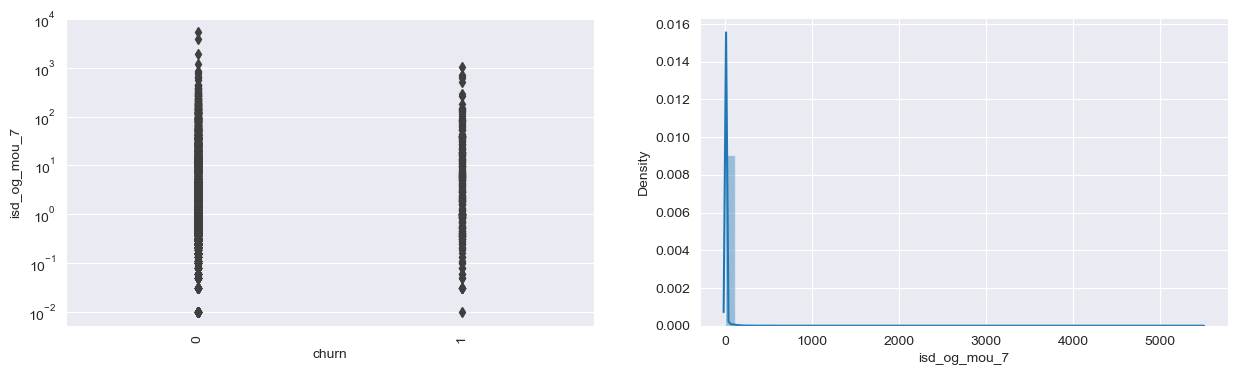

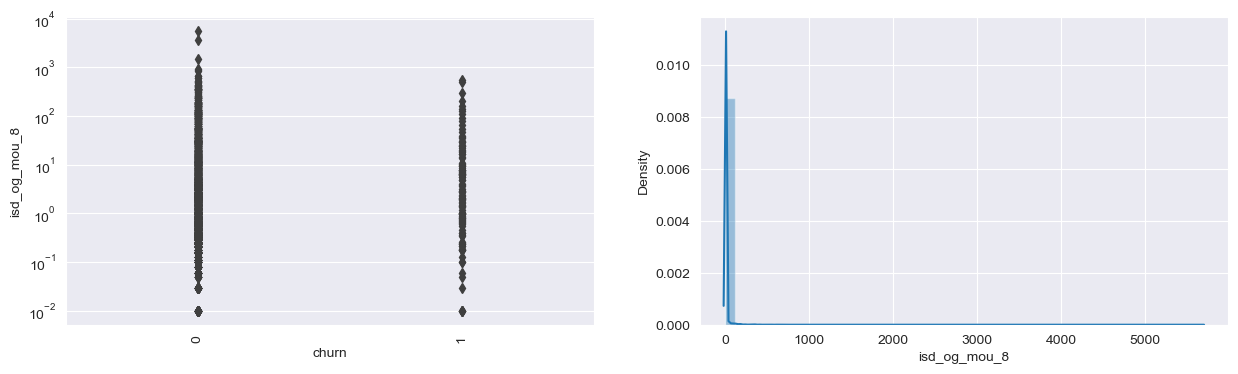

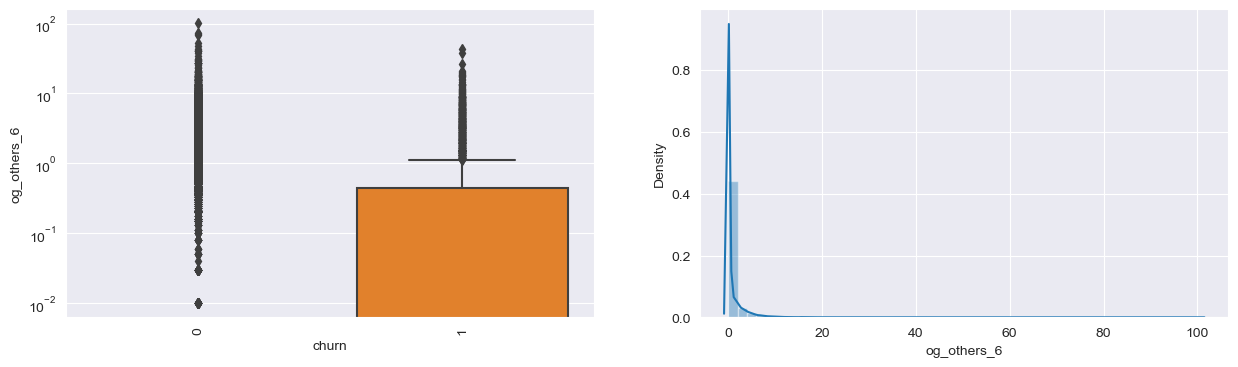

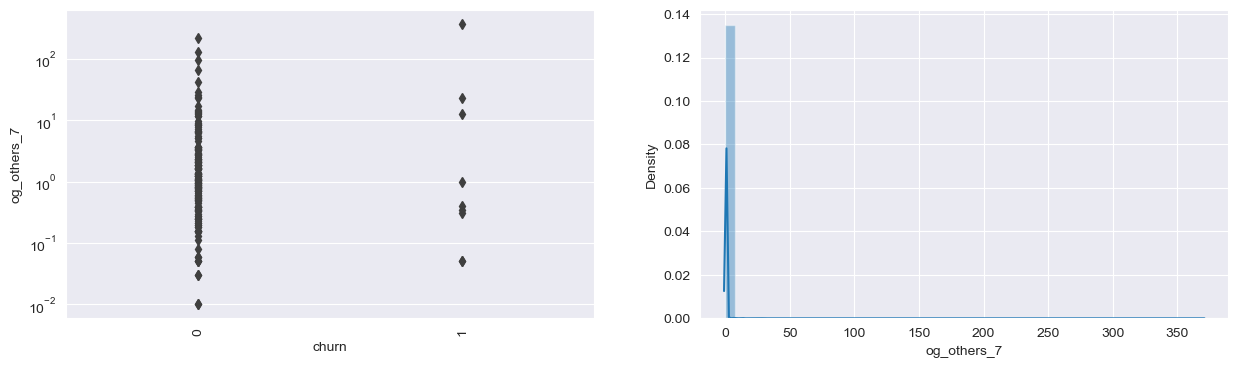

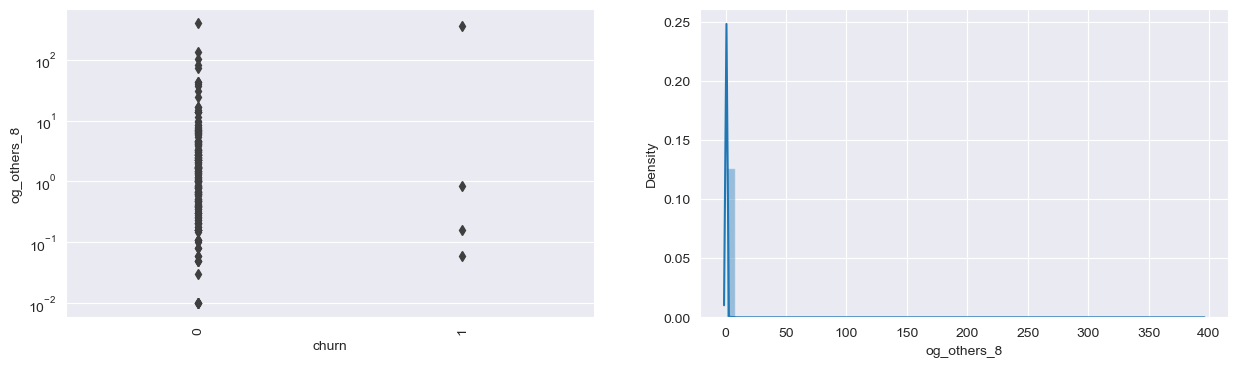

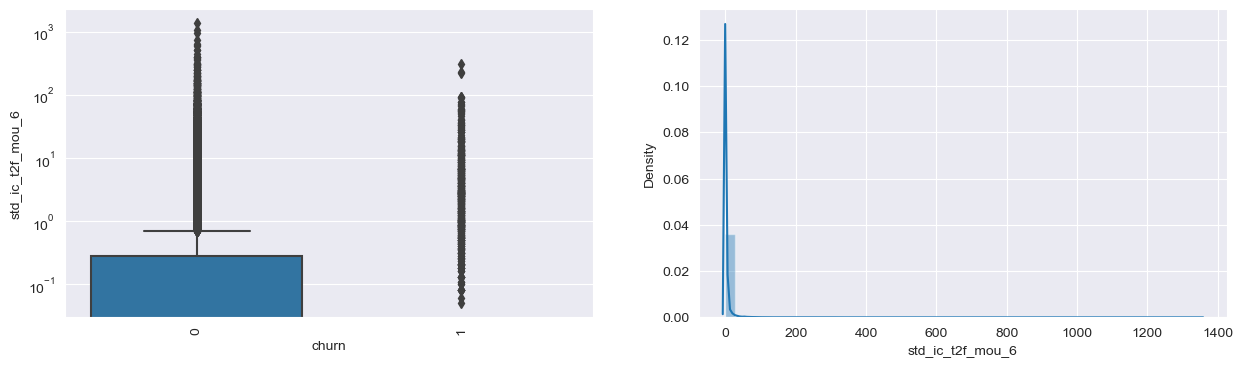

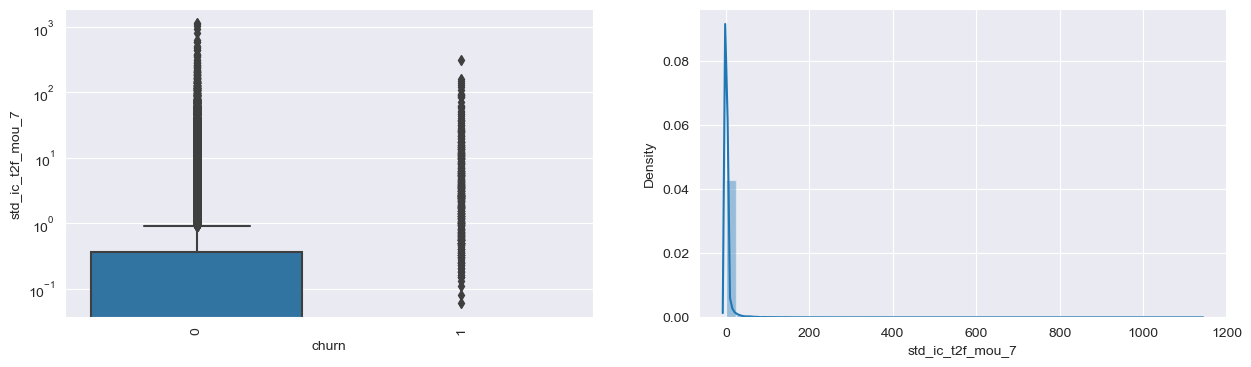

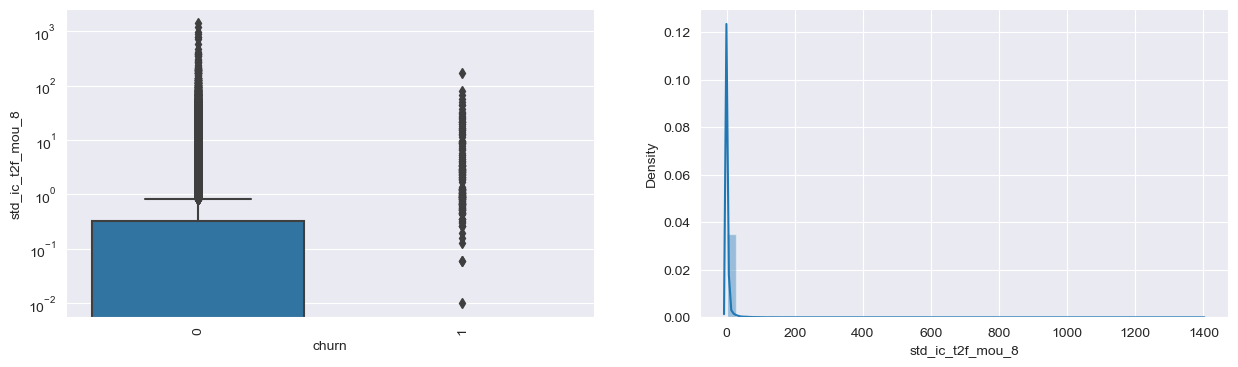

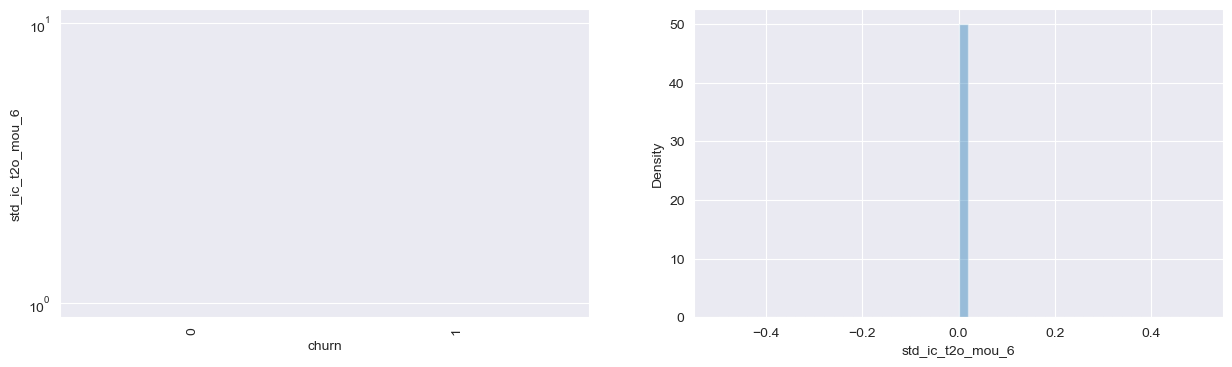

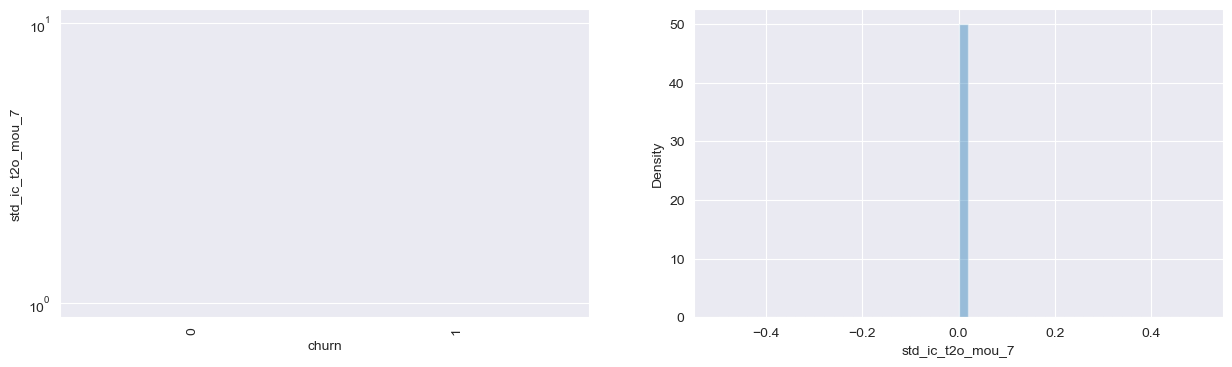

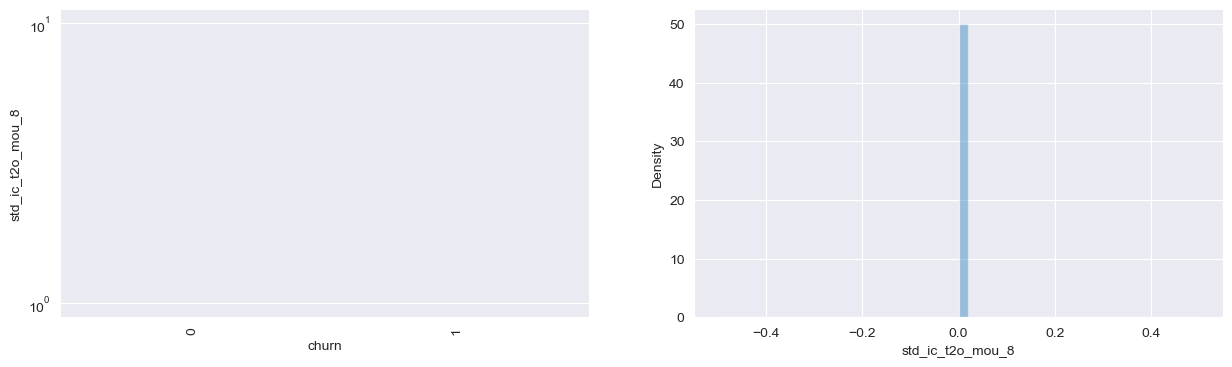

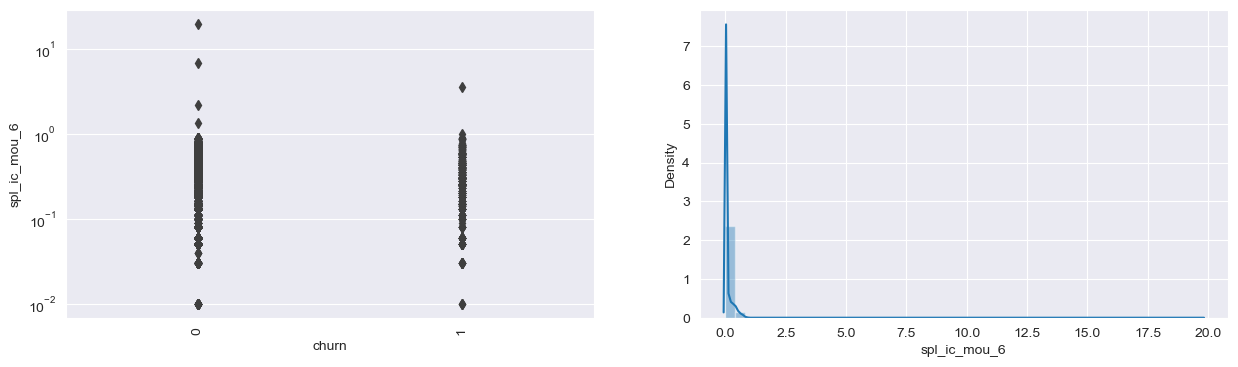

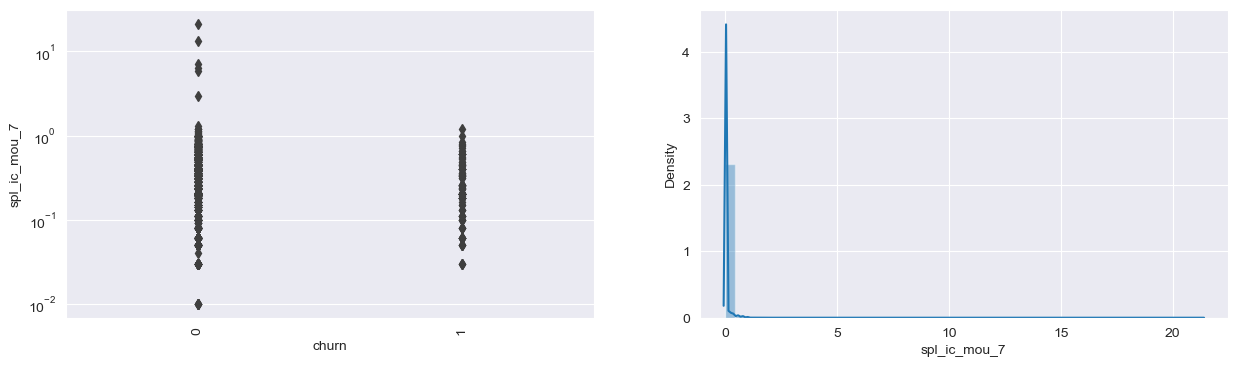

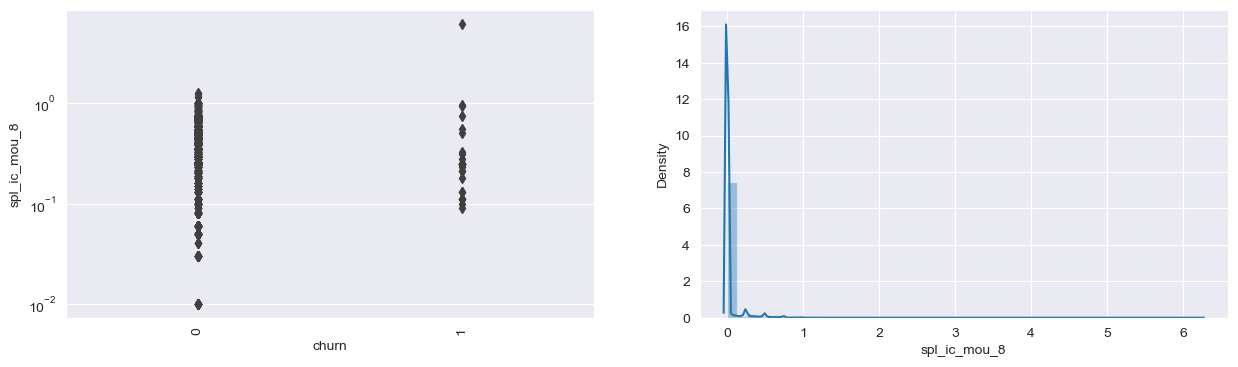

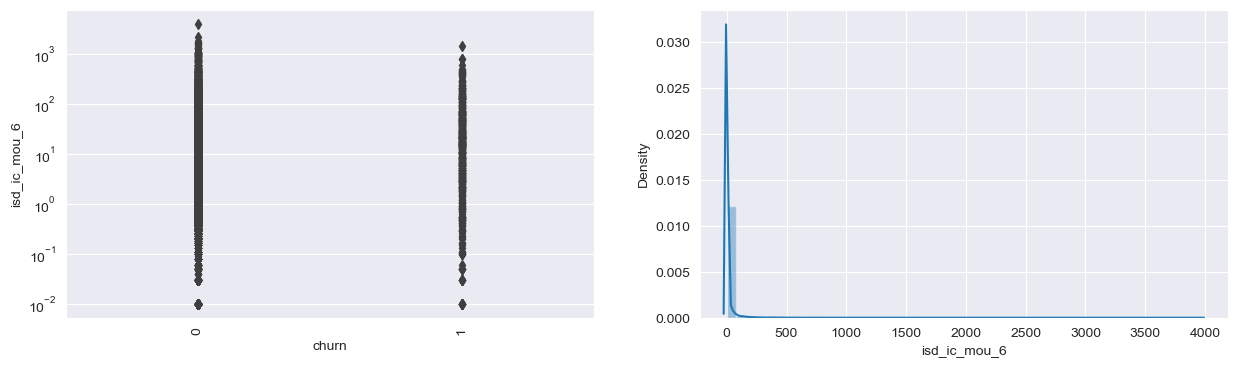

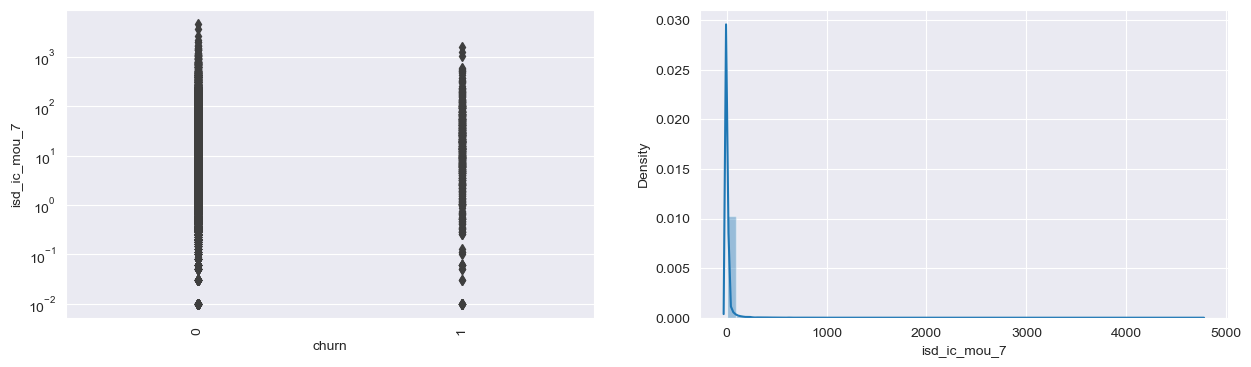

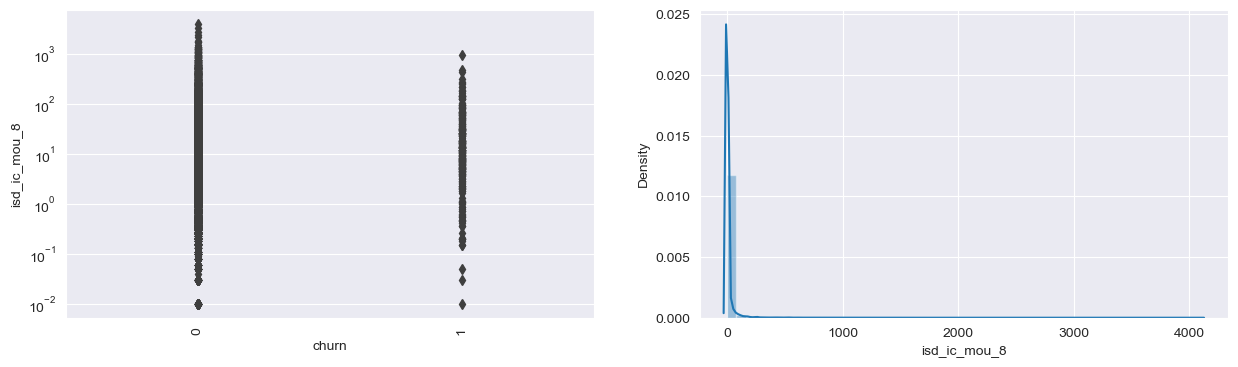

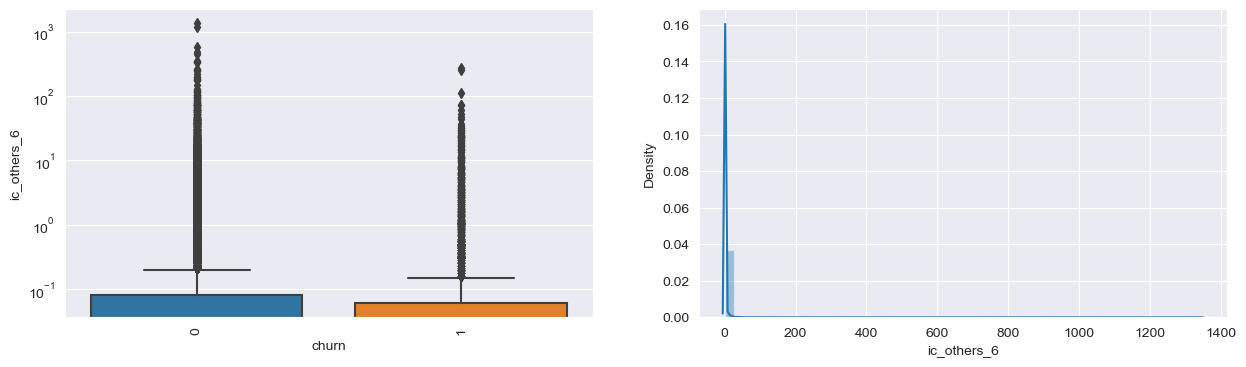

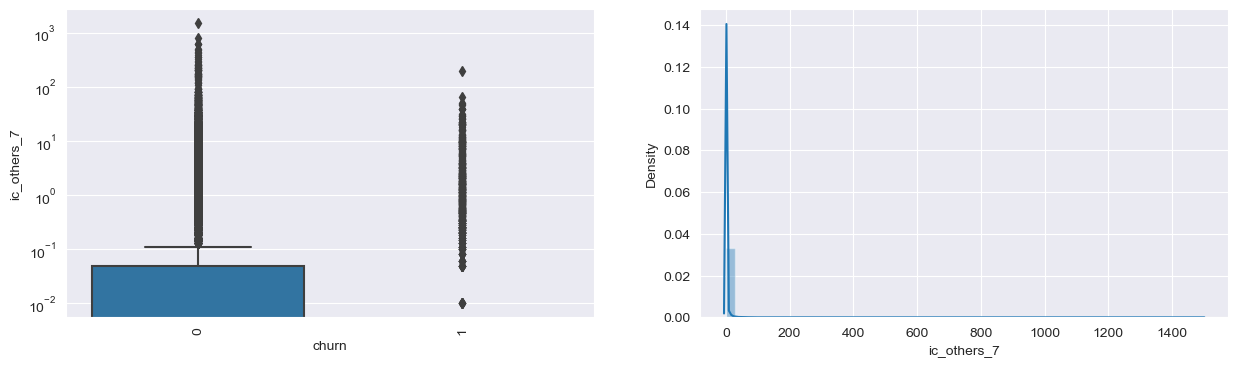

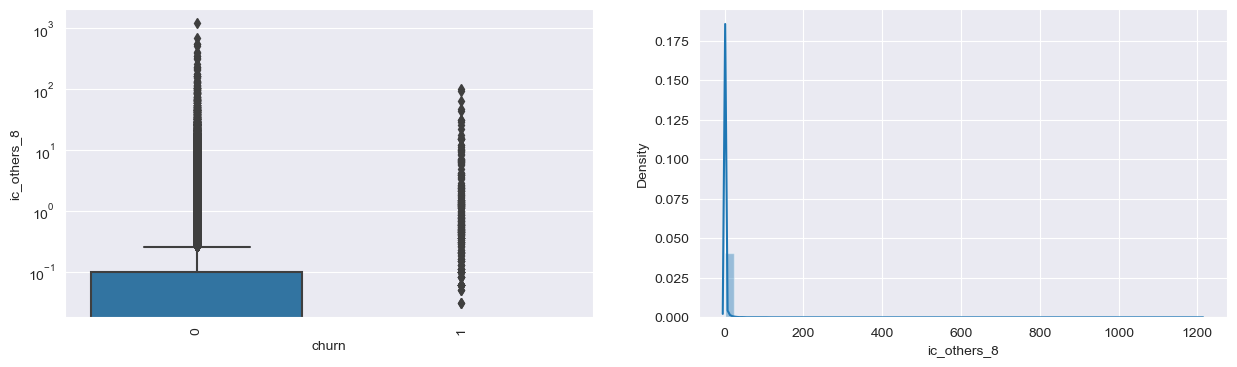

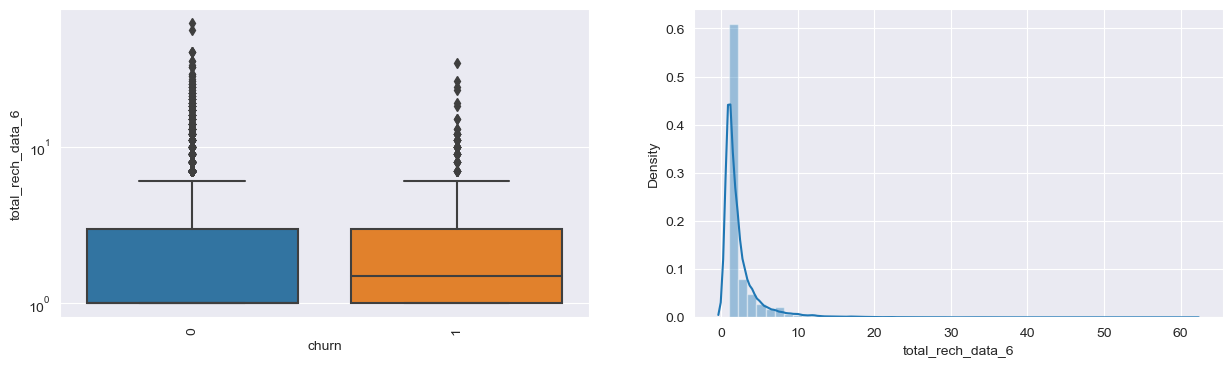

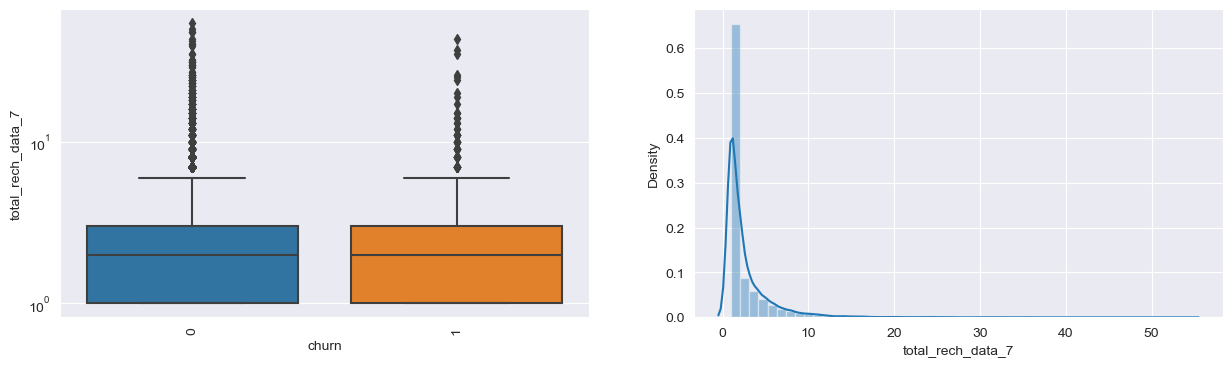

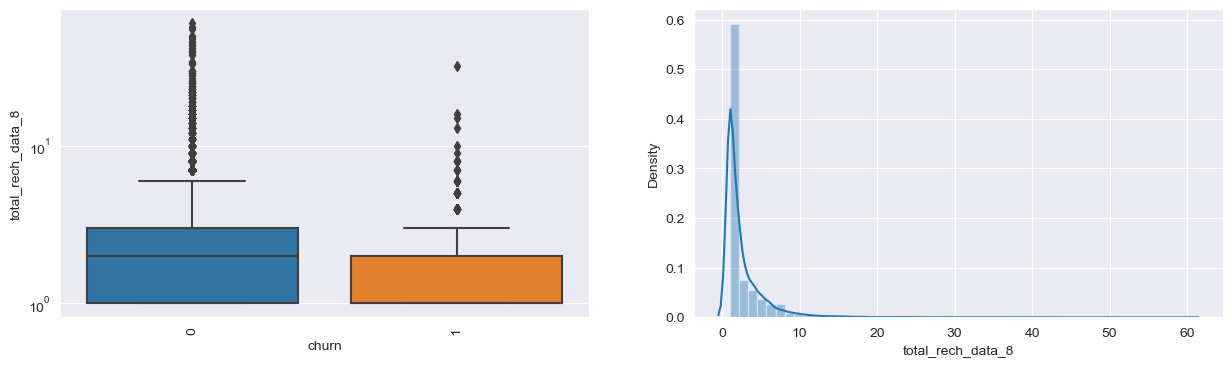

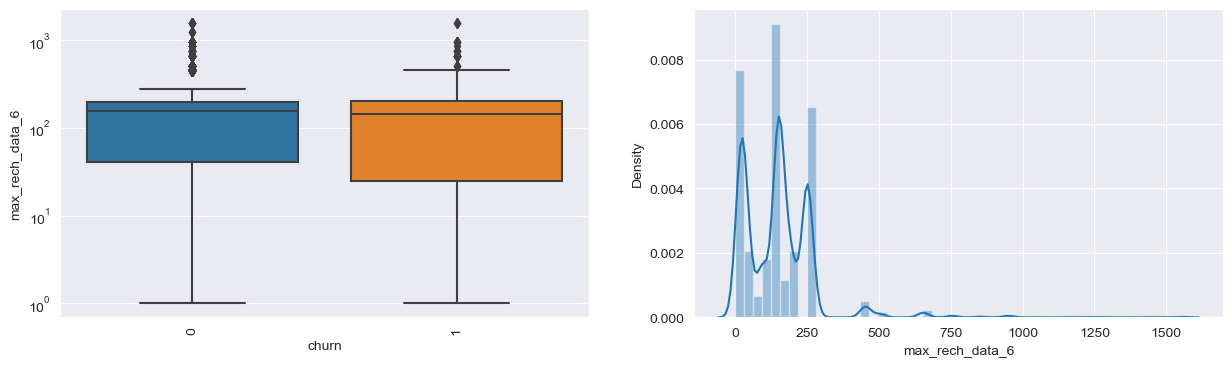

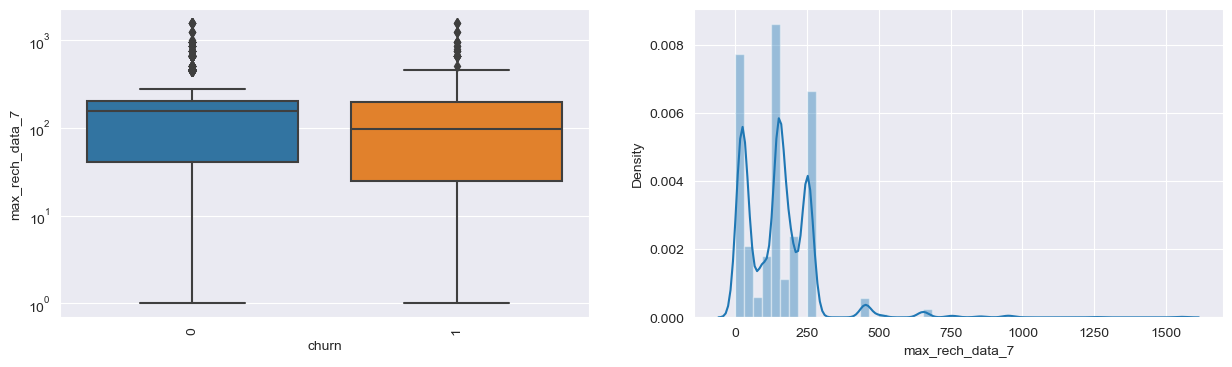

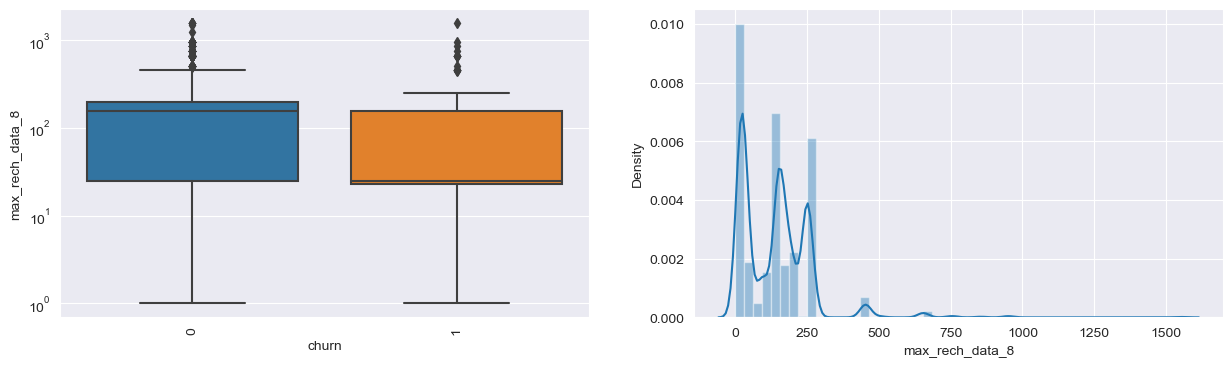

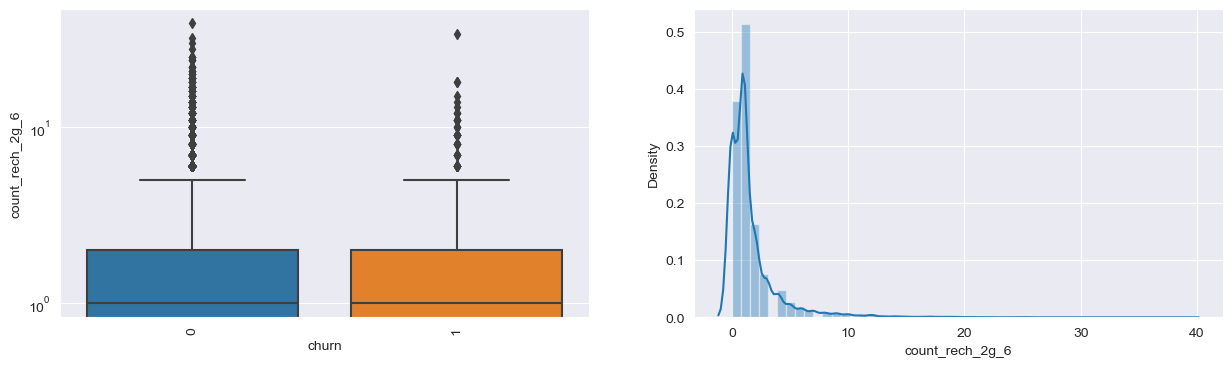

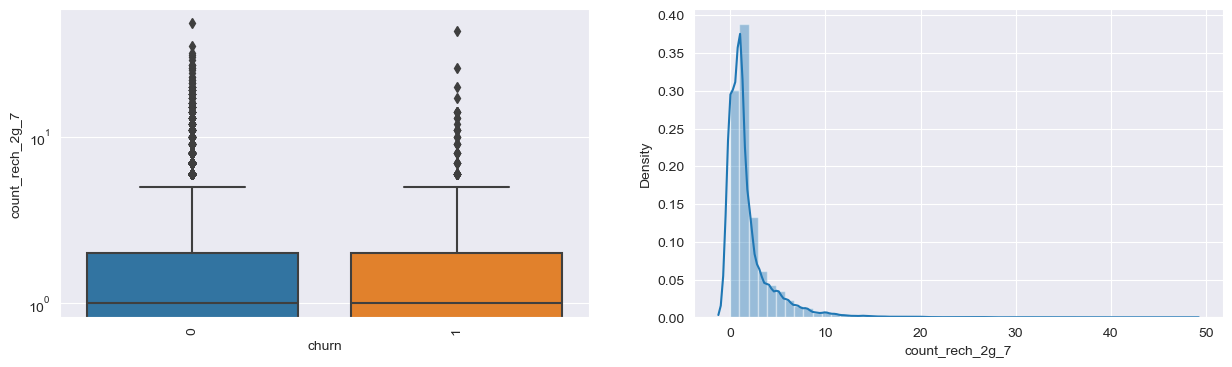

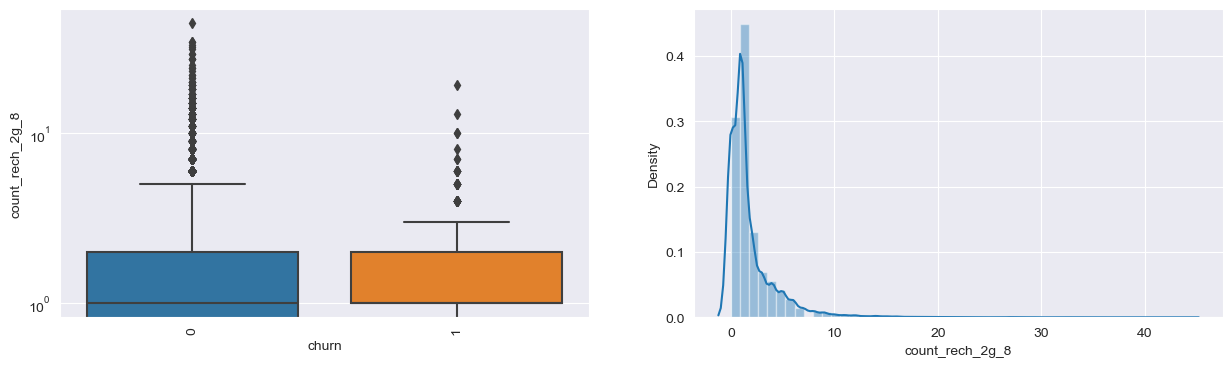

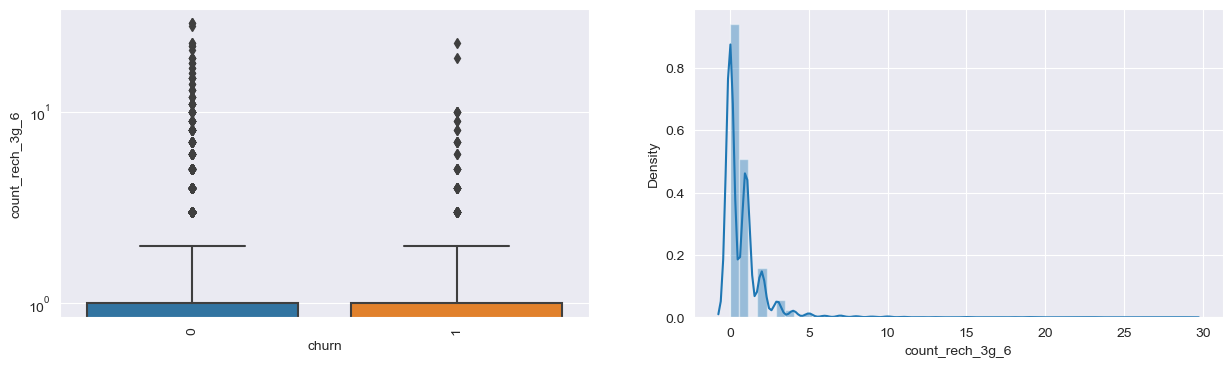

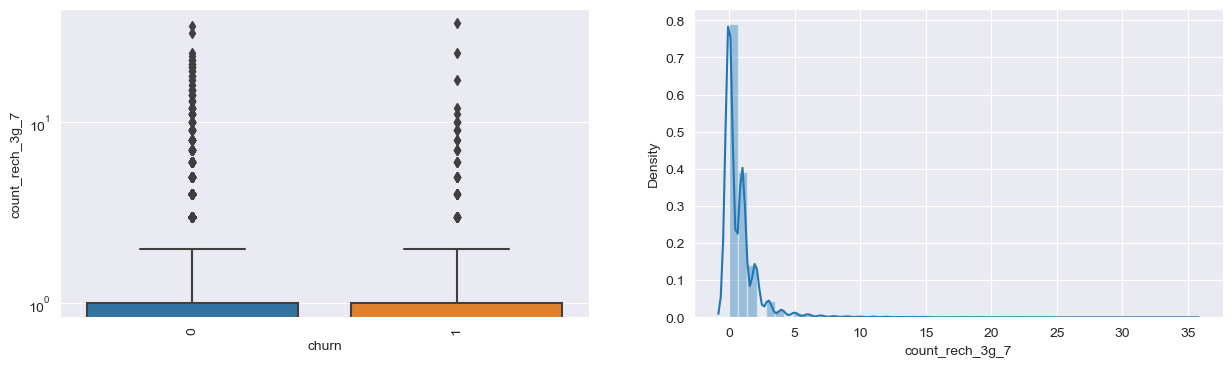

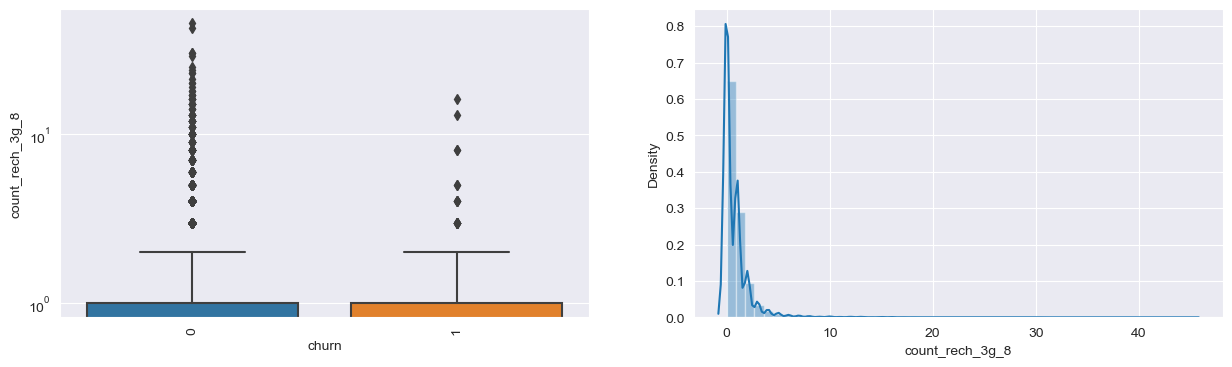

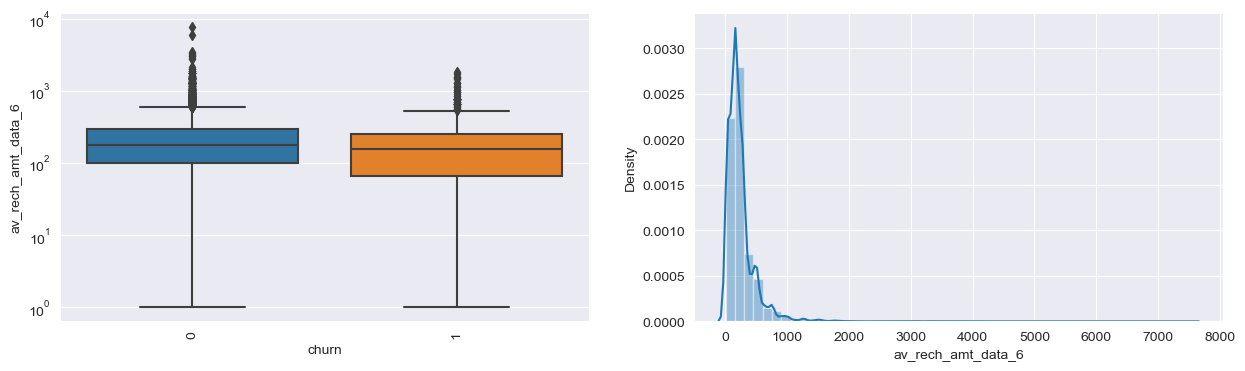

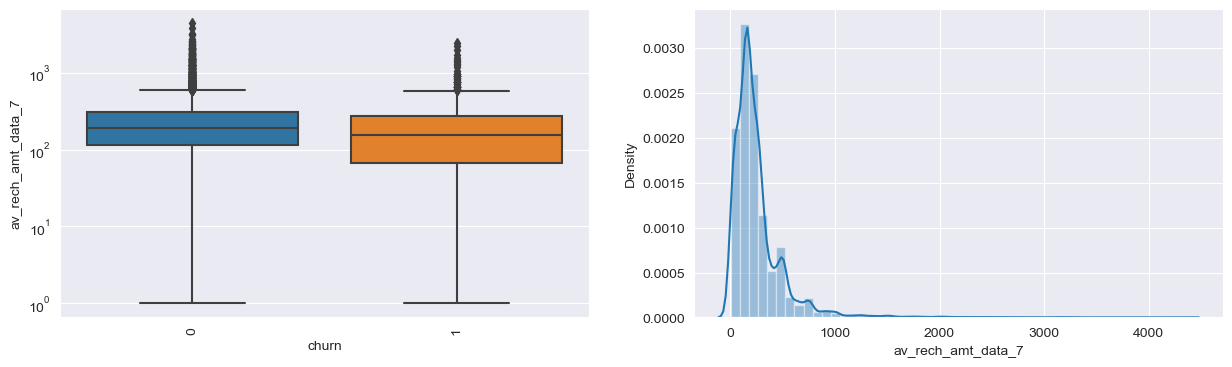

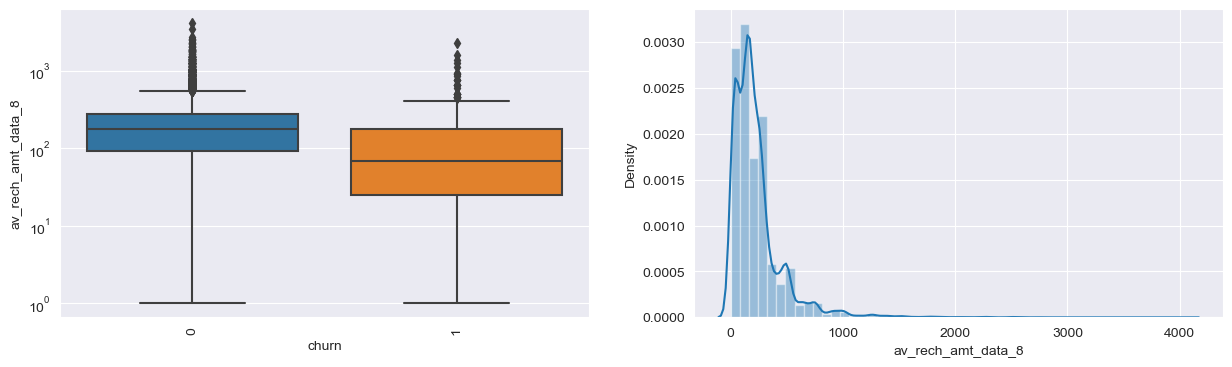

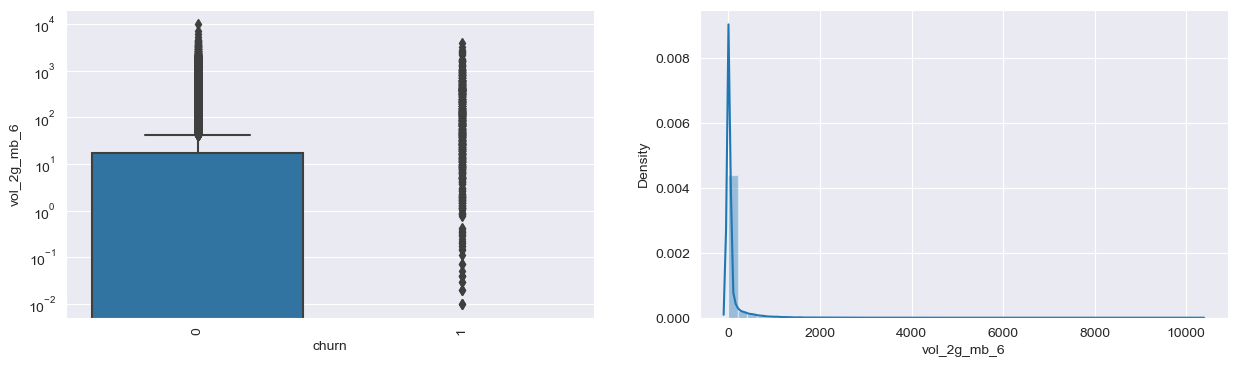

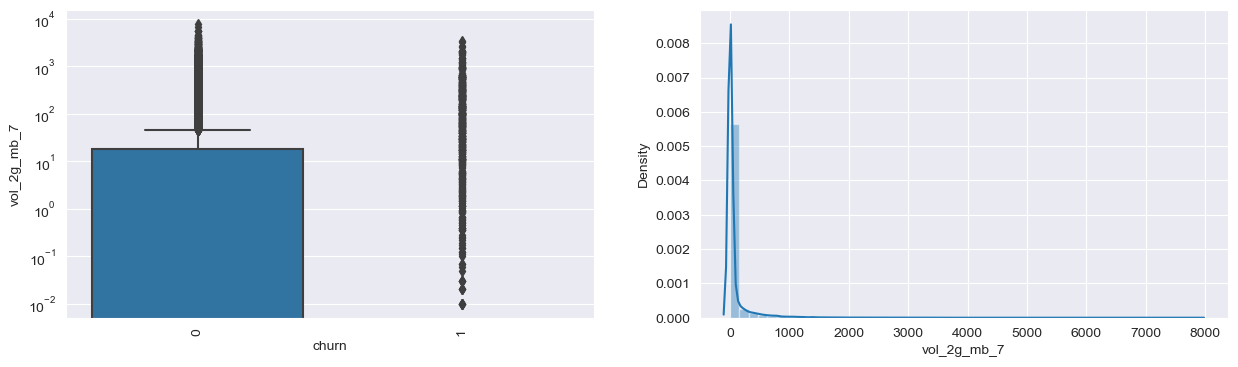

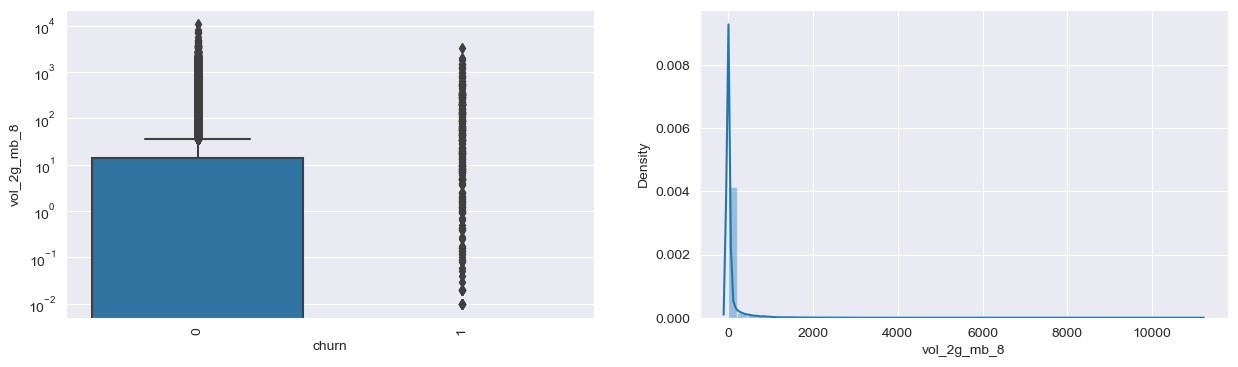

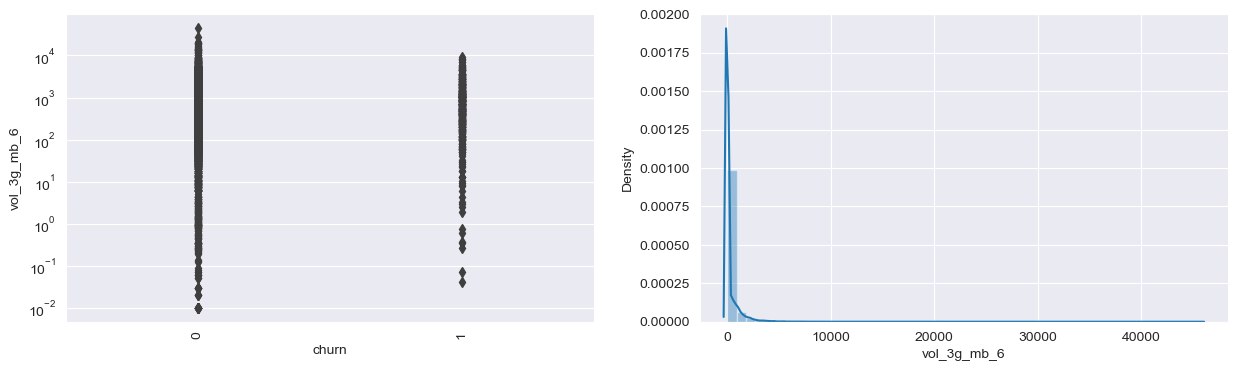

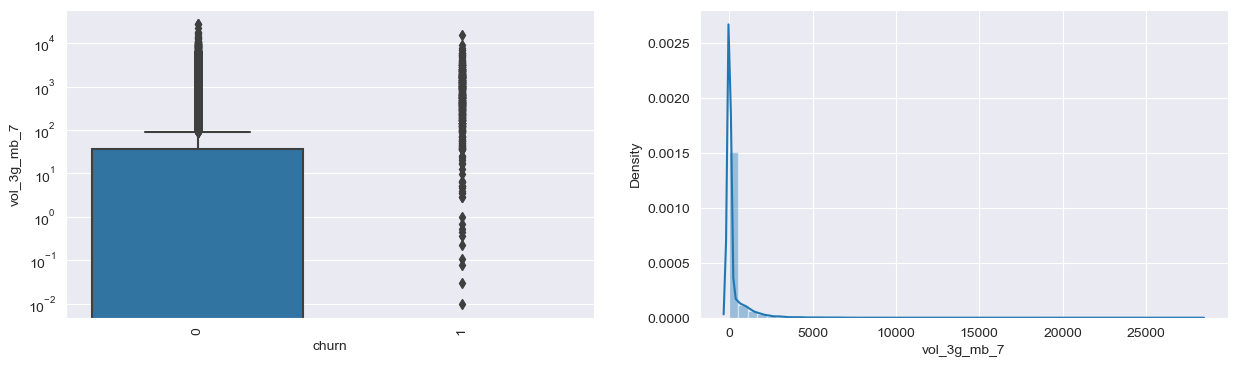

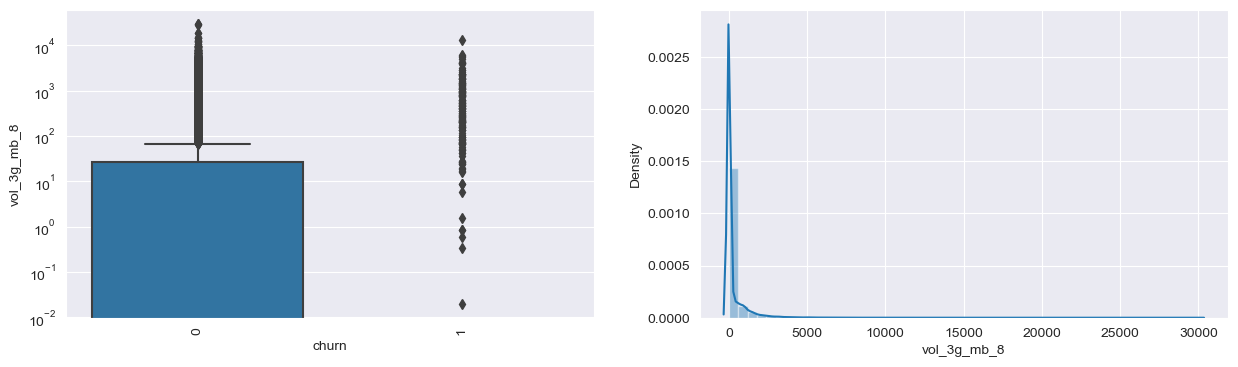

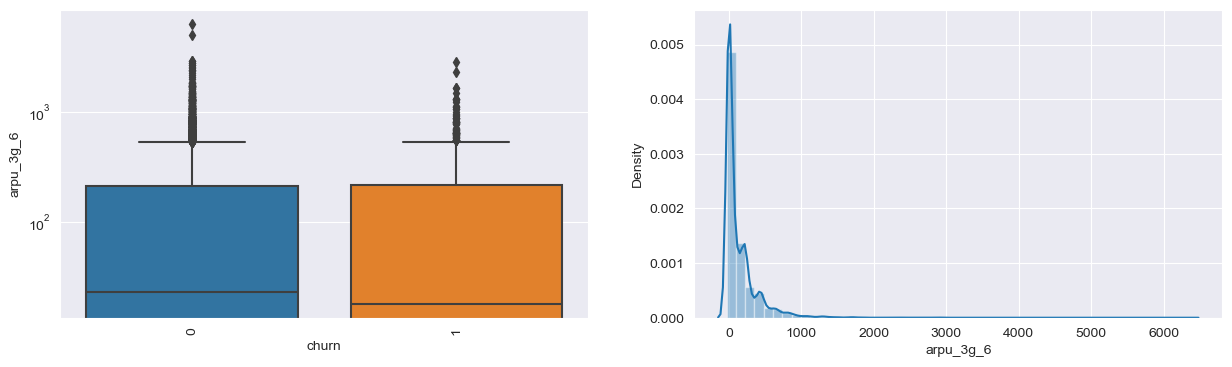

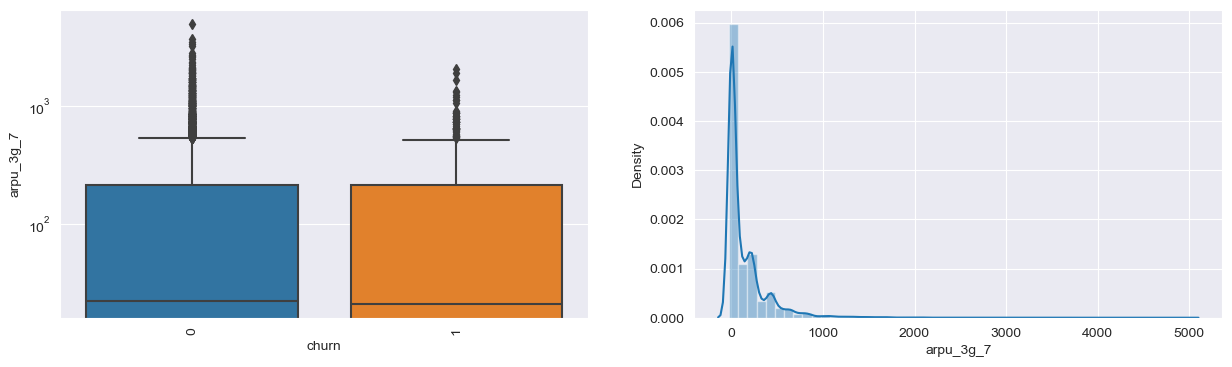

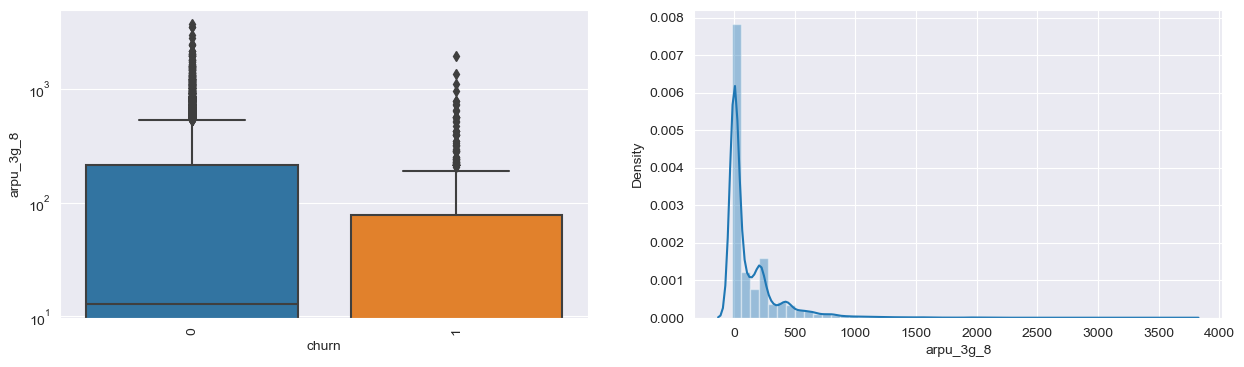

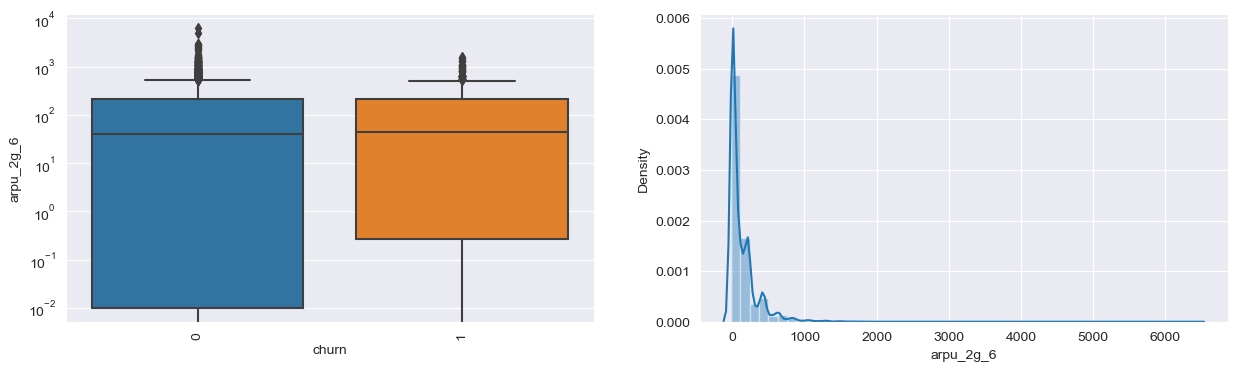

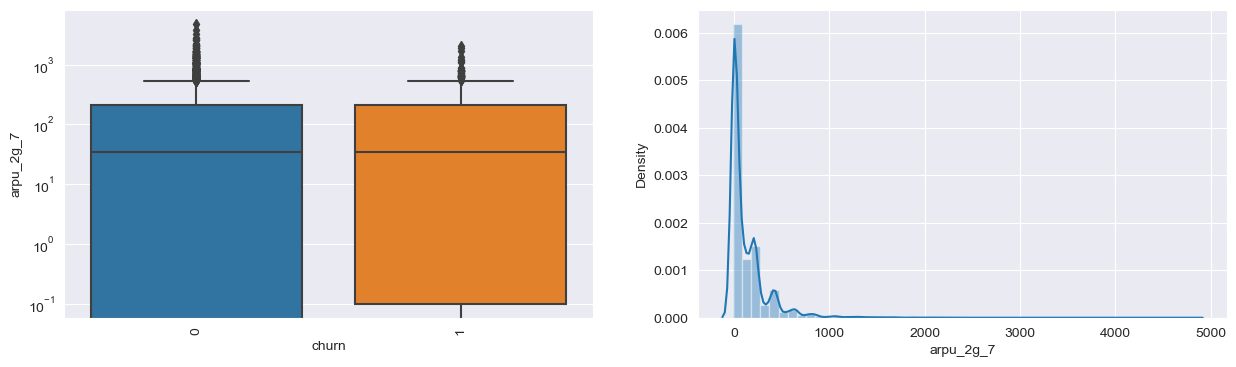

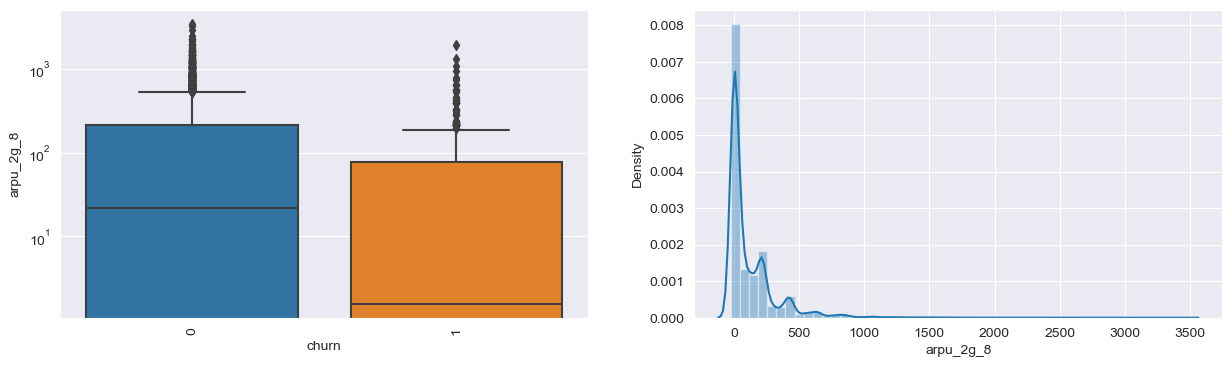

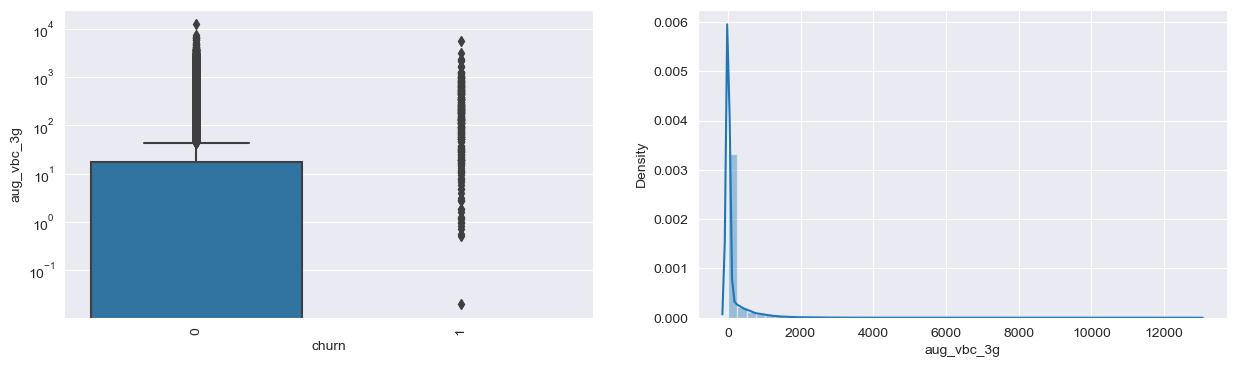

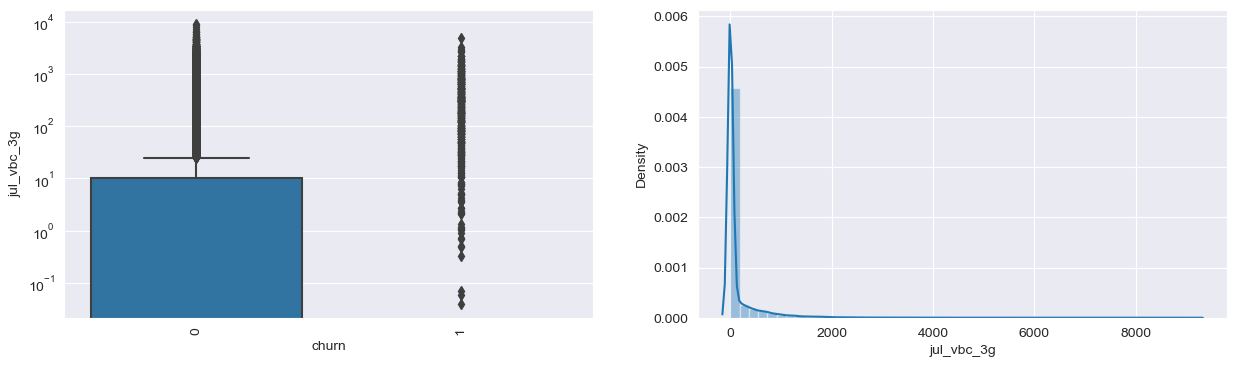

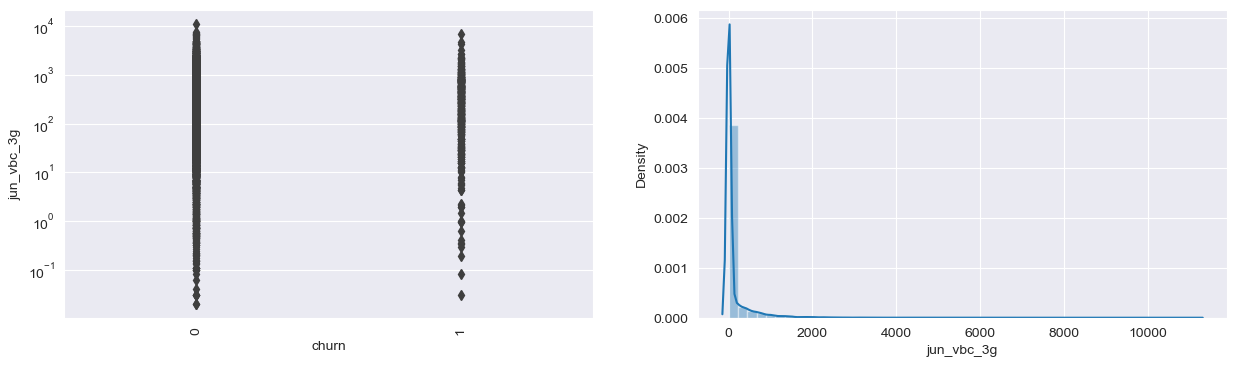

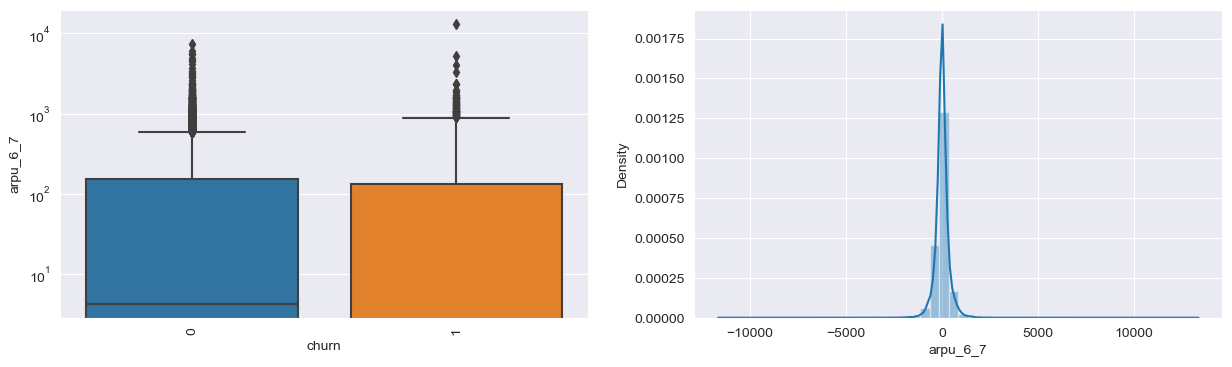

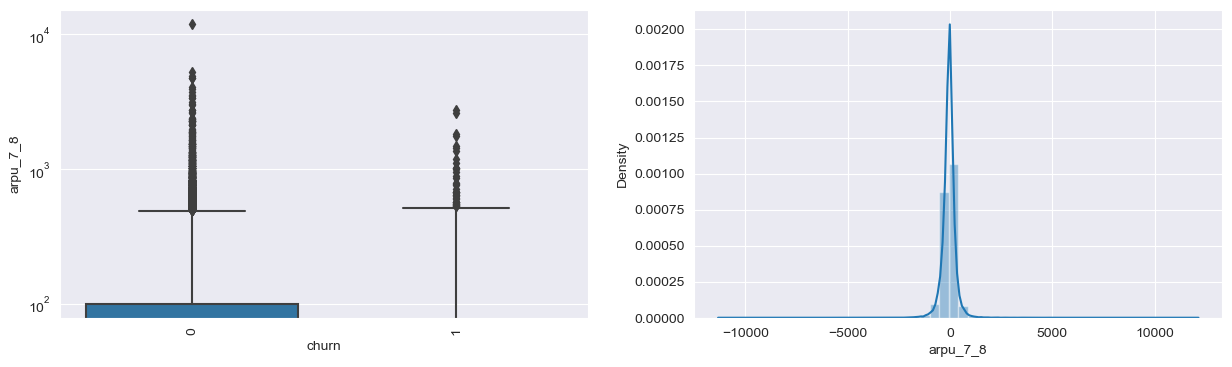

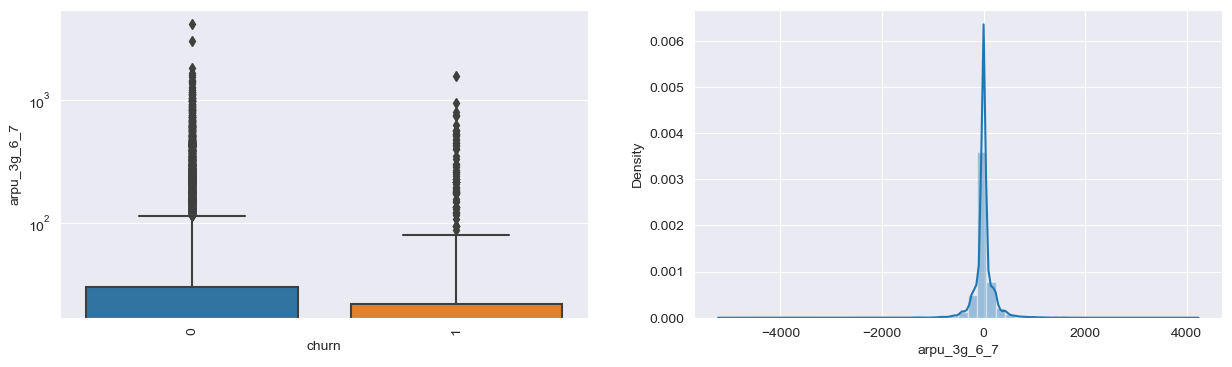

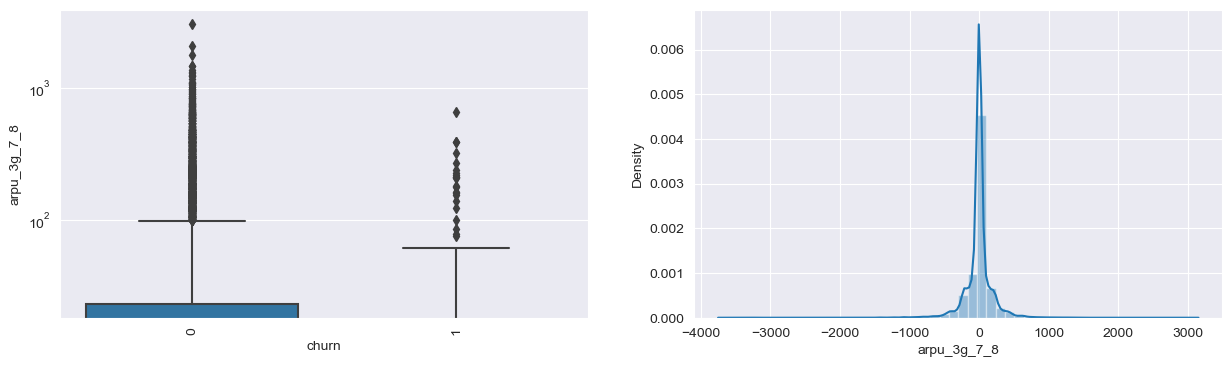

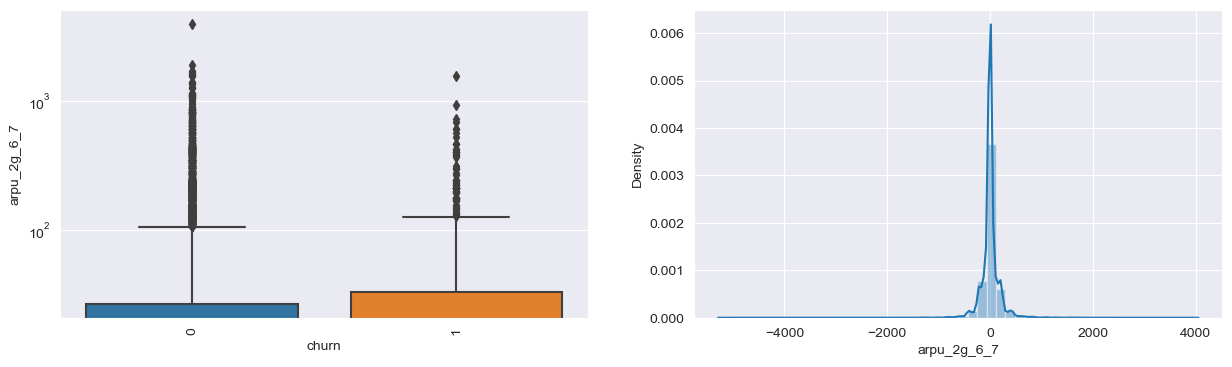

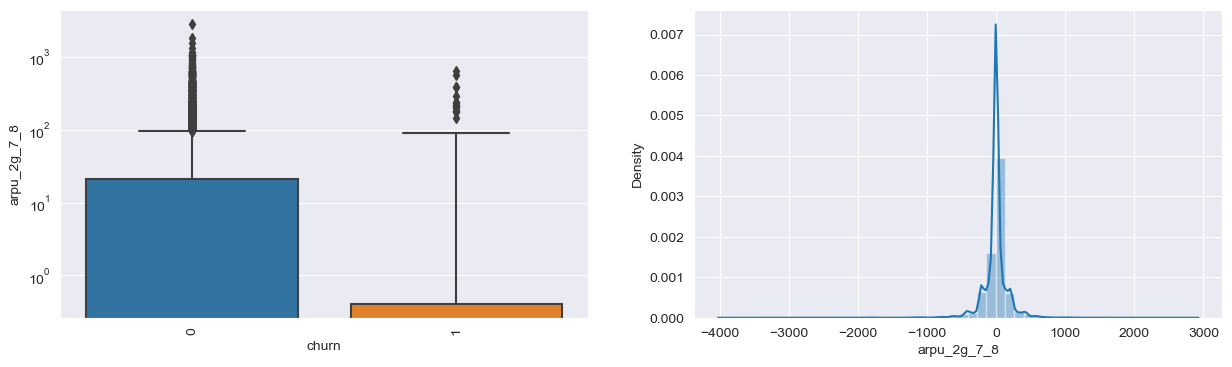

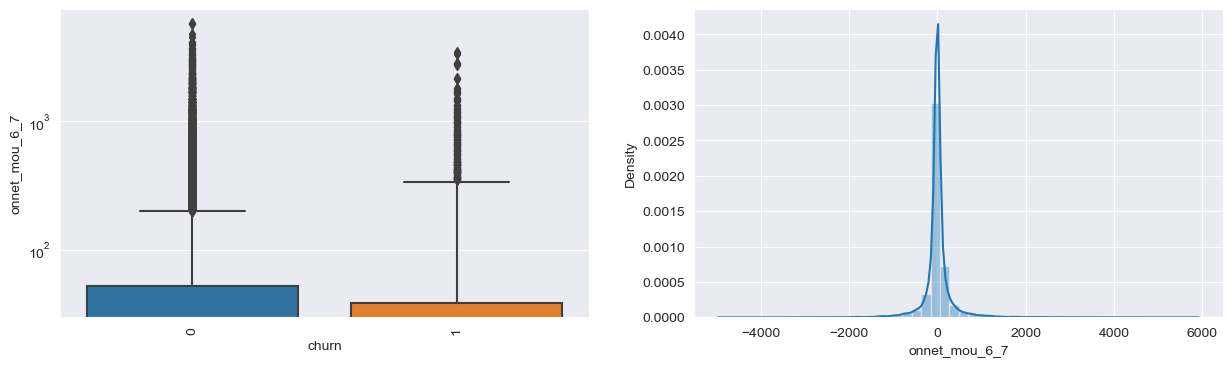

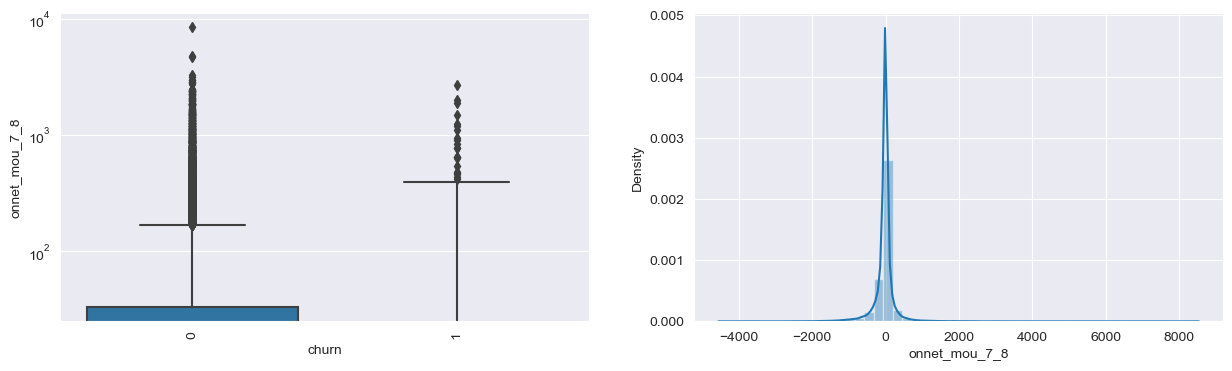

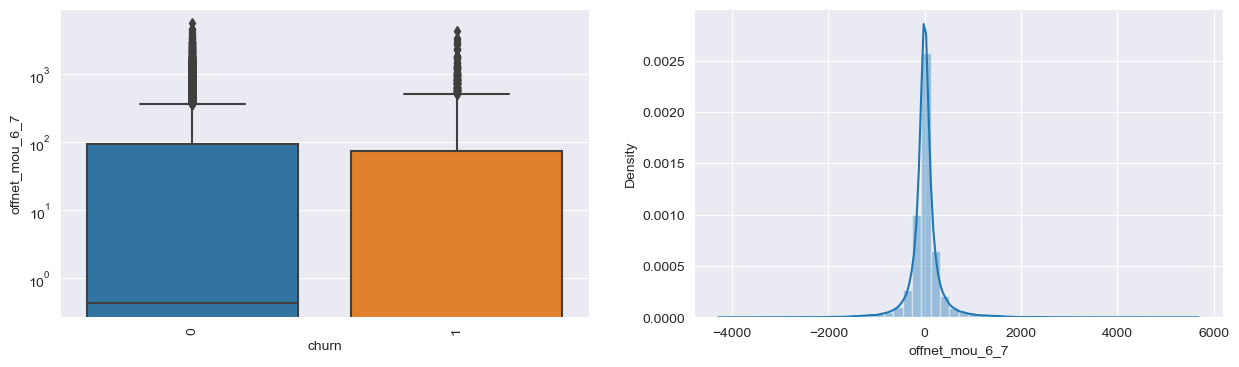

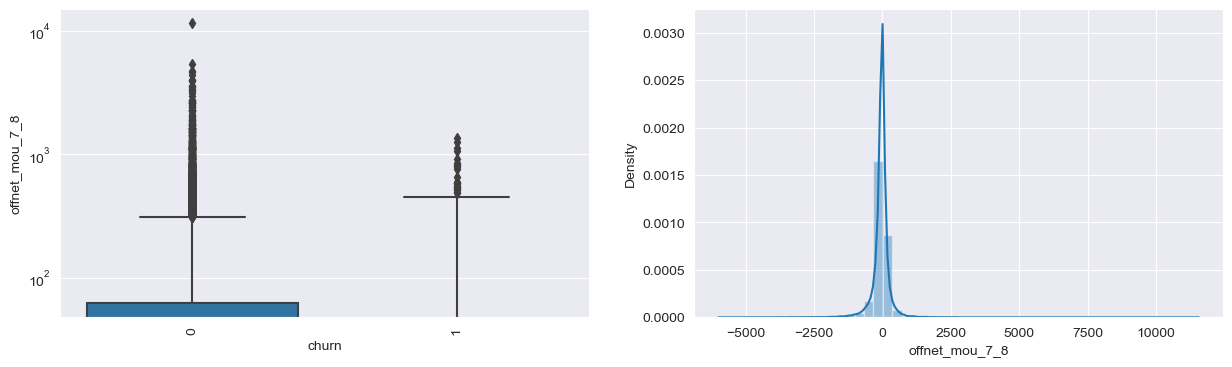

In [25]:
# plot numerical columns
plot_num(num_list, True)

In [26]:
# drop the unusable columns
drop_col(cat_list+num_list)

(29979, 77)

### Impute missing values in the relevant columns

In [27]:
# handling of columns which show correlation with churn data

In [28]:
col_list = ['arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8',
            'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
            'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
            'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_mou_6','std_og_mou_7','std_og_mou_8',
            'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','total_og_mou_6','total_og_mou_7','total_og_mou_8','loc_ic_t2t_mou_6',
            'loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6',
            'loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','std_ic_t2t_mou_6',
            'std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
            'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_rech_num_6',
            'total_rech_num_7','total_rech_num_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','max_rech_amt_6',
            'max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8','aon']

In [29]:
len(col_list)

70

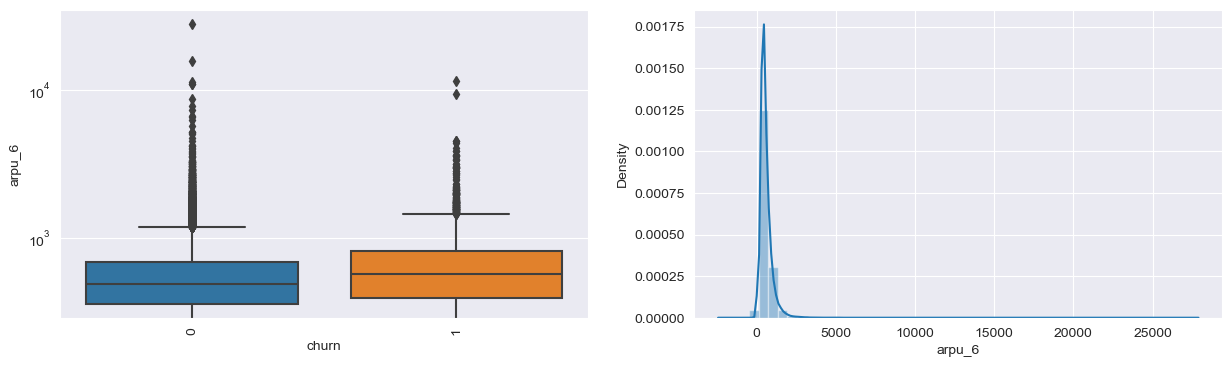

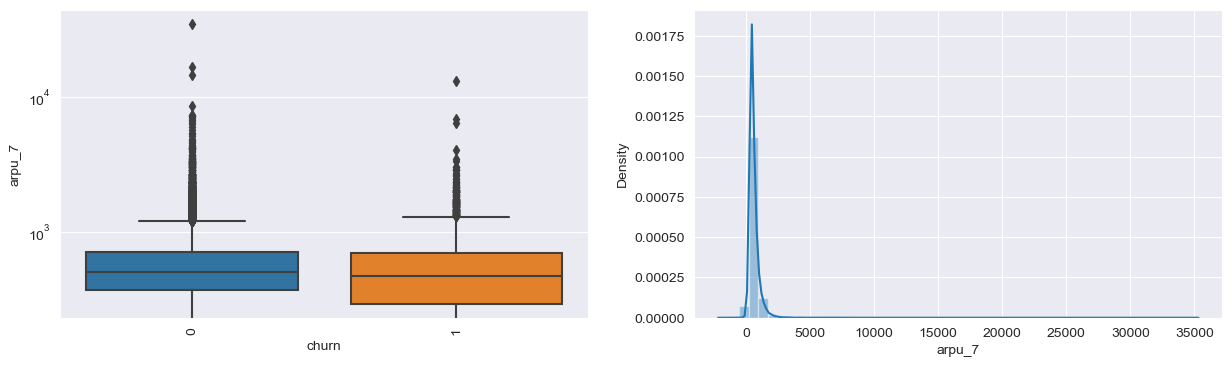

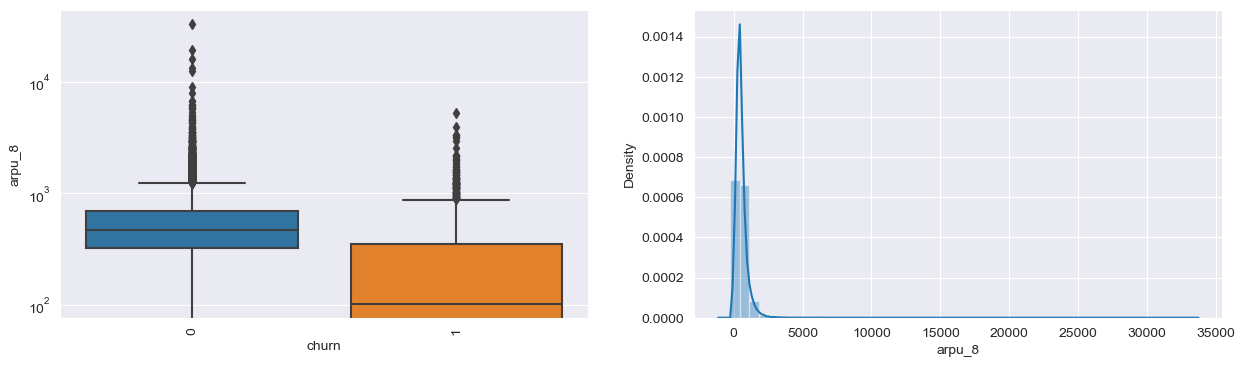

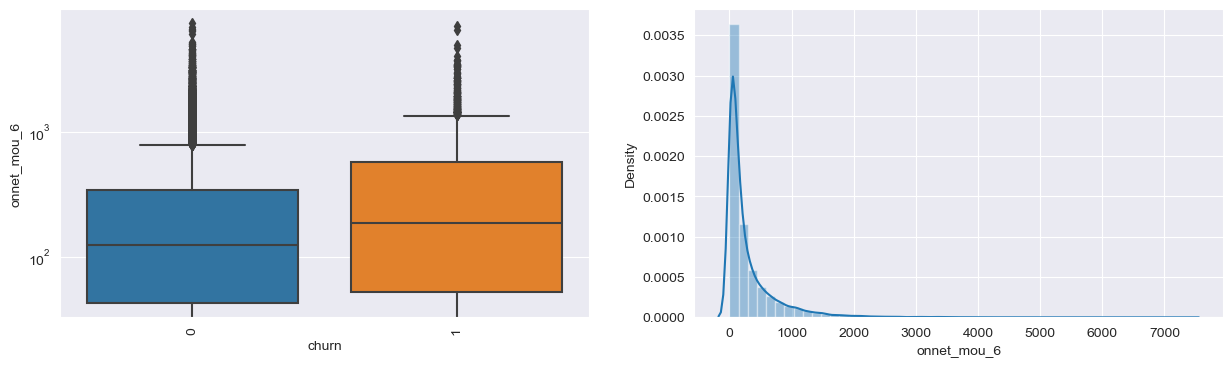

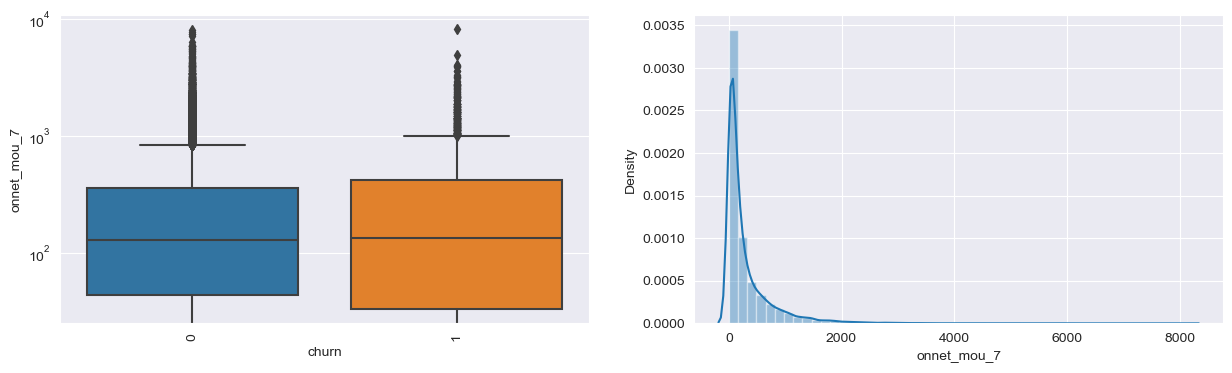

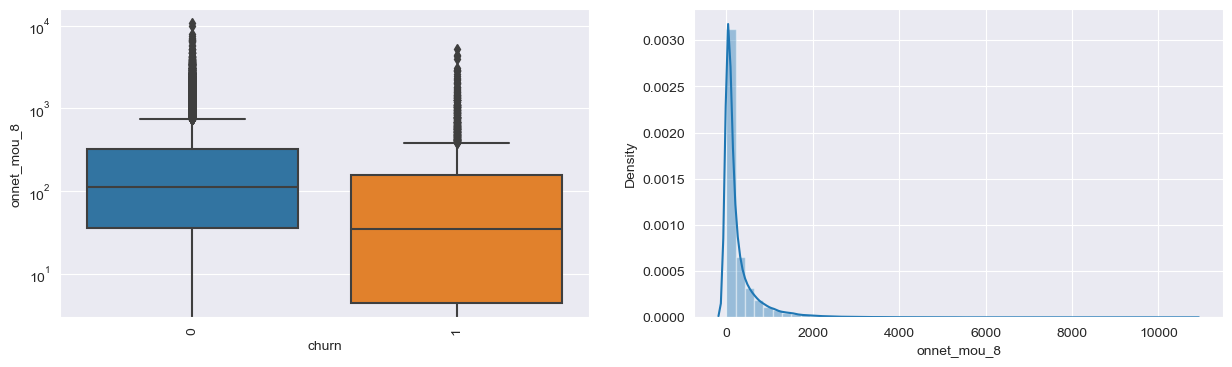

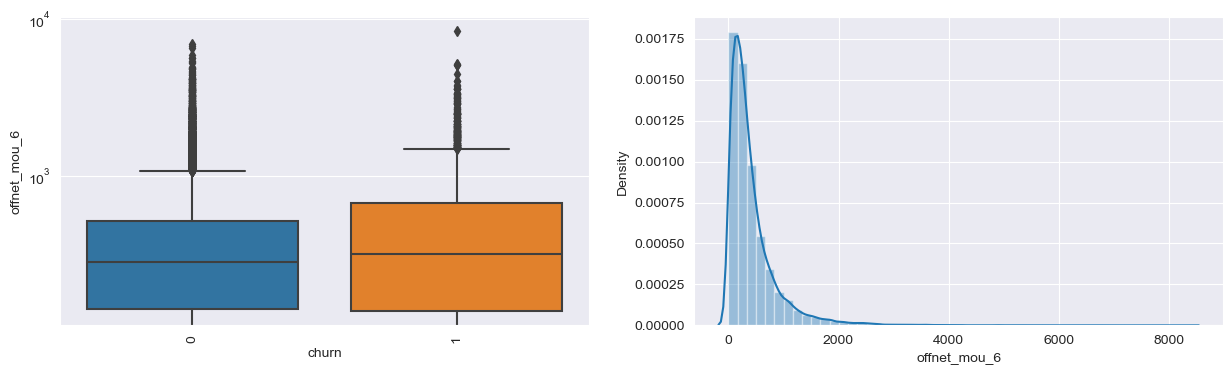

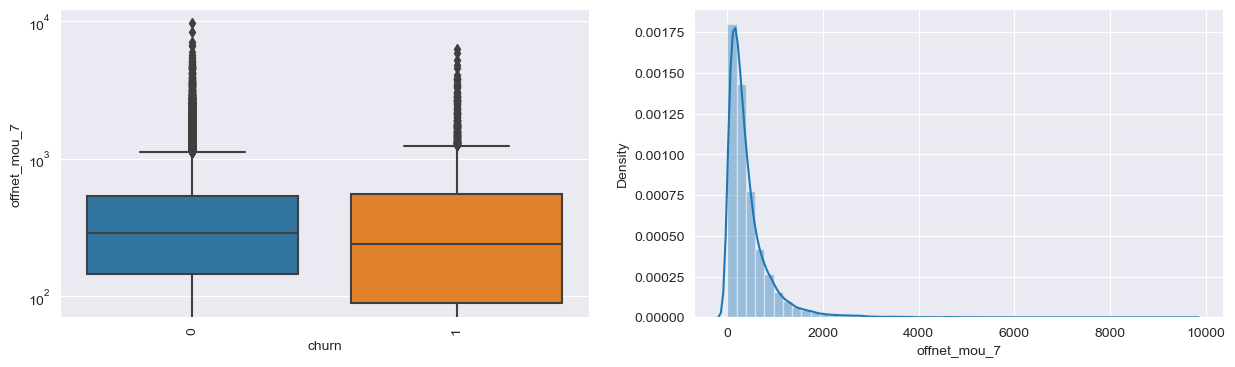

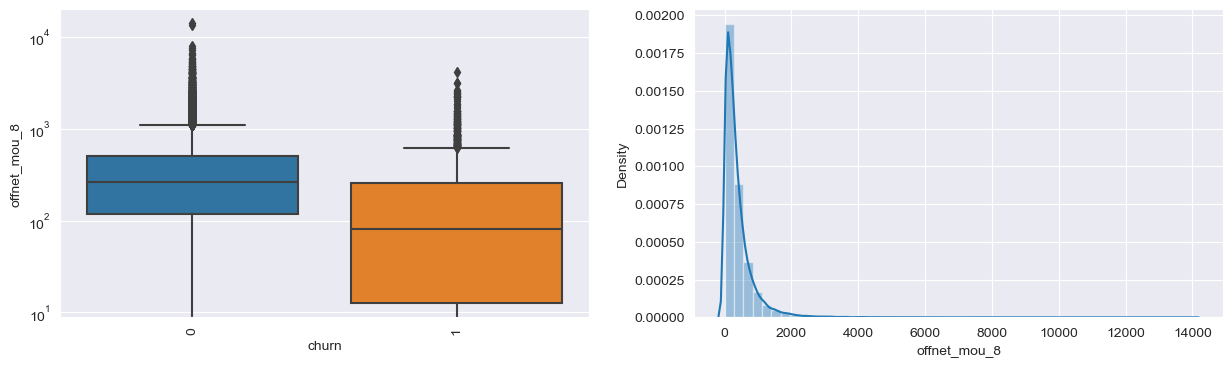

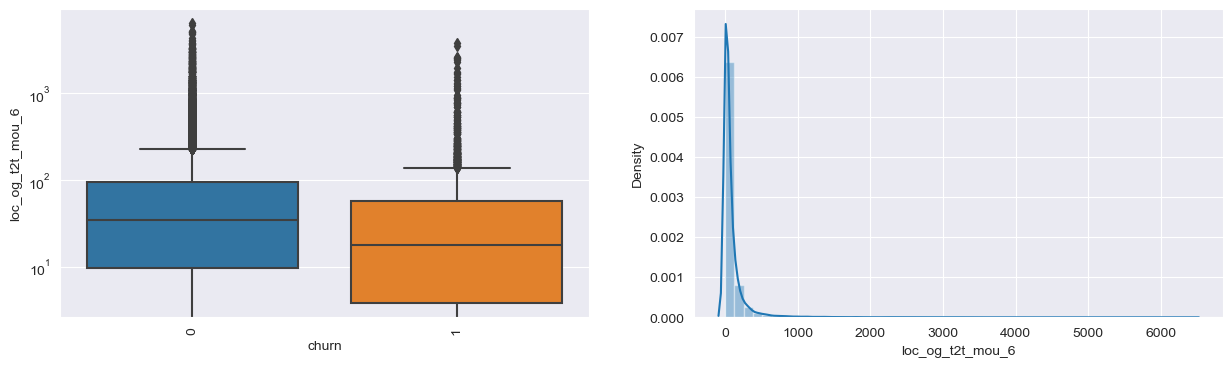

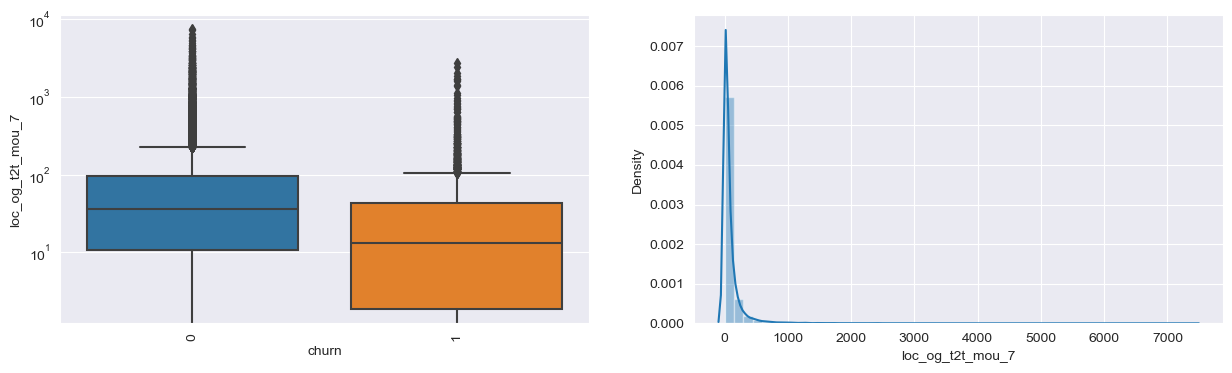

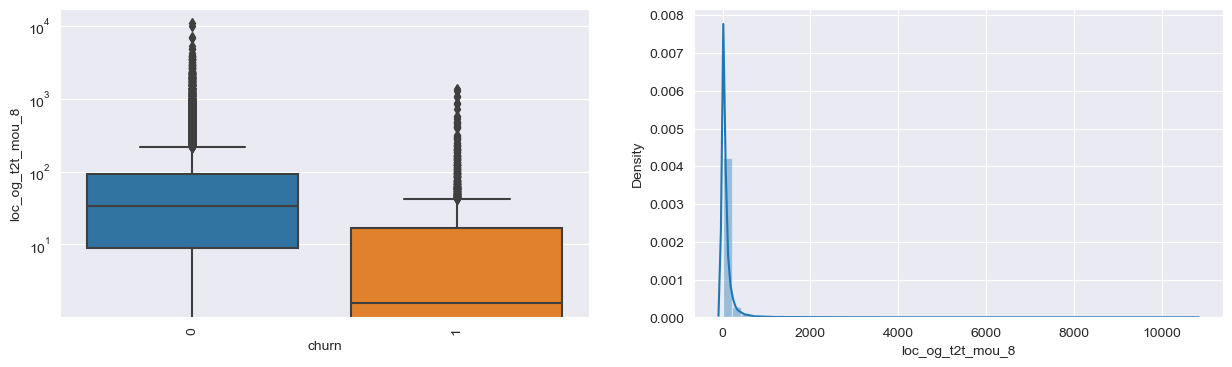

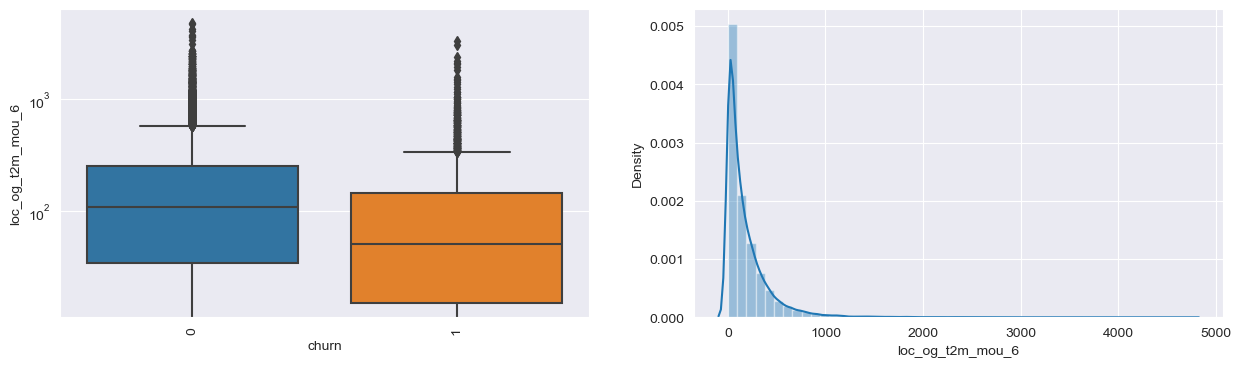

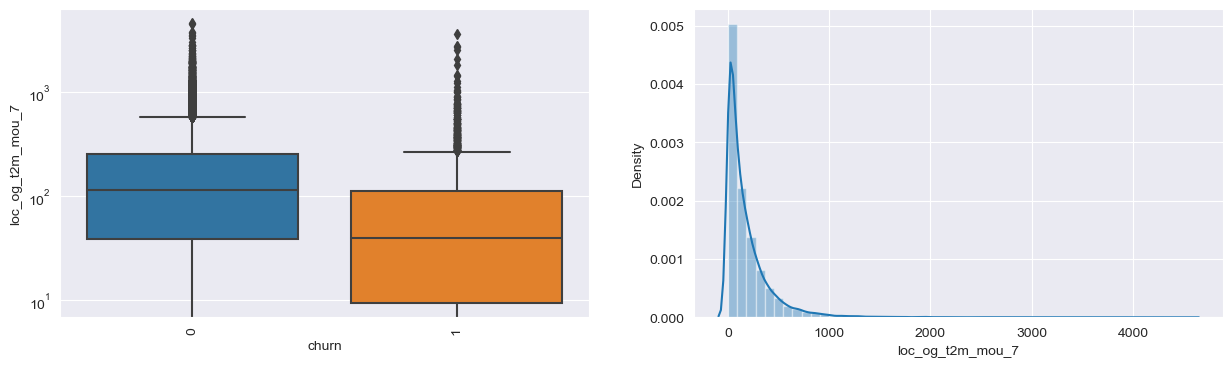

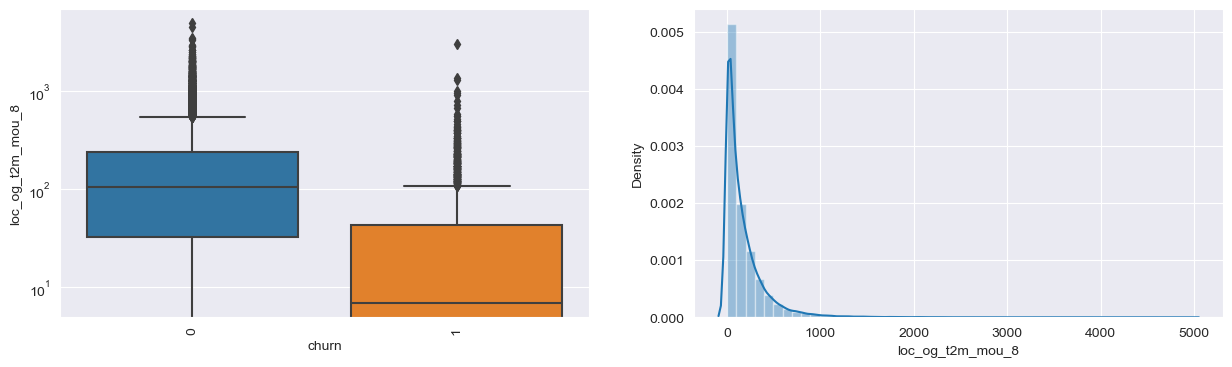

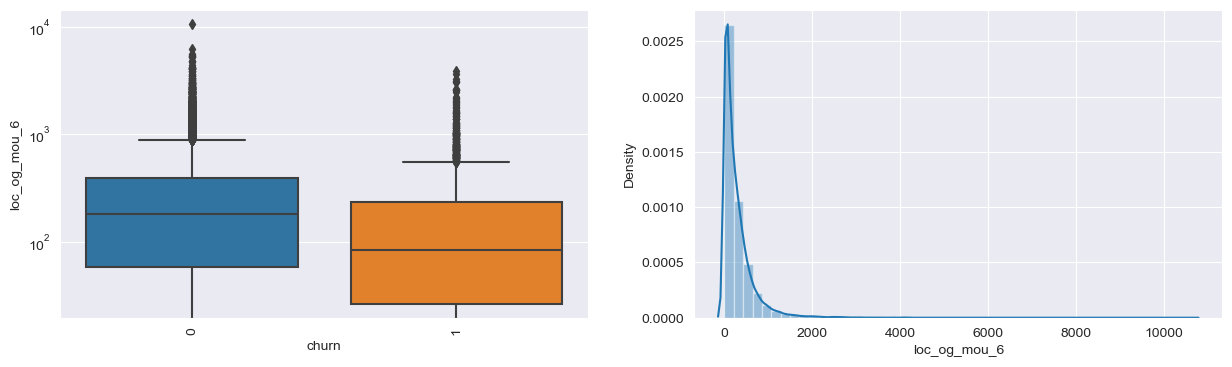

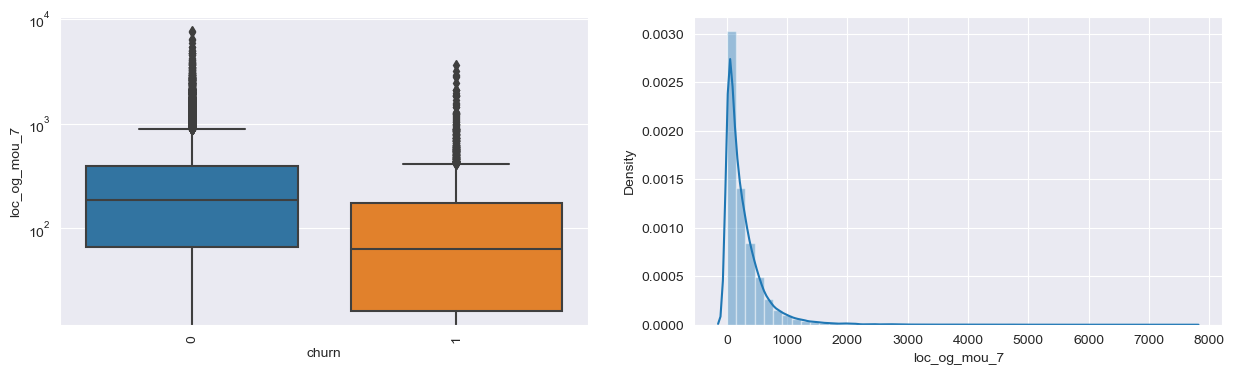

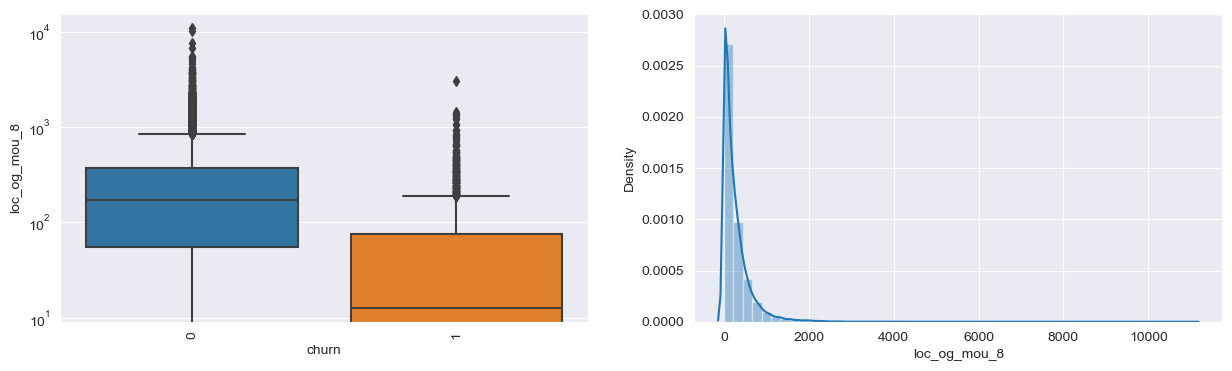

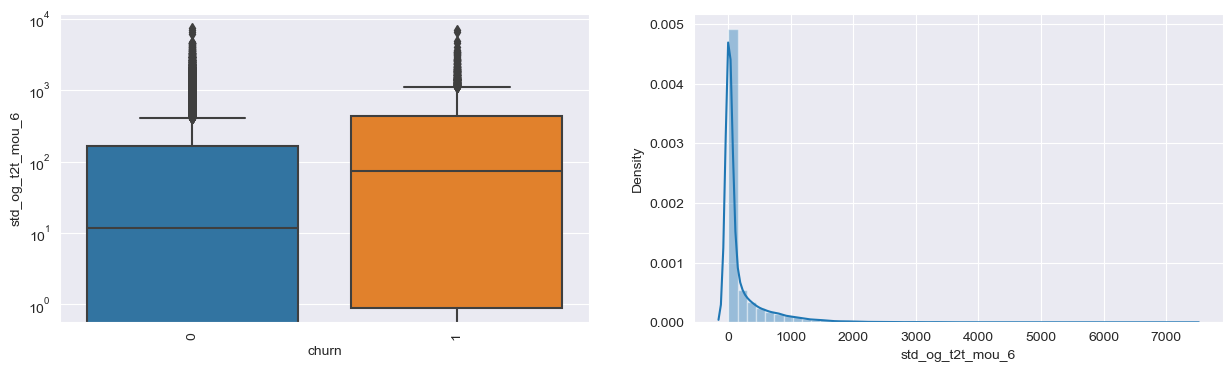

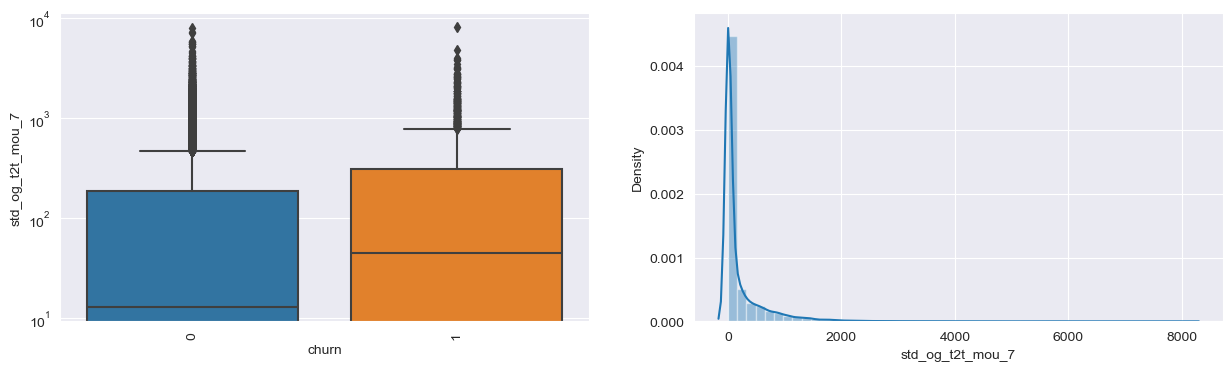

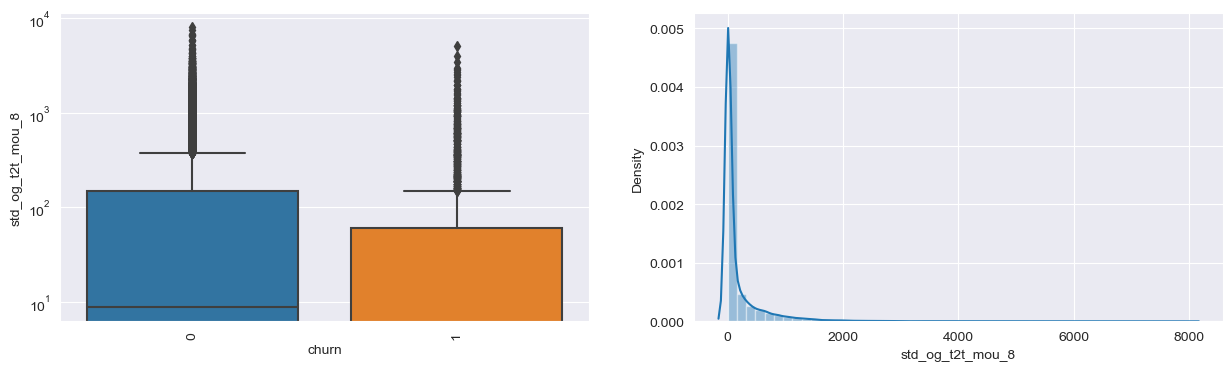

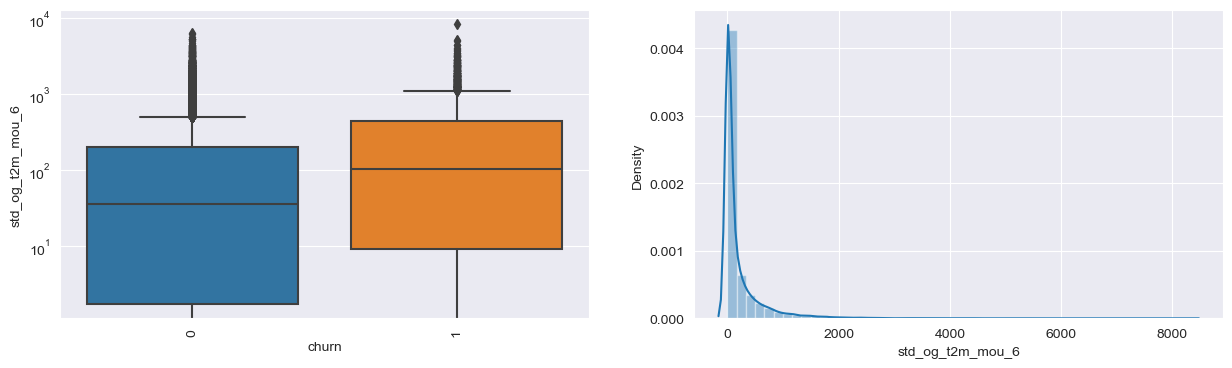

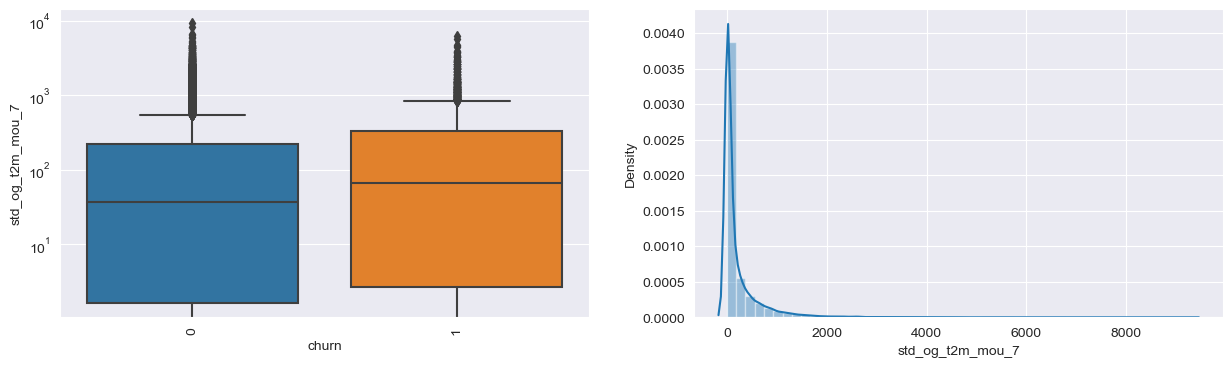

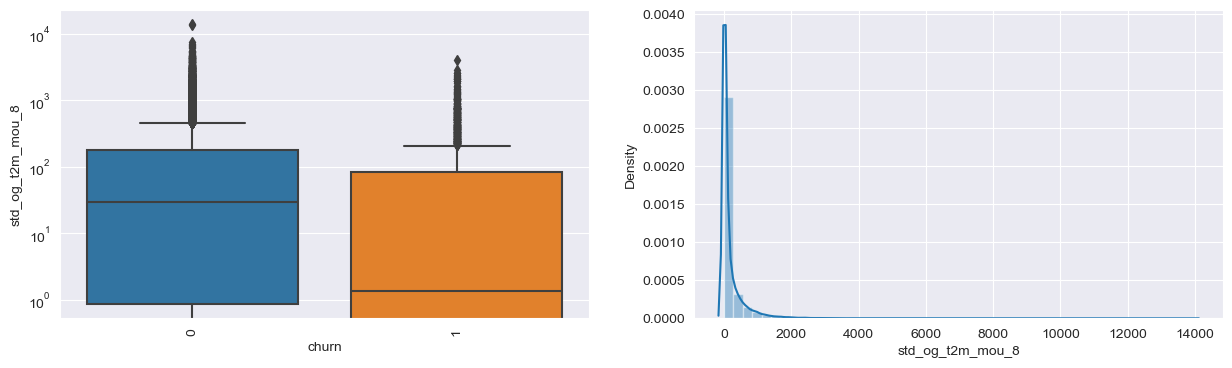

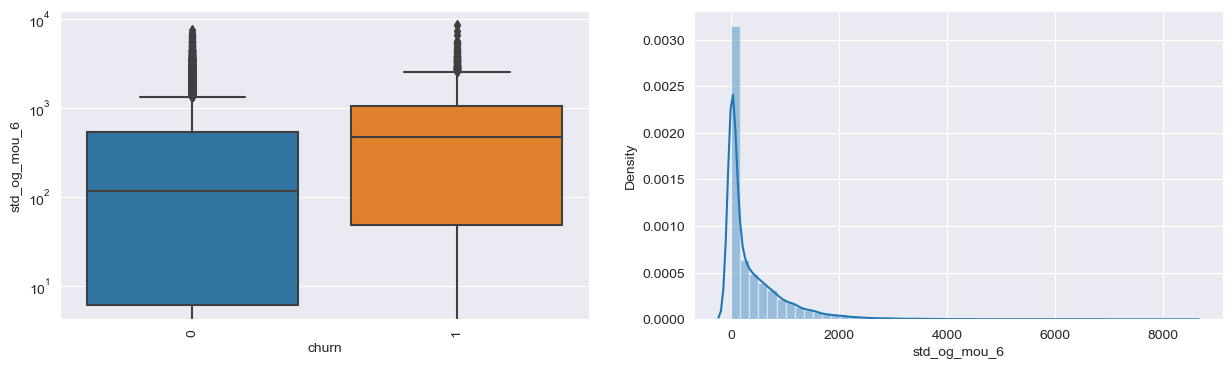

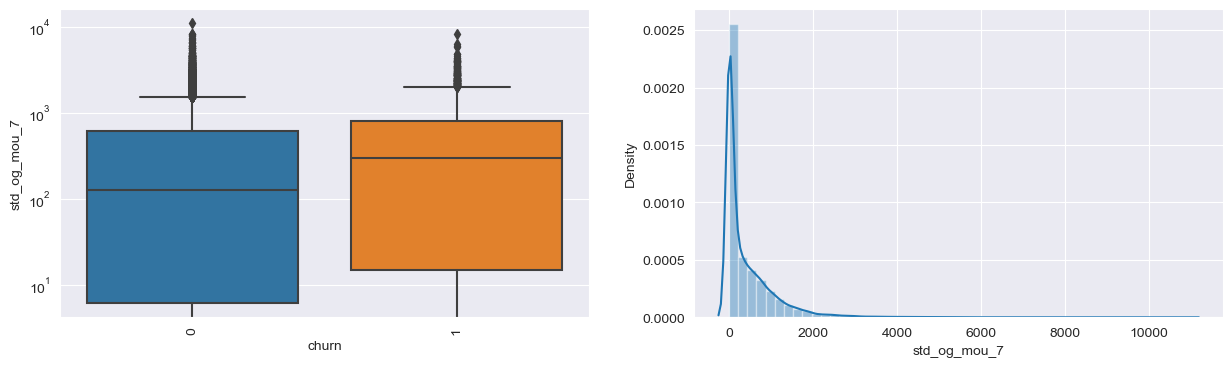

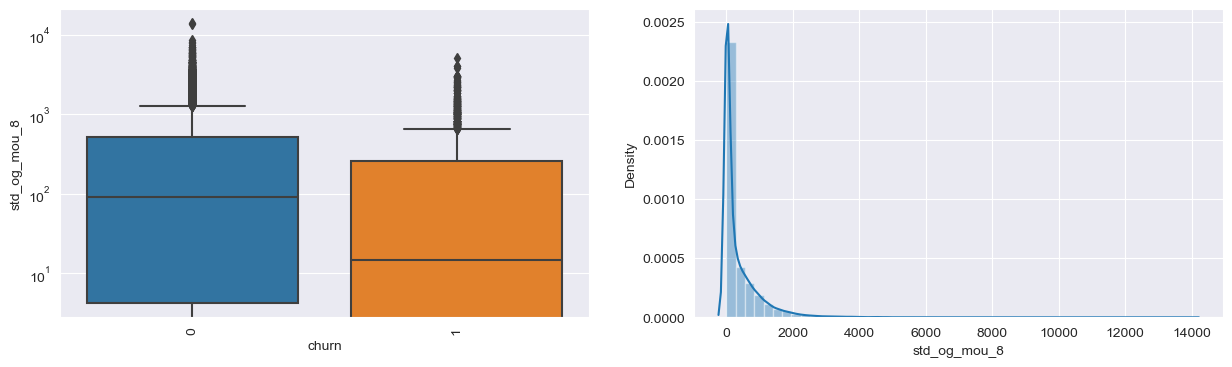

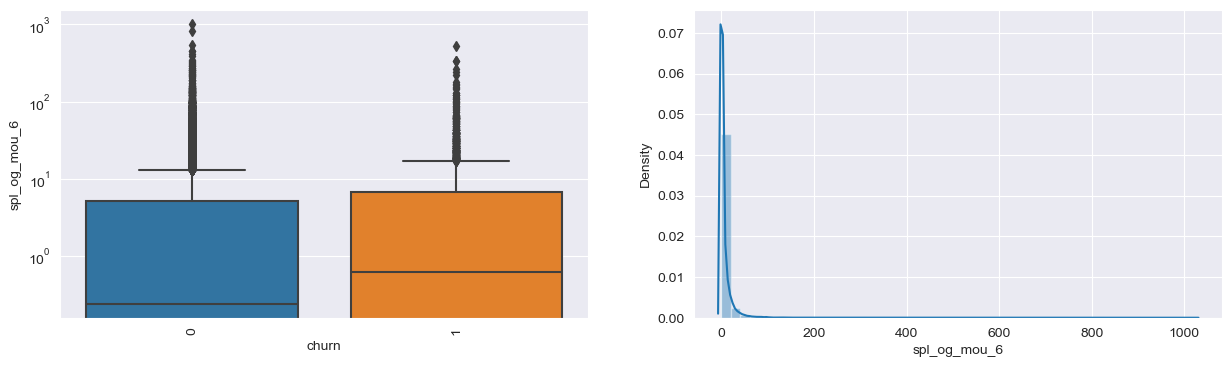

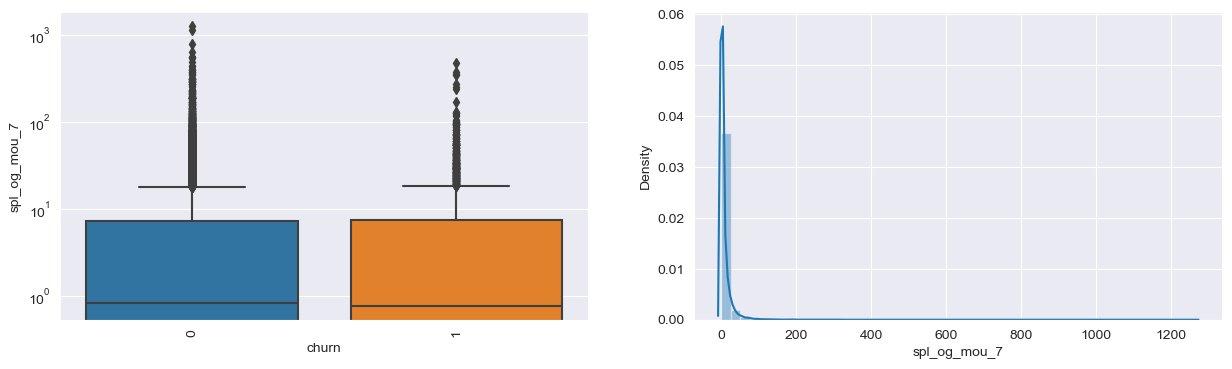

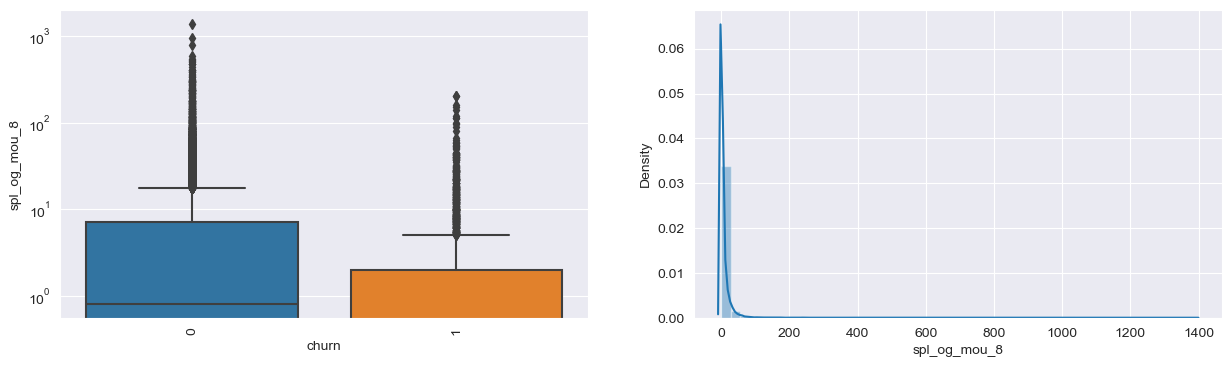

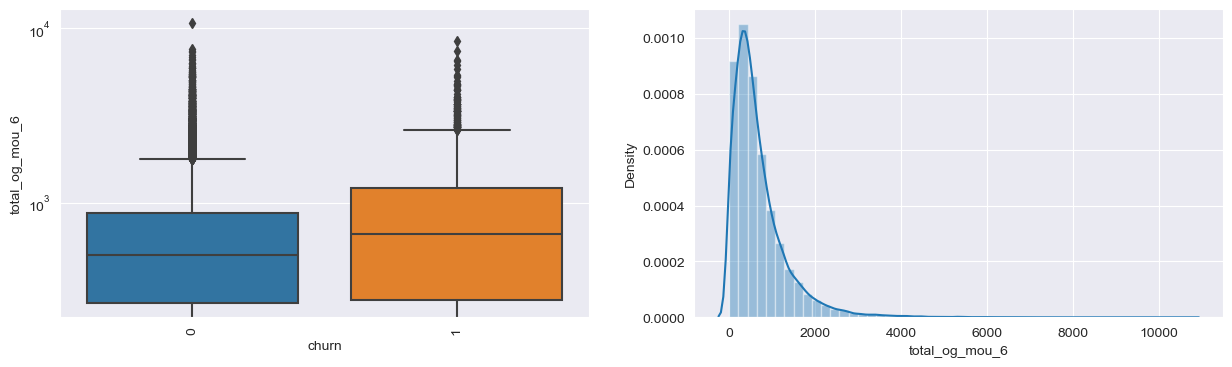

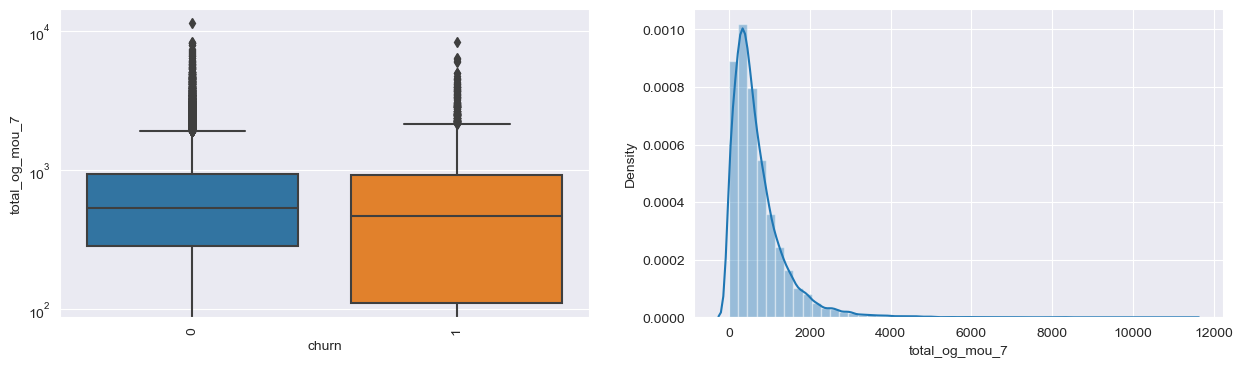

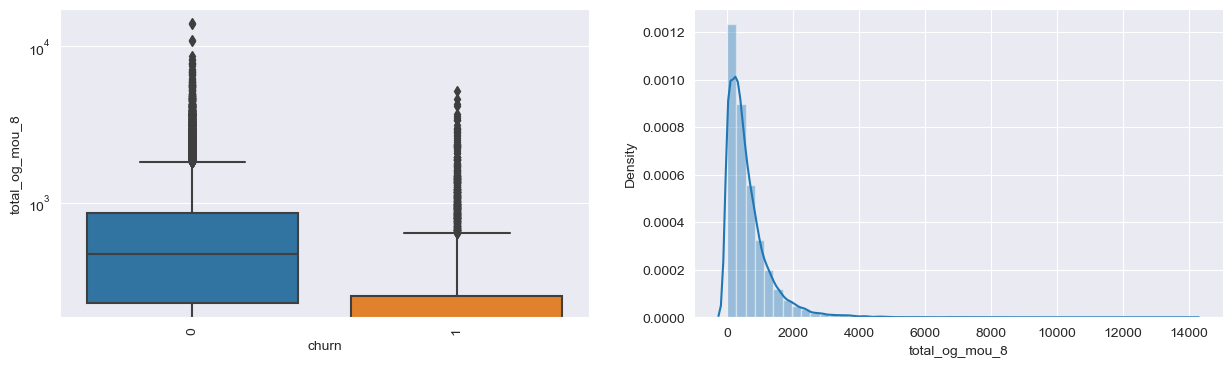

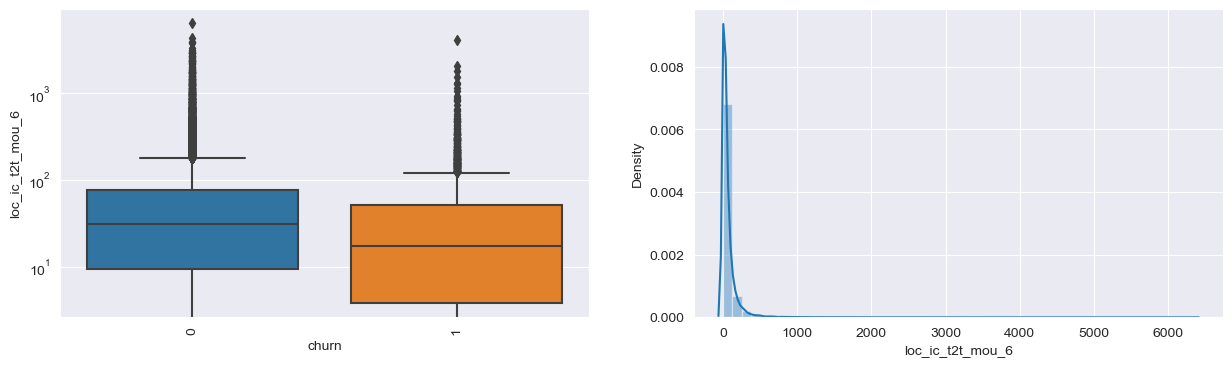

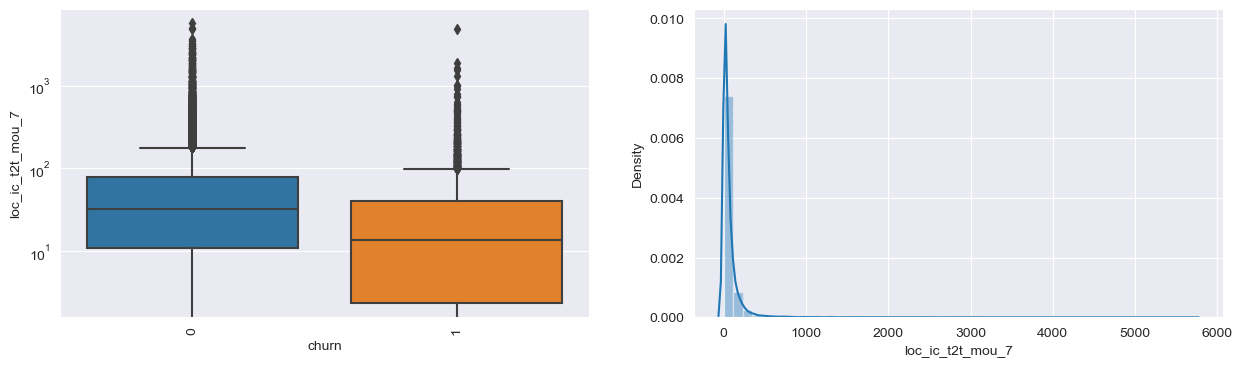

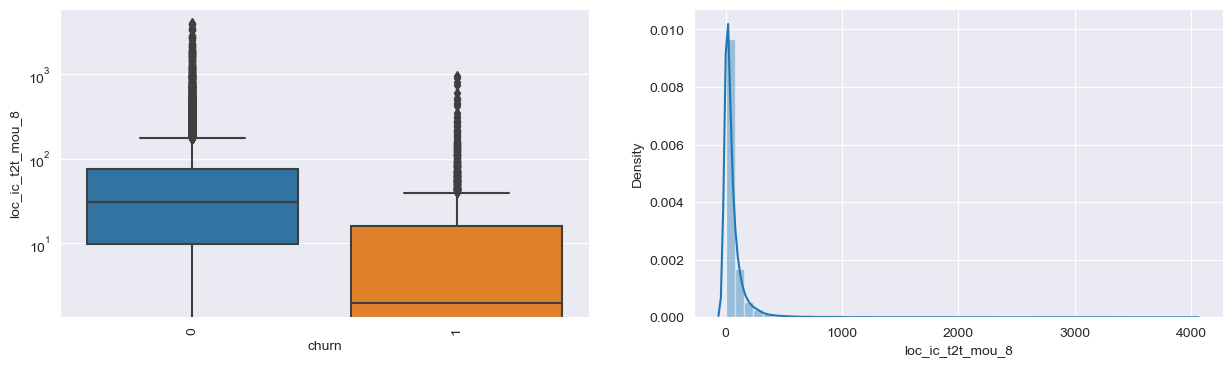

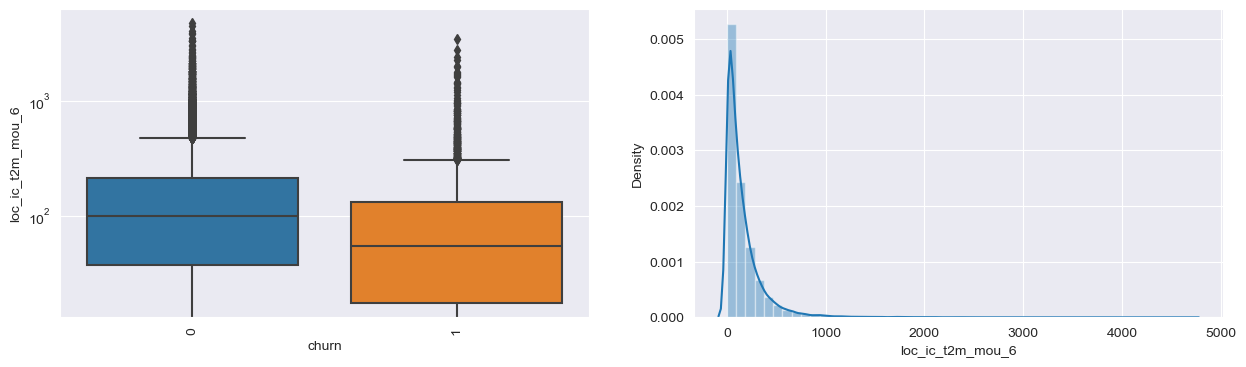

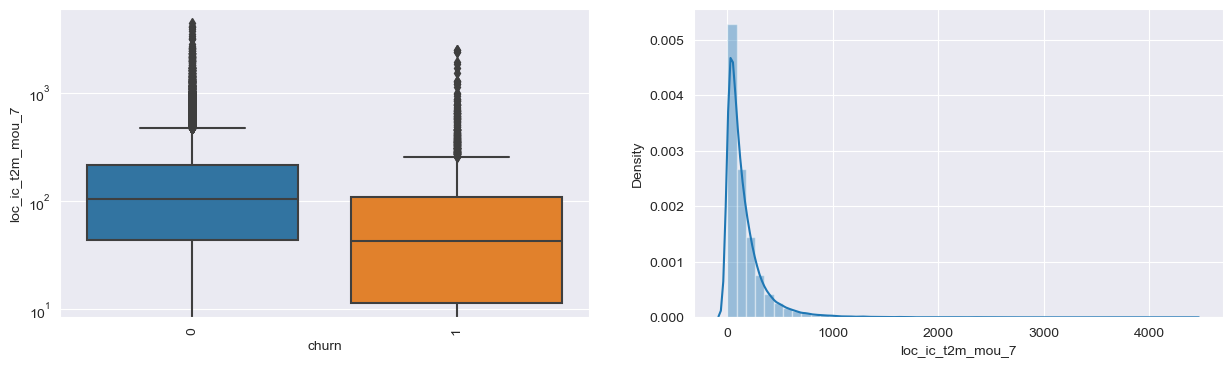

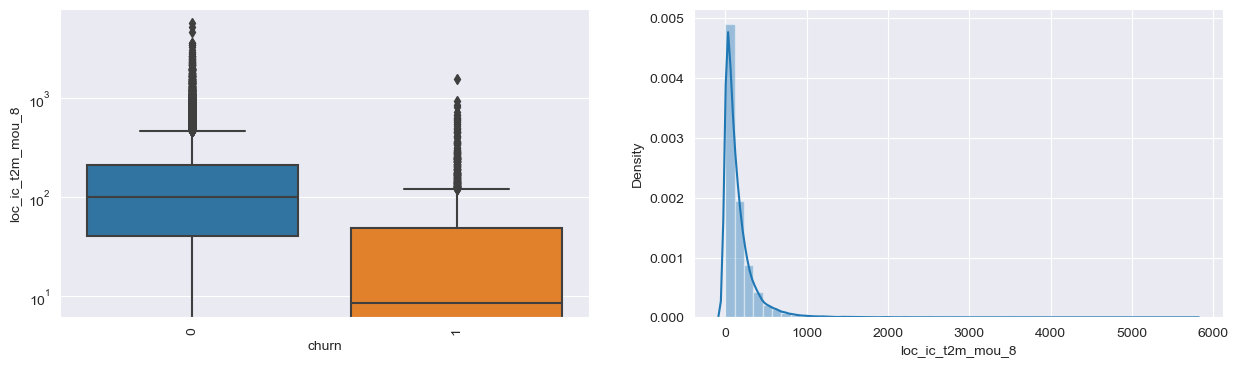

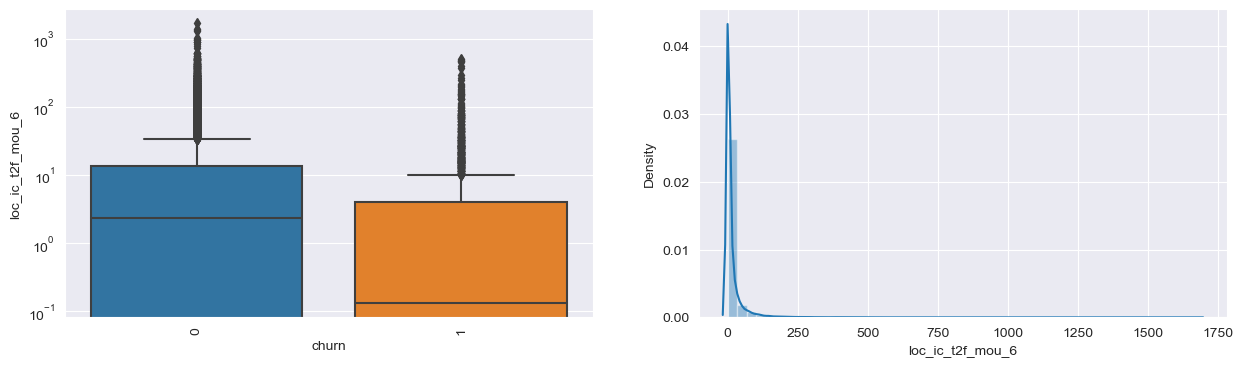

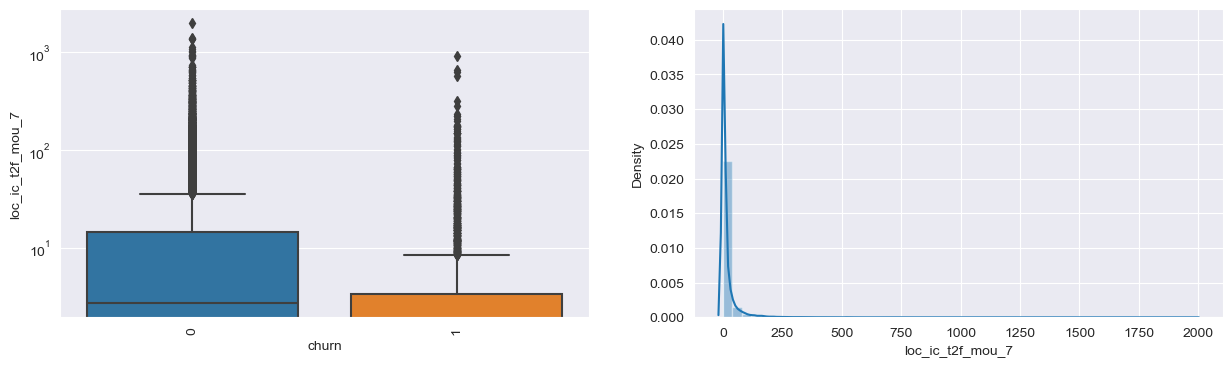

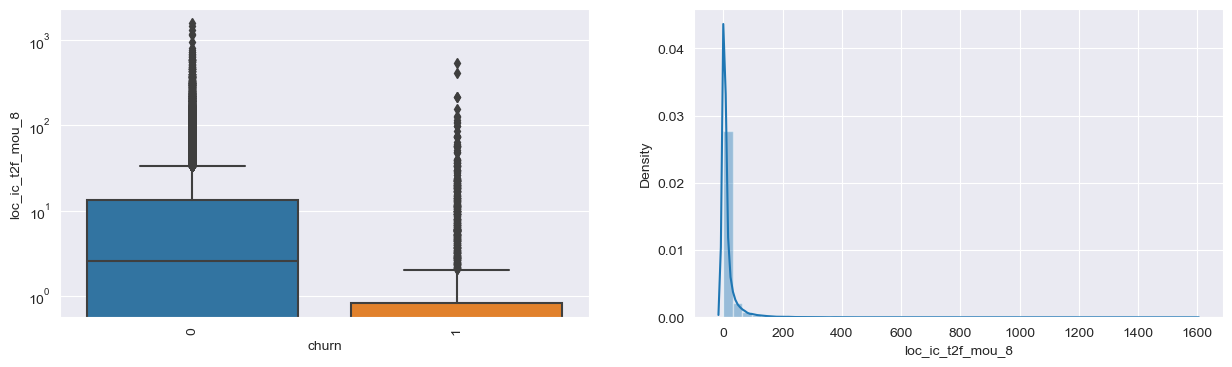

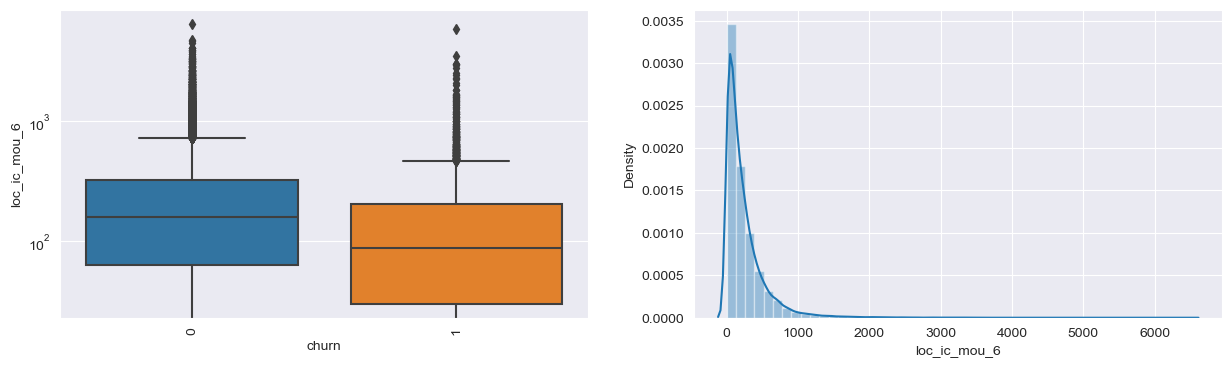

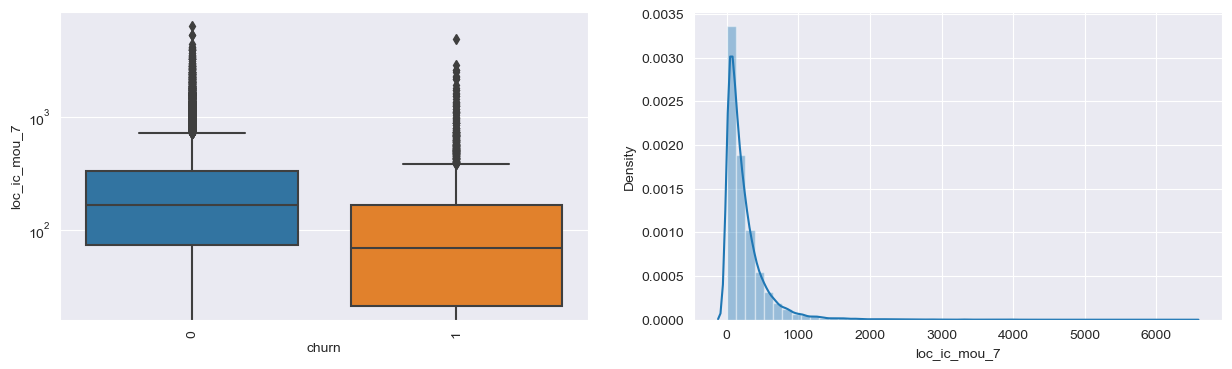

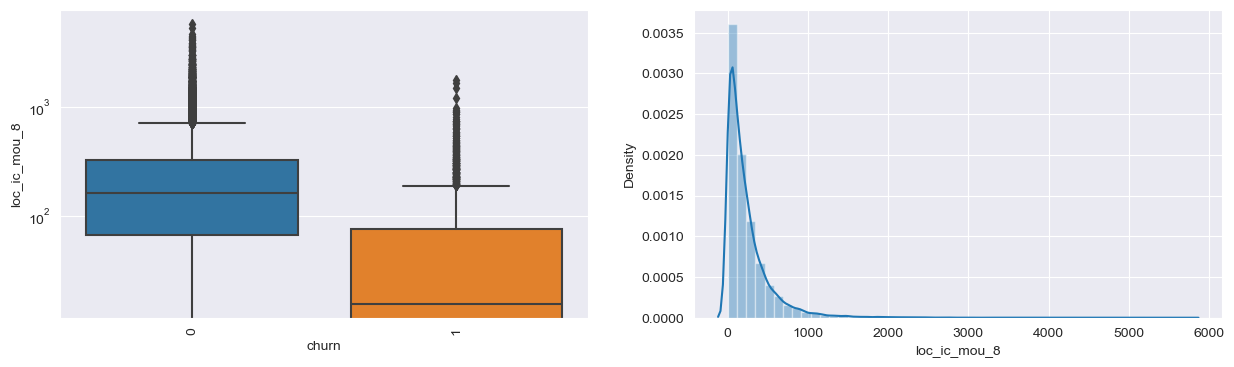

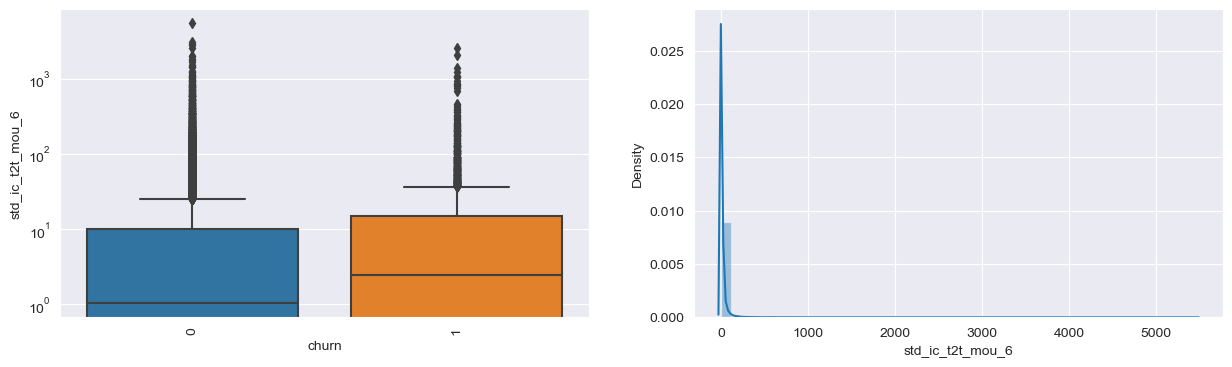

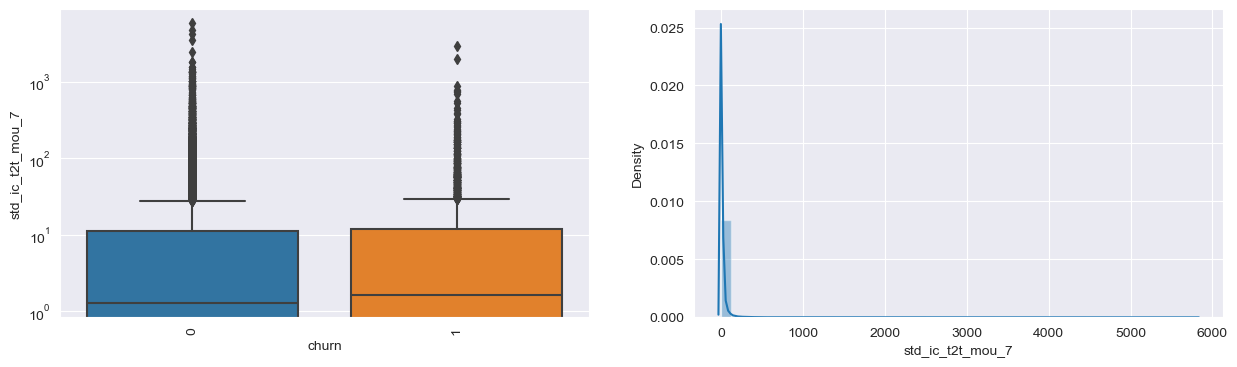

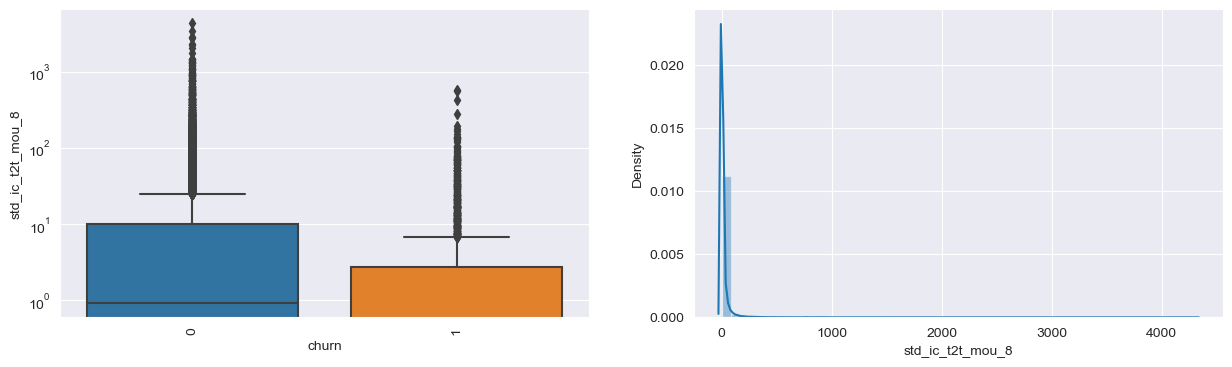

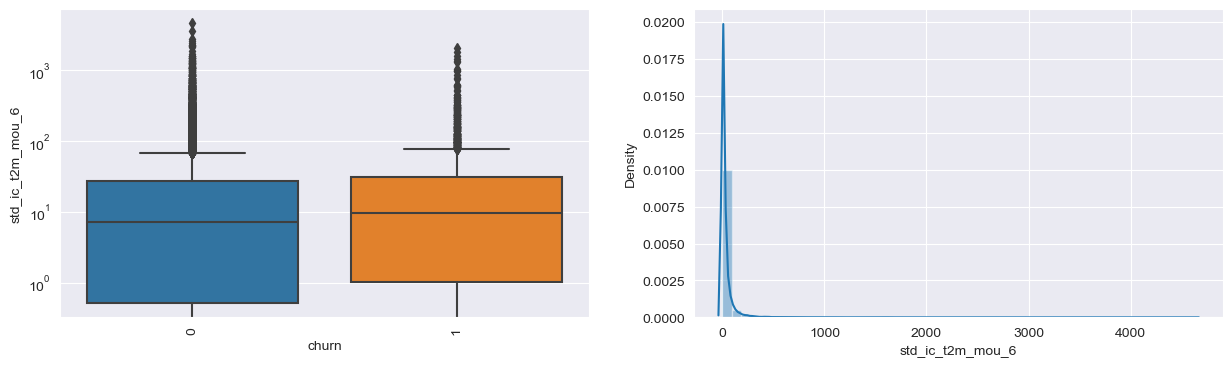

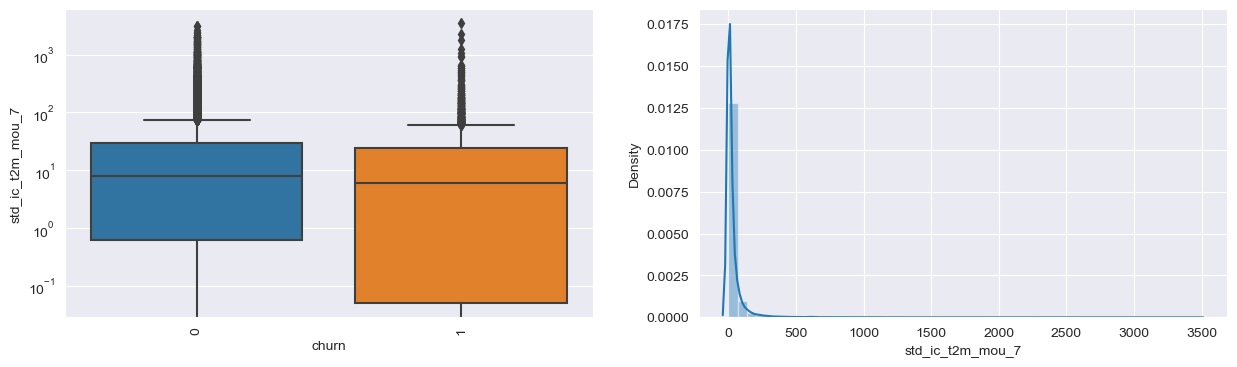

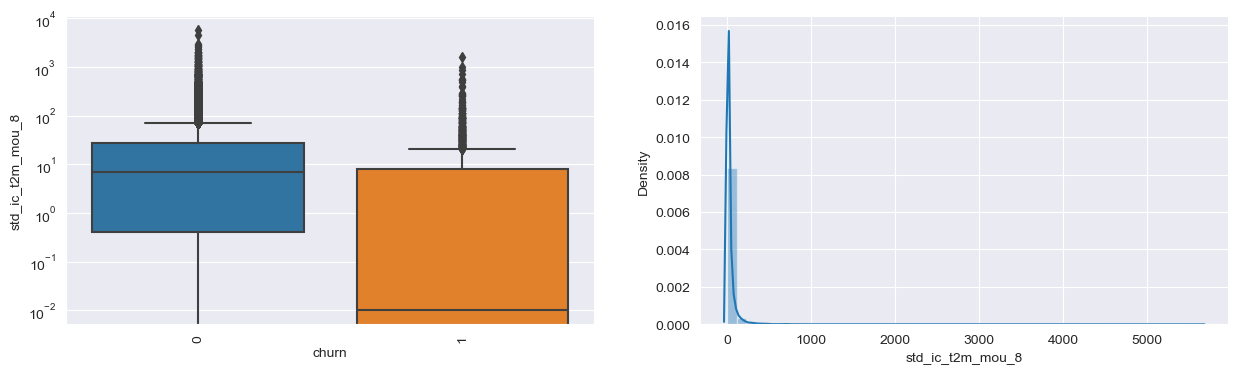

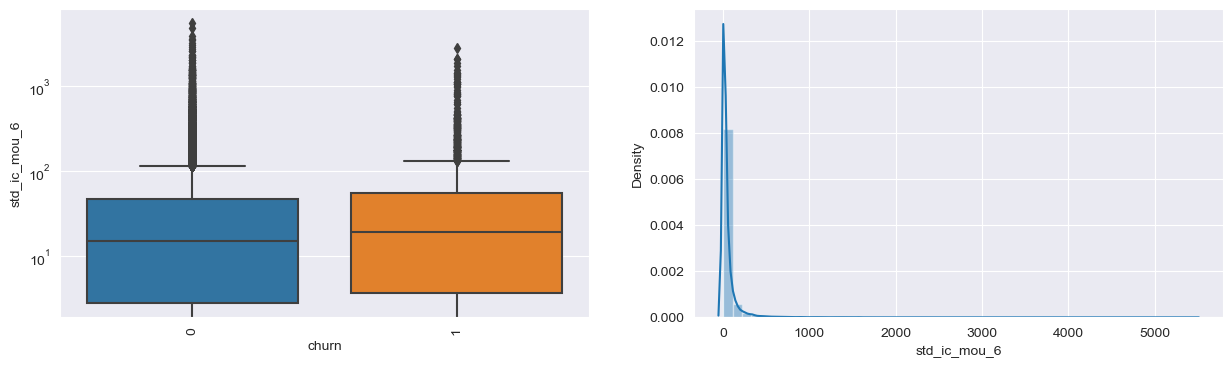

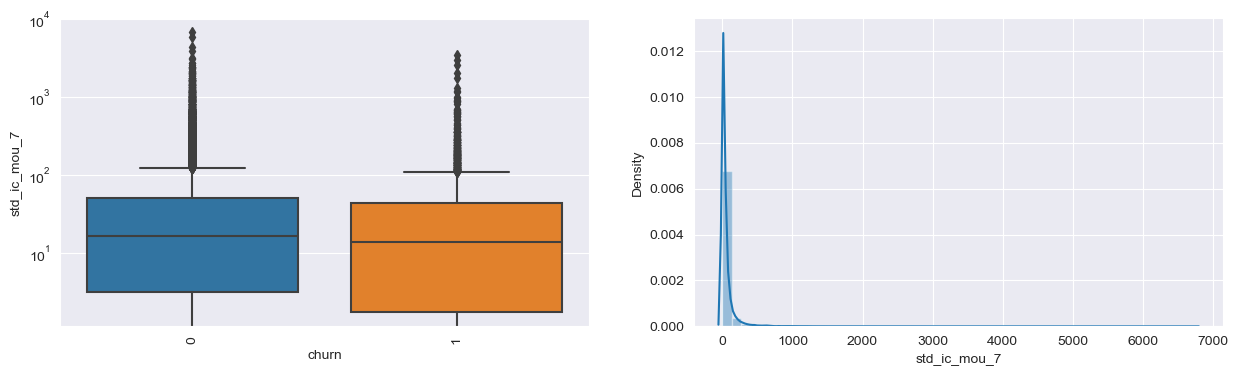

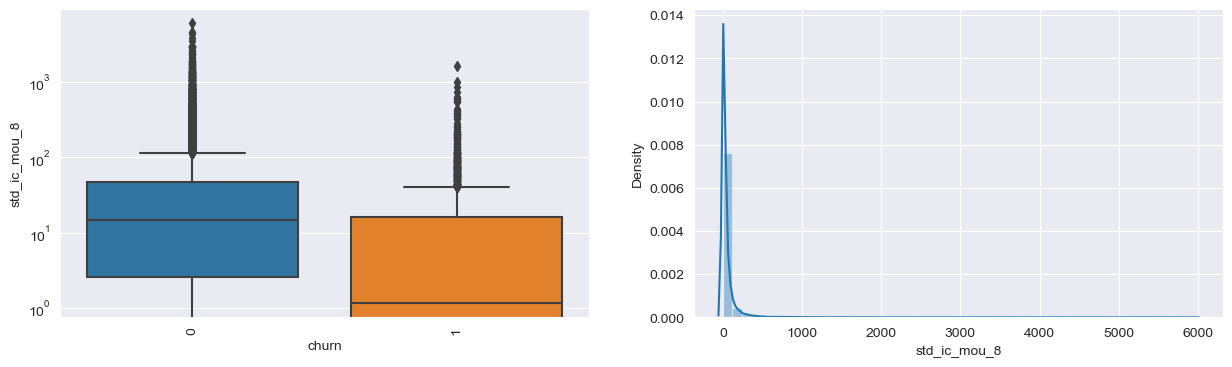

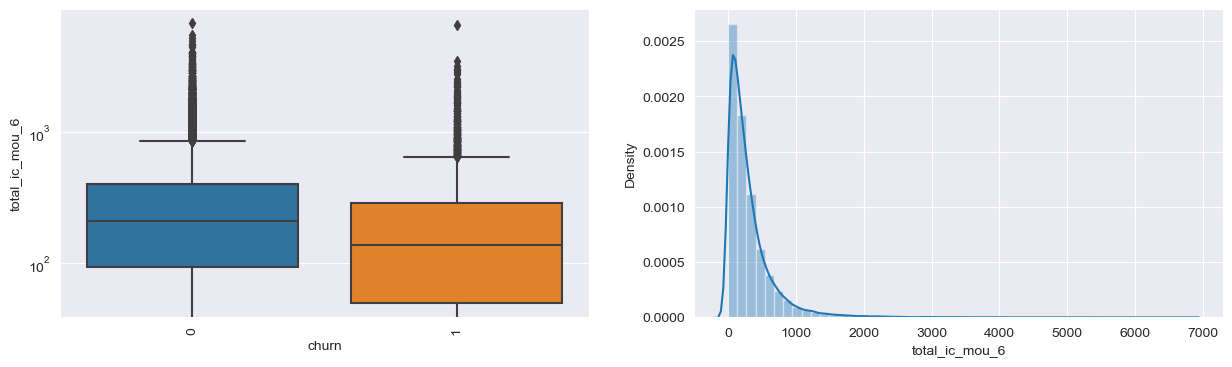

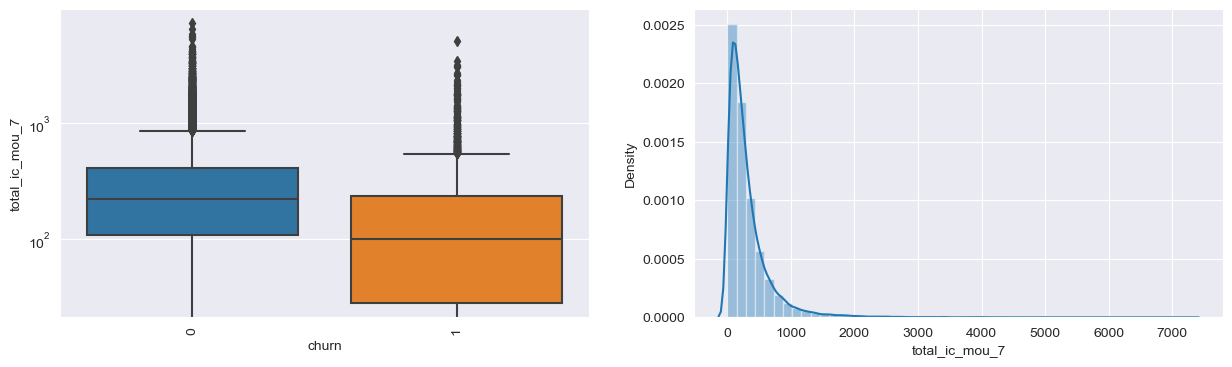

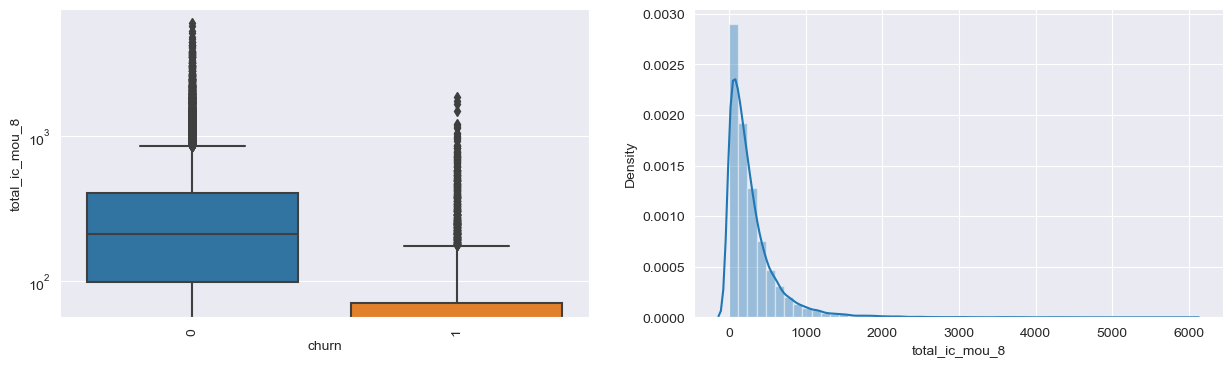

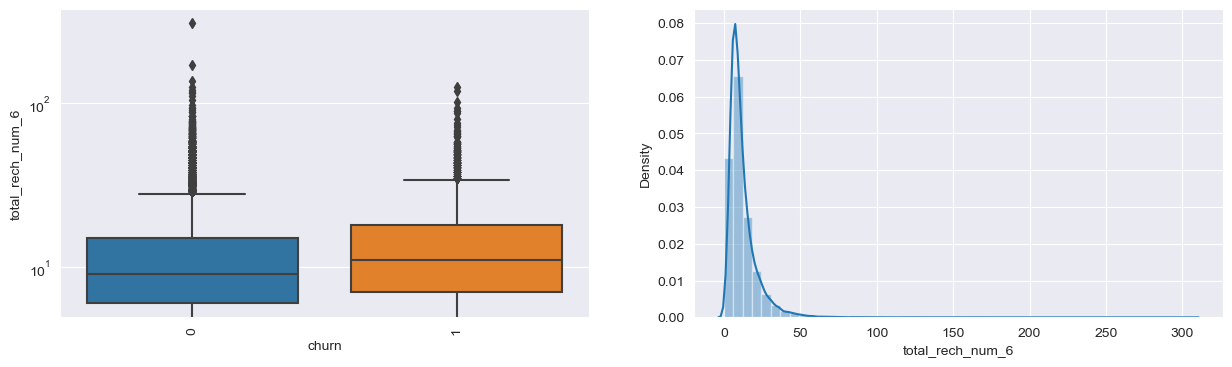

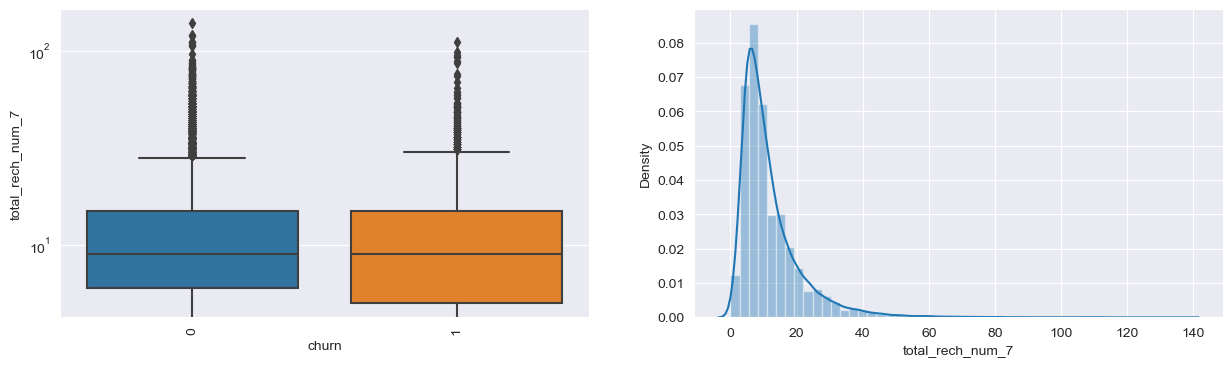

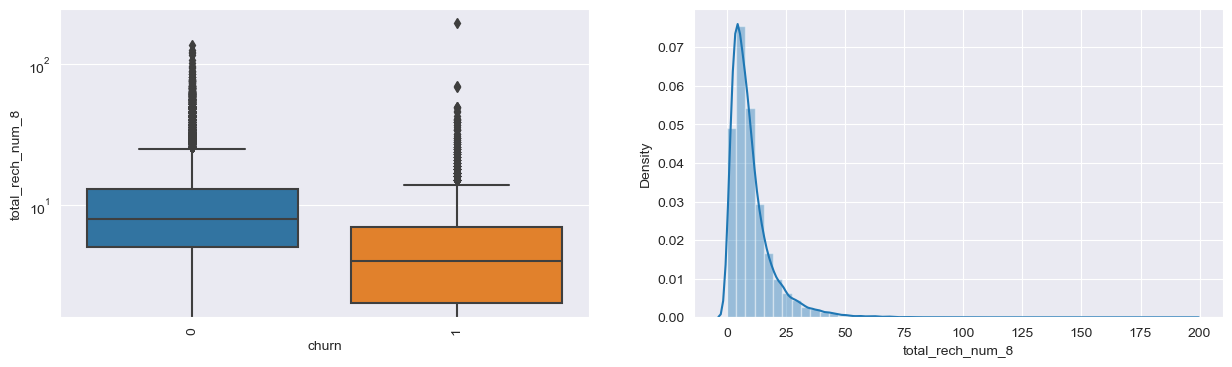

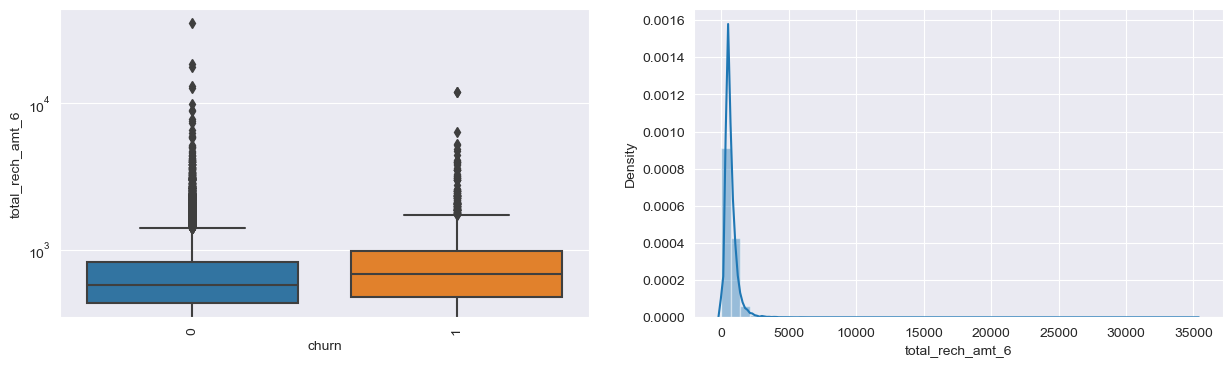

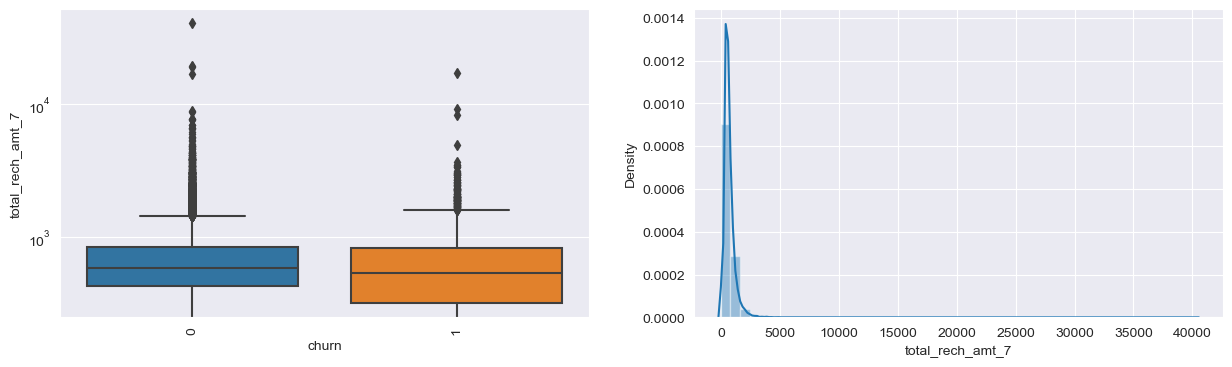

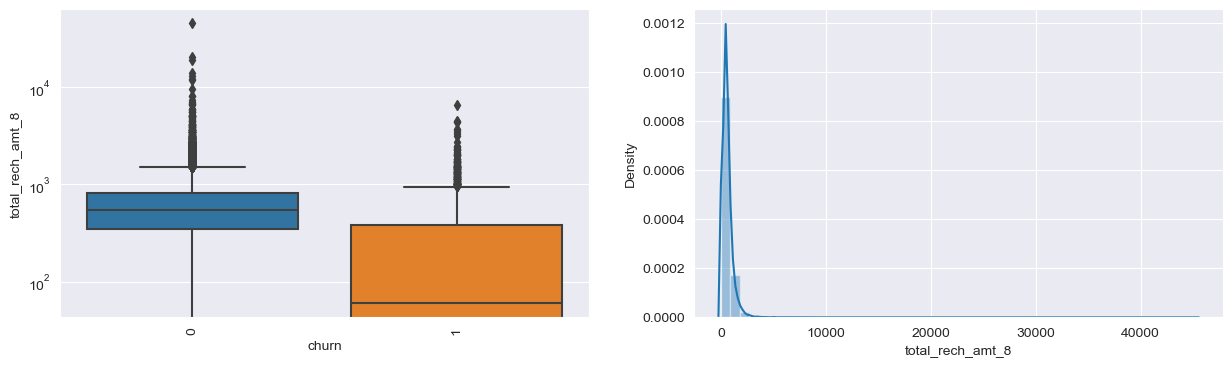

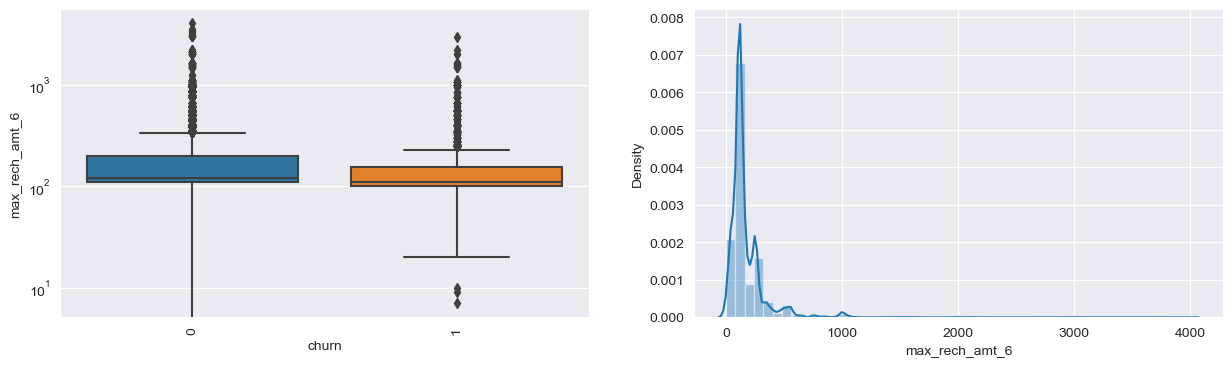

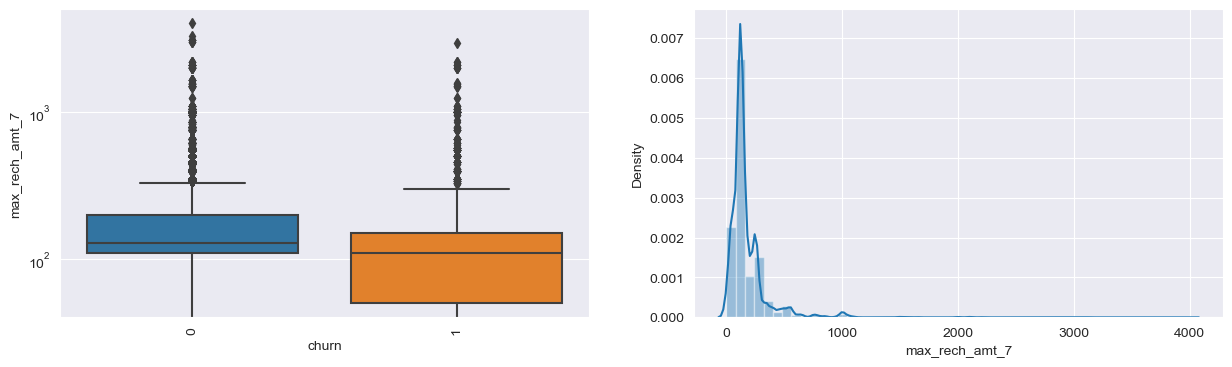

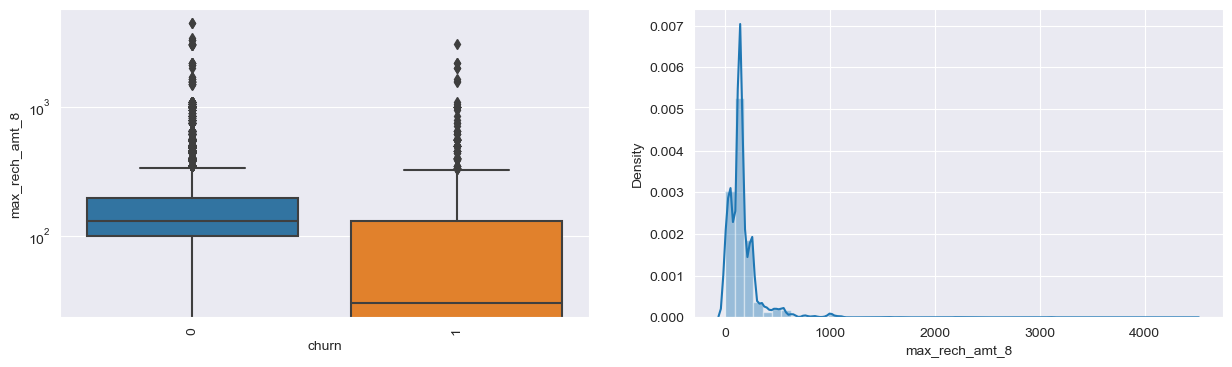

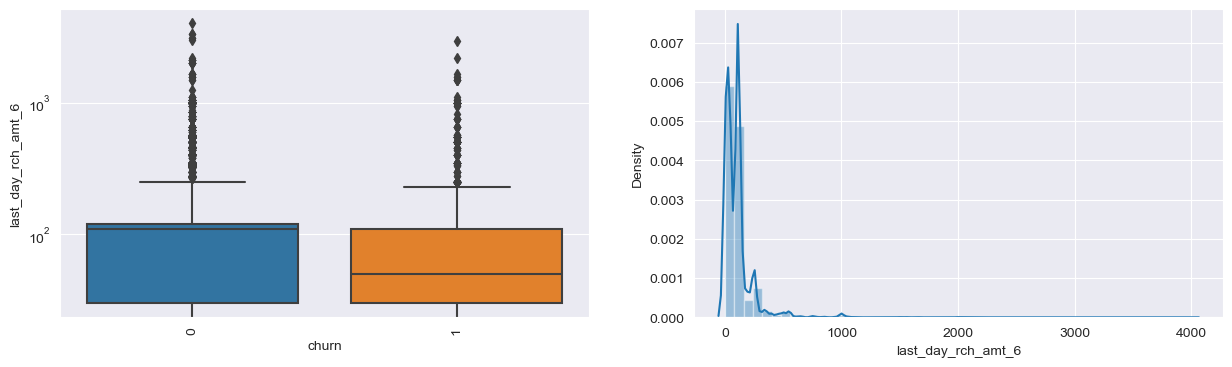

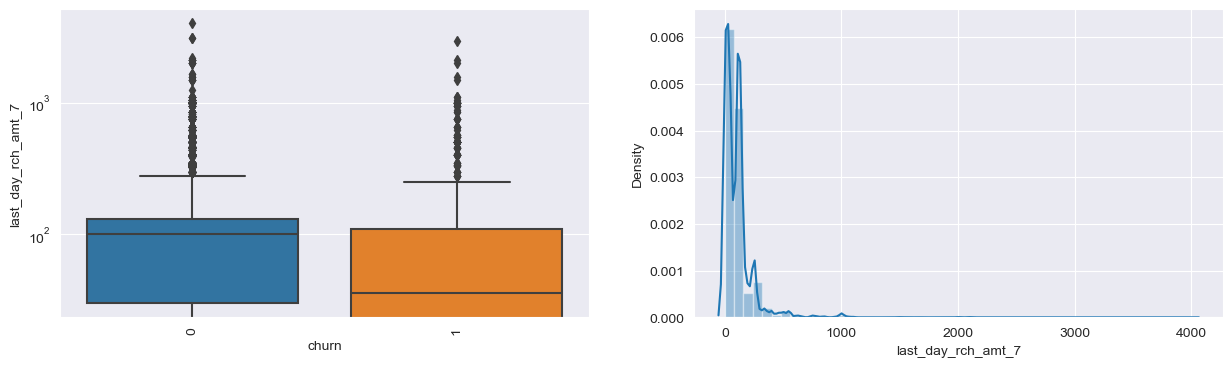

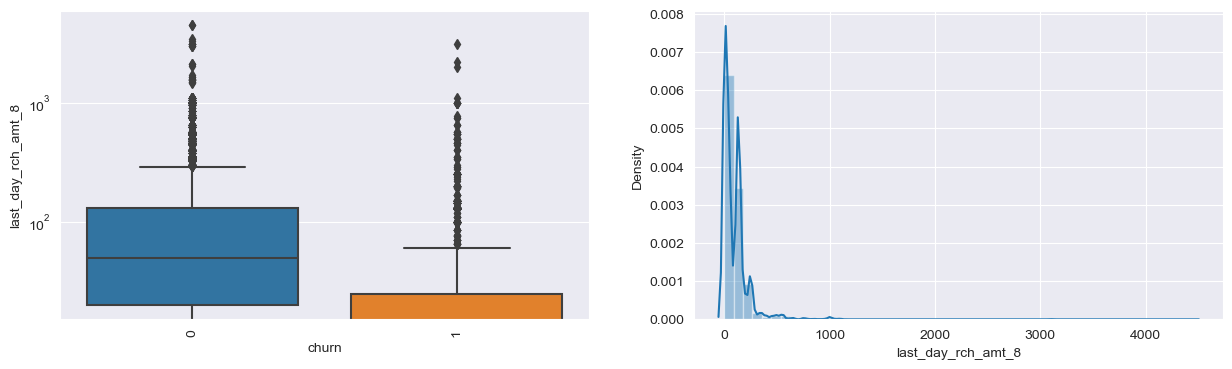

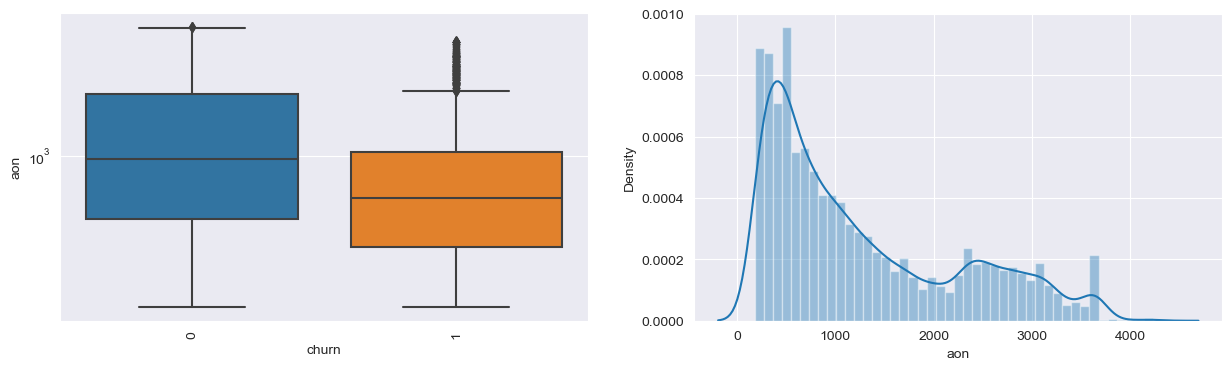

In [30]:
plot_num(col_list, True)

In [31]:
null_percent(col_list)

loc_ic_t2t_mou_8      3.128857
loc_og_t2m_mou_8      3.128857
std_ic_mou_8          3.128857
std_ic_t2m_mou_8      3.128857
std_ic_t2t_mou_8      3.128857
loc_ic_mou_8          3.128857
loc_ic_t2f_mou_8      3.128857
loc_ic_t2m_mou_8      3.128857
std_og_mou_8          3.128857
std_og_t2m_mou_8      3.128857
std_og_t2t_mou_8      3.128857
loc_og_mou_8          3.128857
spl_og_mou_8          3.128857
offnet_mou_8          3.128857
loc_og_t2t_mou_8      3.128857
onnet_mou_8           3.128857
std_ic_mou_6          1.054071
loc_ic_t2m_mou_6      1.054071
loc_og_t2m_mou_6      1.054071
loc_ic_t2t_mou_6      1.054071
offnet_mou_6          1.054071
loc_ic_mou_6          1.054071
std_ic_t2t_mou_6      1.054071
spl_og_mou_6          1.054071
loc_ic_t2f_mou_6      1.054071
std_og_mou_6          1.054071
loc_og_t2t_mou_6      1.054071
std_og_t2m_mou_6      1.054071
std_ic_t2m_mou_6      1.054071
std_og_t2t_mou_6      1.054071
onnet_mou_6           1.054071
loc_og_mou_6          1.054071
offnet_m

In [32]:
# impute the null values using Iterative Imputer
impute(col_list)

arpu_6                0.0
loc_ic_mou_8          0.0
std_ic_t2m_mou_8      0.0
std_ic_t2m_mou_7      0.0
std_ic_t2m_mou_6      0.0
std_ic_t2t_mou_8      0.0
std_ic_t2t_mou_7      0.0
std_ic_t2t_mou_6      0.0
loc_ic_mou_7          0.0
std_ic_mou_7          0.0
loc_ic_mou_6          0.0
loc_ic_t2f_mou_8      0.0
loc_ic_t2f_mou_7      0.0
loc_ic_t2f_mou_6      0.0
loc_ic_t2m_mou_8      0.0
loc_ic_t2m_mou_7      0.0
std_ic_mou_6          0.0
std_ic_mou_8          0.0
arpu_7                0.0
total_rech_amt_8      0.0
last_day_rch_amt_8    0.0
last_day_rch_amt_7    0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
max_rech_amt_6        0.0
total_rech_amt_7      0.0
total_ic_mou_6        0.0
total_rech_amt_6      0.0
total_rech_num_8      0.0
total_rech_num_7      0.0
total_rech_num_6      0.0
total_ic_mou_8        0.0
total_ic_mou_7        0.0
loc_ic_t2m_mou_6      0.0
loc_ic_t2t_mou_8      0.0
loc_ic_t2t_mou_7      0.0
loc_og_t2t_mou_6      0.0
loc_og_mou_6

### handling of columns containing dates

In [33]:
col_list = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6',
            'date_of_last_rech_data_7','date_of_last_rech_data_8']

In [34]:
# dropping these columns because date of last recharge are not very relevant for predicting churn
drop_col(col_list)

(29979, 71)

## Model Selection

### Perform PCA, plot scree plot and identify the least number of Principal components to explain high degree of variance

In [35]:
# splitting the data into train and test sets
O_X_train, O_X_test, O_y_train, O_y_test = train_test_split(high_valued.drop('churn',axis=1), high_valued['churn'],
                                                            train_size = 0.99,stratify=high_valued['churn'],random_state=100)

In [36]:
O_y_train = O_y_train.values.reshape((-1,1))
O_y_test = O_y_test.values.reshape((-1,1))
O_X_train = O_X_train.values.copy(order='C')
O_X_test = O_X_test.values.copy(order='C')
print('O_X_train shape: ',O_X_train.shape)
print('O_X_test shape: ',O_X_test.shape)
print('O_y_train shape: ',O_y_train.shape)
print('O_y_test shape: ',O_y_test.shape)

O_X_train shape:  (29679, 70)
O_X_test shape:  (300, 70)
O_y_train shape:  (29679, 1)
O_y_test shape:  (300, 1)


In [37]:
# performing pca on the train set
pca = PCA(random_state=100)
pca.fit(O_X_train)

PCA(random_state=100)

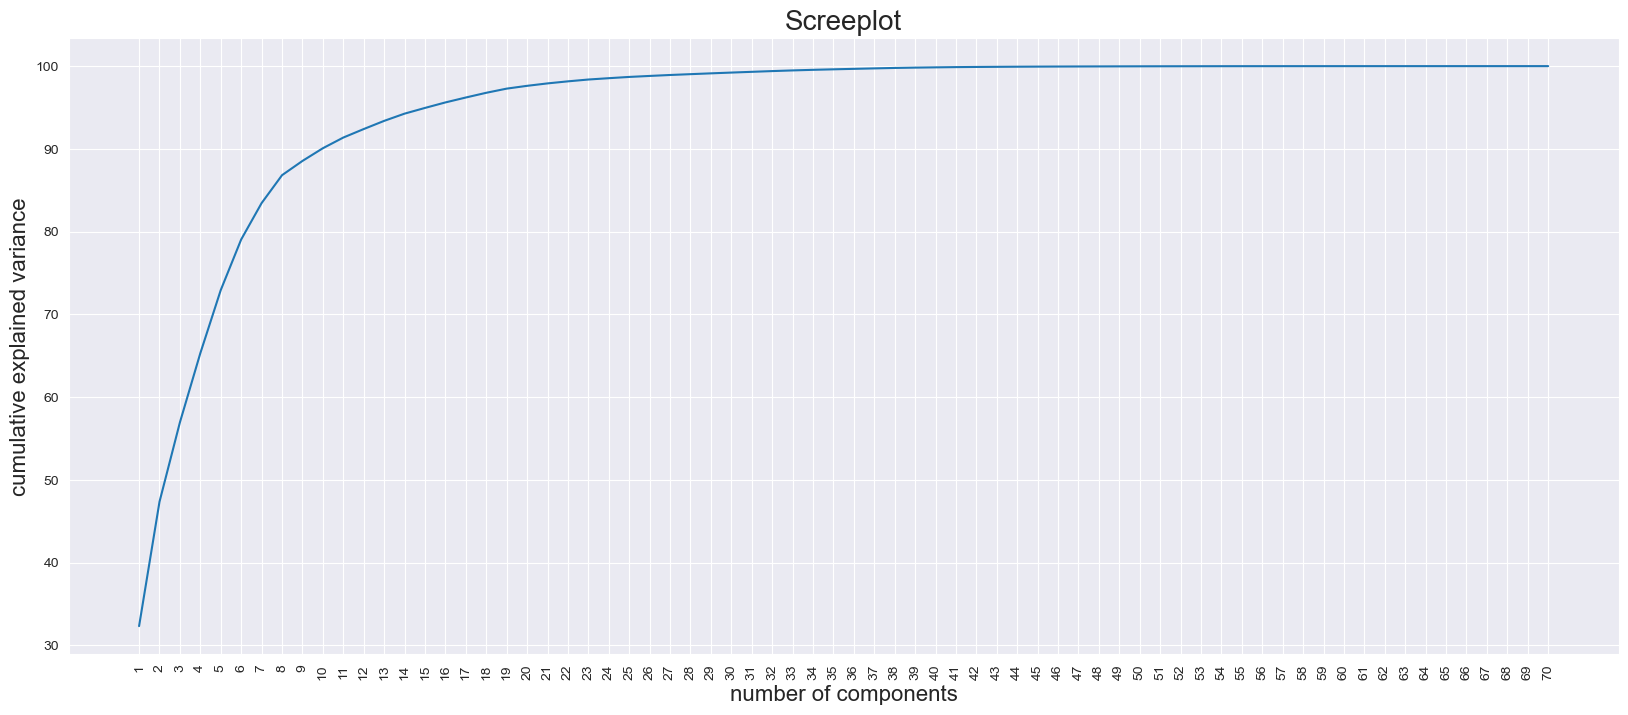

In [38]:
# plot scree plot to identify number of important PCs
%matplotlib inline
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,8))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.title('Screeplot', fontsize=20)
plt.xticks(range(pca.n_components_),range(1,pca.n_components_+1))
plt.xticks(rotation=90)
plt.show()

In [39]:
# 17 PC variables can clearly explain almost 96% of the observed variances
np.cumsum(pca.explained_variance_ratio_ * 100)[17]

96.77730037149918

In [40]:
# fit PCA and transform train data
pca = PCA(n_components=17,random_state=100)
X_train = pca.fit_transform(O_X_train)
y_train = O_y_train
X_train.shape

(29679, 17)

In [41]:
# transform test data that is previously fitted on train data
X_test = pca.transform(O_X_test)
y_test = O_y_test
X_test.shape

(300, 17)

### Use SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance
### Feed the PCA output to various models to identify the best classifier

In [42]:
# evaluation function that uses Stratified KFold croassvalidation and returns all classification metrics

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
all_result = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])
def basic_eval(classifiers,X=X_train,y=y_train):
  global all_result
  accuracy_lst = []
  precision_lst = []
  recall_lst = []
  f1_lst = []
  auc_lst = []
  result = pd.DataFrame(columns=['accuracy','precision','recall','f1','auc'])

  
  for key, classifier in classifiers.items():
      for train, test in skf.split(X, y):

          pipeline = make_pipeline(SMOTE(n_jobs=-1,random_state=100), classifier)
          pipeline.fit(X[train], y[train])
          prediction = pipeline.predict(X[test])

          accuracy_lst.append(accuracy_score(y[test], prediction))
          precision_lst.append(precision_score(y[test], prediction))
          recall_lst.append(recall_score(y[test], prediction))
          f1_lst.append(f1_score(y[test], prediction))
          auc_lst.append(roc_auc_score(y[test], prediction))
          
      s = pd.Series([round(np.mean(accuracy_lst),3),round(np.mean(precision_lst),3),round(np.mean(recall_lst),3),round(np.mean(f1_lst),3),
                      round(np.mean(auc_lst),3)], index=result.columns)
      s.name = key
      result = result.append(s)
      
      all_result = all_result.append(s)

  return result.sort_values(by='auc',ascending=False)

In [43]:
# evaluating all class of models to identify best class
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=100),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SupportVectorClassifier": SVC(random_state=100),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=100),
    "RandomForestClassifier": RandomForestClassifier(random_state=100),
    "GaussianNB": GaussianNB(),
}


##### Metrics and Evaluation

We will use Roc_auc as our prime metric for model evaluation because it involves 2 things

    True Positive Rate - how good are we at capturing positive cases (reduces churn)
    False Positive Rate - how good are we at avoiding false positives (saves money)

In [44]:
# calling the evaluating function to identify best classifier
basic_eval(classifiers)

accuracy  precision  recall     f1    auc
LogisiticRegression         0.791      0.265   0.797  0.398  0.794
SupportVectorClassifier     0.816      0.286   0.739  0.411  0.781
KNeighborsClassifier        0.801      0.265   0.735  0.389  0.771
DecisionTreeClassifier      0.818      0.275   0.675  0.389  0.753
RandomForestClassifier      0.834      0.306   0.652  0.409  0.752
GaussianNB                  0.798      0.282   0.678  0.385  0.744

Clearly we see that as per the AUC metric, the best classifier is the Logistic Regression model


### Perform Random Forest Classifier to identify the important variables

In [45]:
# Using Random Forest Classifier to identify the important variables
RFC = RandomForestClassifier(random_state=100).fit(O_X_train,O_y_train)

In [46]:
features = high_valued.drop('churn',axis=1).columns
importances = RFC.feature_importances_
imp_feat = pd.DataFrame({'feature': features,'importance':importances})
imp_feat = imp_feat.sort_values(by='importance',ascending=False).head(15)

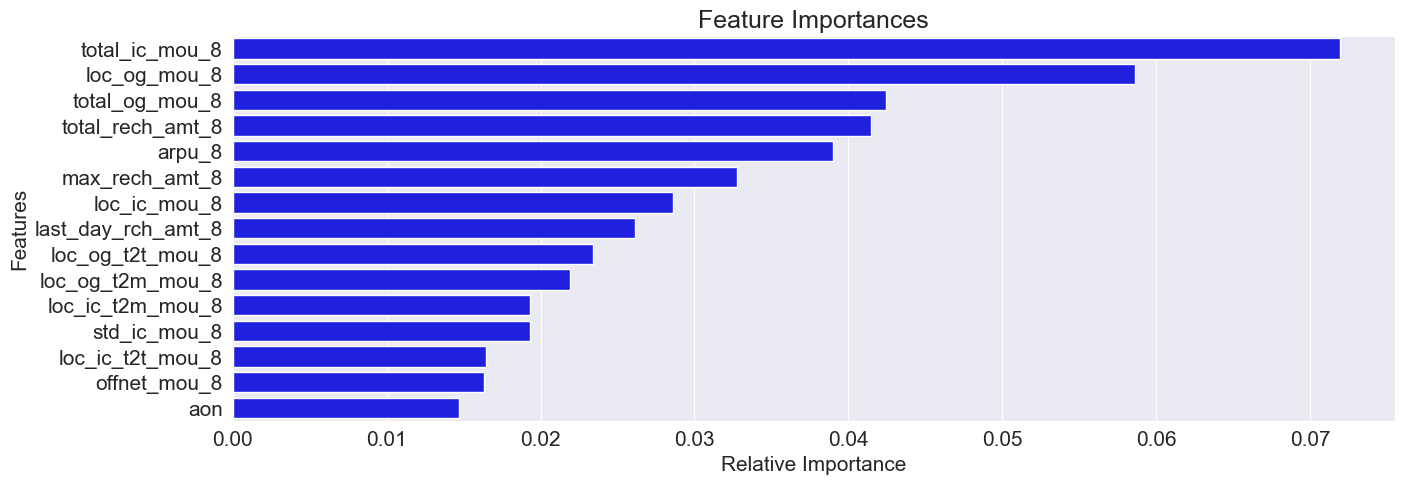

In [47]:
import matplotlib
plt.figure(figsize=(15, 5))
matplotlib.rcParams.update({'font.size': 15})
plt.title('Feature Importances')
ax = sns.barplot(x="importance", y="feature", data=imp_feat, color='b')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

1. The telecom company needs to pay attention to customers who use the local telcom operator and can provide them with different schemes to promote local calls on the same network.
2. Total recharge amount is also a main feature which can be levraged by providing exciting offers on top-ups with high amounts.
3. The company needs to focus on STD rates can be looked at and revised to a lower rate or provide them with some package with extra incentives. 
4. The company can also look at collecting the user complaint data and work on the services required by the consumers.